Connect google drive

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File paths

In [ ]:
path_to_combined_file = "/content/drive/MyDrive/Trump2020_CSS_course_project/processed_political_dataset.csv"

In [ ]:
submissions_file = "/content/drive/MyDrive/Trump2020_CSS_course_project/submissions_lemmatized.csv"
comments_file = '/content/drive/MyDrive/Trump2020_CSS_course_project/comments_lemmatized.csv'

In [ ]:
df = pd.read_csv(path_file)
display(df)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trump_CSS/processed_political_dataset.csv'

###  **Lematization**
At first let's do lematization to our dataset texts

In [ ]:
import spacy
import pandas as pd
import re
from tqdm.auto import tqdm

tqdm.pandas()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) # Load spaCy model and disable unnecessary components (parser, ner) for faster text processing

reddit_stopwords = ['https', 'http', 'www', 'com', 'reddit', 'subreddit', 'post', 'comment', 'amp', 'x200b', 'video']
for word in reddit_stopwords:
    nlp.Defaults.stop_words.add(word) # Add Reddit-specific terms to spaCy's default list of stop words

def clean_and_lemmatize(text):
    if pd.isna(text) or text == '':
        return ""

    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove all URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove all characters that are not letters or spaces

    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and len(token.text) > 2: # Filter out stop words, punctuation, spaces, and very short tokens
            cleaned_tokens.append(token.lemma_.lower()) # Get the base form (lemma) of the word and convert to lowercase

    return " ".join(cleaned_tokens)


df_subs['title_lemma'] = df_subs['title'].progress_apply(clean_and_lemmatize) # Process the 'title' column for Reddit submissions

df_subs['selftext_lemma'] = df_subs['selftext'].progress_apply(clean_and_lemmatize)

df_coms['text_lemma'] = df_coms['text'].progress_apply(clean_and_lemmatize)

print("Submissions columns:", df_subs.columns)
display(df_subs[['title', 'title_lemma', 'selftext_lemma']].head(3))

print("Comments columns:", df_coms.columns)
display(df_coms[['text', 'text_lemma']].head(3))

# **Overview**

**1. Basic info**

This dataset consists of Reddit submissions and comments and aims to research the social reaction on 2020 USA elections and Capytol raid 2021.

Subreedits that were used:

*Critics (Anti-Trump, Liberal)*

1. r/politics
2. r/democrats
3. r/politicaldiscussion


*Allies (Pro-Trump, Conservative)*

1. r/conservative
2. r/republicans
3. r/conspiracy


*Neutral*

1. r/news
2. r/worldnews
3. r/neutralpolitics



**2. Total numbers of records, shape and timeframe**

The number of records is 5.917.521.

The shape is 5.917.521 rows, 3 columns.

The time frame is 2020.10 – 2021.03.

In [ ]:
print(f"The number of records: {len(df)}")
print(f"The shape is: {df.shape}")
print(f"The time frame is {df.time_created.min()} to {df.time_created.max()}")


The number of records: 5917521
The shape is: (5917521, 3)
The time frame is 2020-10-01 00:00:00 to 2021-03-31 23:59:51


# **Activity and distribution**

**1. The distribution of activity over time**

Are there any peaks or anomalies in our dataset that could be used for our social research?
We will take the period of one month and check activity to find anomalies and peaks

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np


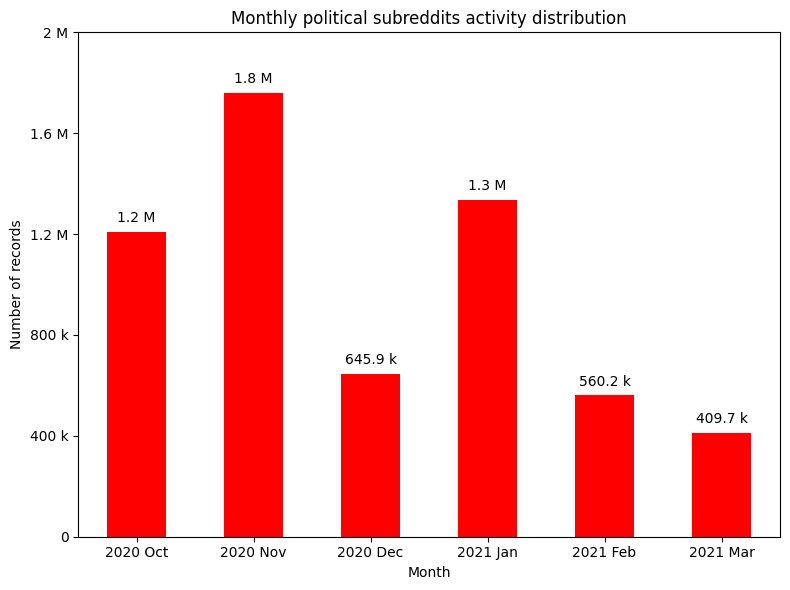

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np

df['time_created'] = pd.to_datetime(df['time_created']) # Convert timestamp to datetime objects
monthly_distribution = df.groupby(df['time_created'].dt.to_period('M')).size() # Group and count records by month
monthly_distribution.index = monthly_distribution.index.strftime('%Y %b') # Format index to 'Year Mon'
ax = monthly_distribution.plot(kind='bar', figsize = (8,6), color = 'red')
ax.yaxis.set_major_locator(ticker.MultipleLocator(400000))
ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Use engineering notation for Y-axis labels
ax.set_xlabel('Month')
ax.set_ylabel('Number of records')
ax.set_ylim(top = 2000000)
ax.bar_label(ax.containers[0], fmt = ticker.EngFormatter(places=1), padding = 5) # Add labels on top of bars using engineering notation
ax.set_title('Monthly political subreddits activity distribution')
plt.xticks(rotation=0)
plt.tight_layout()

We have peaks at october, november and january.

What subreddits had more records during these months?

**2. The distribution of activity over subreddits.**

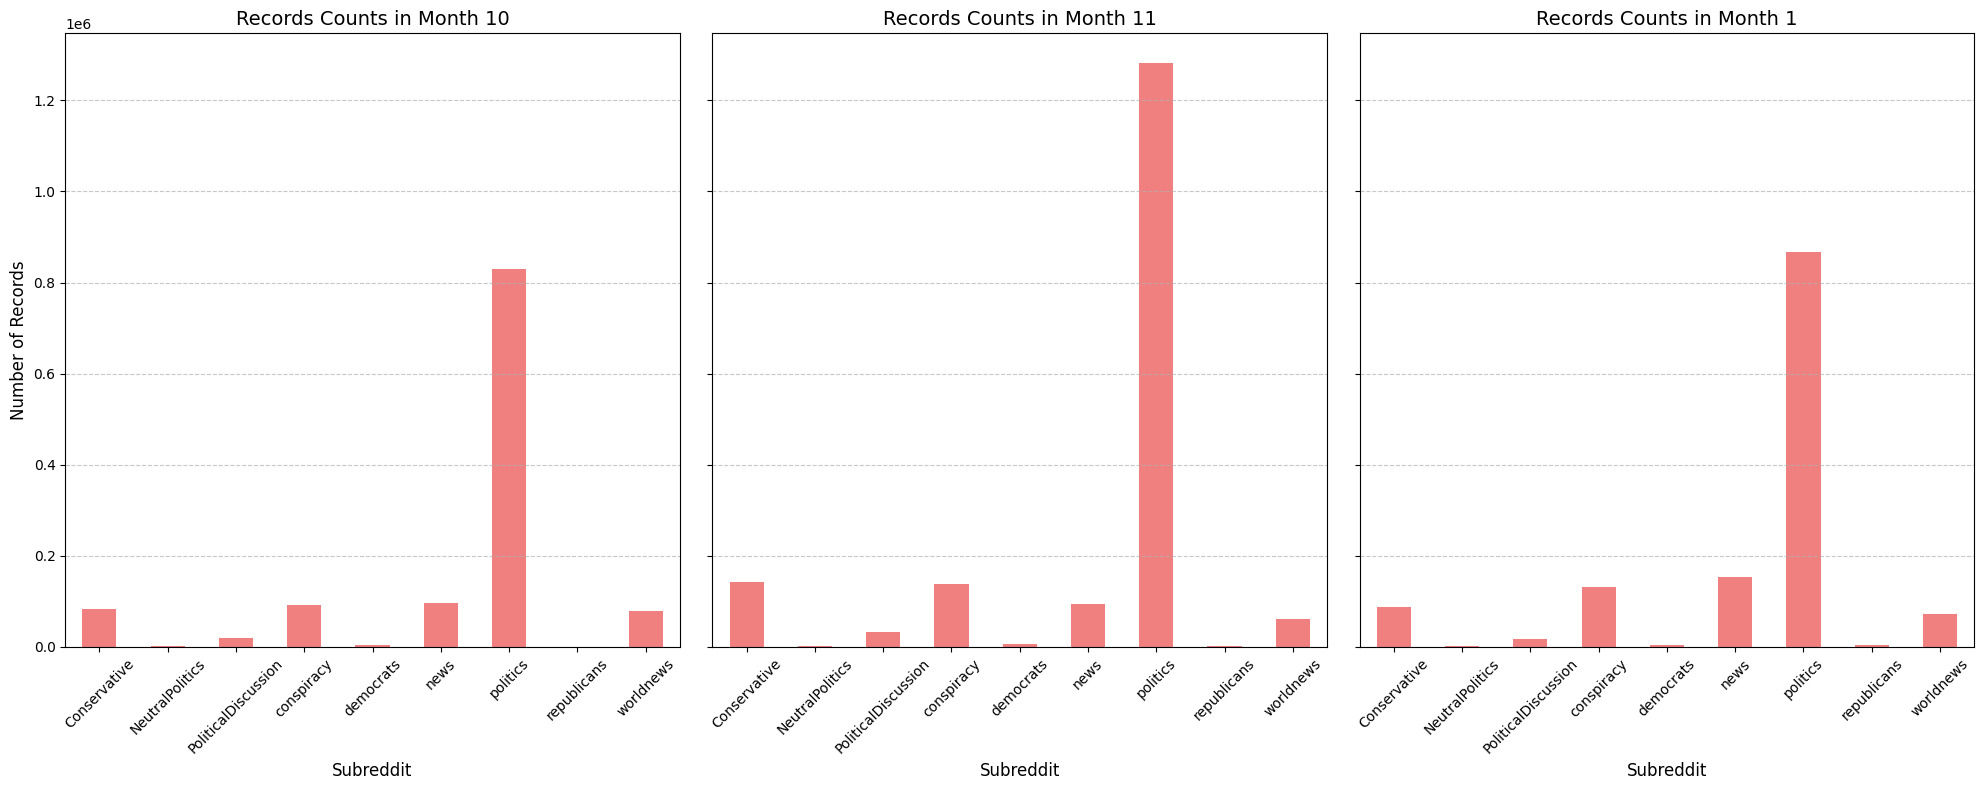

In [ ]:
peak_months = [10,11,1]
df['month'] = df['time_created'].dt.month
select_peak_m = df['month'].isin(peak_months)
peak_df = df[select_peak_m] # Filter DataFrame to keep only peak months

peak_months_records = peak_df.pivot_table(index='subreddit',
  columns='month',
  values='text',
  aggfunc='count' # Count records for each subreddit in each peak month
)
peak_months_records = peak_months_records[peak_months] # Ensure month columns are ordered correctly
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True) # Create 3 subplots that share the Y-axis
for i, month in enumerate(peak_months):
  ax = axes[i]
  month_data = peak_months_records[month]
  month_data.plot(
      kind='bar',
      ax=ax,
      color='lightcoral'
  ) # Plot bar chart for the current month
  ax.set_title(f'Records Counts in Month {month}', fontsize=14)
  ax.set_xlabel('Subreddit', fontsize=12)
  ax.set_ylabel('Number of Records', fontsize=12)
  ax.tick_params(axis='x', rotation=45)
  ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In conclusion, the biggest number of records was made by politics subreddit.

**We will analyze the daily distribution of posts to determine which days saw the highest intensity of discussions.**

In [ ]:
import pandas as pd
df_subs = pd.read_csv(submissions_file, low_memory=False)
df_subs['time_created'] = pd.to_datetime(df_subs['time_created'])
df_coms = pd.read_csv(comments_file, low_memory=False)
df_coms['time_created'] = pd.to_datetime(df_coms['time_created'])

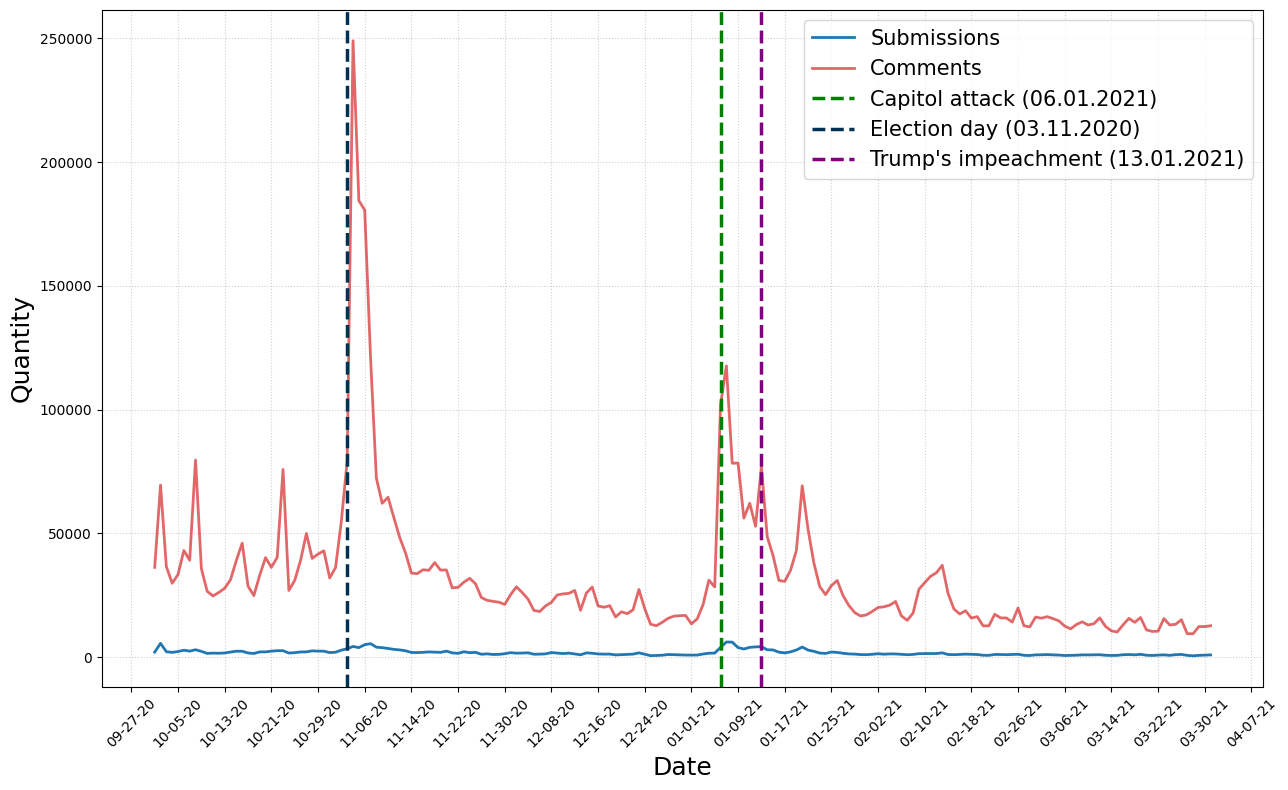

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

daily_subs = df_subs.groupby(df_subs['time_created'].dt.date).size().rename('posts') # Calculate the daily count of submissions (posts)
daily_coms = df_coms.groupby(df_coms['time_created'].dt.date).size().rename('comments') # Calculate the daily count of comments

fig, ax = plt.subplots(figsize=(13, 8))

daily_subs.plot(ax=ax, label='Submissions', color='#1f77b4', linewidth=2)
daily_coms.plot(ax=ax, label='Comments', color='#d62728', linewidth=2, alpha=0.7)

ax.axvline(pd.to_datetime('2021-01-06'), color='green', linestyle='--', linewidth=2.5, label='Capitol attack (06.01.2021)') # Add vertical line for the Capitol attack date
ax.axvline(pd.to_datetime('2020-11-03'), color='#003153', linestyle='--', linewidth=2.5, label='Election day (03.11.2020)') # Add vertical line for Election Day
ax.axvline(pd.to_datetime('2021-01-13'), color='purple', linestyle='--', linewidth=2.5, label="Trump's impeachment (13.01.2021)") # Add vertical line for the impeachment date
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%y")) # Format X-axis labels to display month-day-year
ax.xaxis.set_major_locator(mdates.DayLocator(interval=8)) # Set major ticks to appear every 8 days

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Quantity', fontsize=18)

ax.legend(loc='upper right', fontsize=15)
ax.grid(True, linestyle=':', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We highlight the activity of subreddits on the days of these spikes to answer the question: did liberal communities dominate during the election and did activity shift toward conservative blocs during the events of January?**

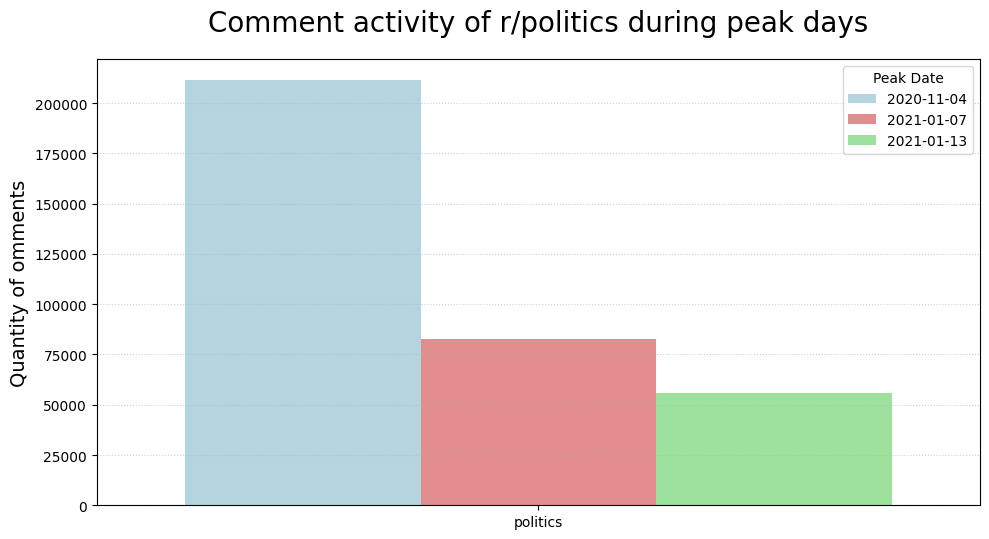

In [ ]:
import seaborn as sns

df_coms['date'] = df_coms['time_created'].dt.date # Extract only the date part from the datetime object
peak_dates = [pd.to_datetime('2020-11-03').date(),pd.to_datetime('2021-01-07').date(), pd.to_datetime('2021-01-13').date()] # Define the three peak dates
df_peaks = df_coms[df_coms['date'].isin(peak_dates)] # Filter comments to include only the peak dates
df_subreddit_activity = df_peaks.groupby(['date', 'subreddit']).size().reset_index(name='record_count') # Calculate the comment count for each subreddit on each peak date

df_politics = df_subreddit_activity[df_subreddit_activity['subreddit'] == 'politics'].copy() # Filter the activity data to focus only on the 'politics' subreddit

plt.figure(figsize=(10, 5.5))
sns.barplot(data=df_politics, x='subreddit', y='record_count', hue='date', palette=['lightblue', 'lightcoral', 'lightgreen']) # Create a bar plot showing comment count (y) for r/politics (x) split by date (hue)

plt.title('Comment activity of r/politics during peak days', fontsize=20, pad=20)
plt.xlabel('')
plt.ylabel('Quantity of omments', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Peak Date', loc='upper right')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

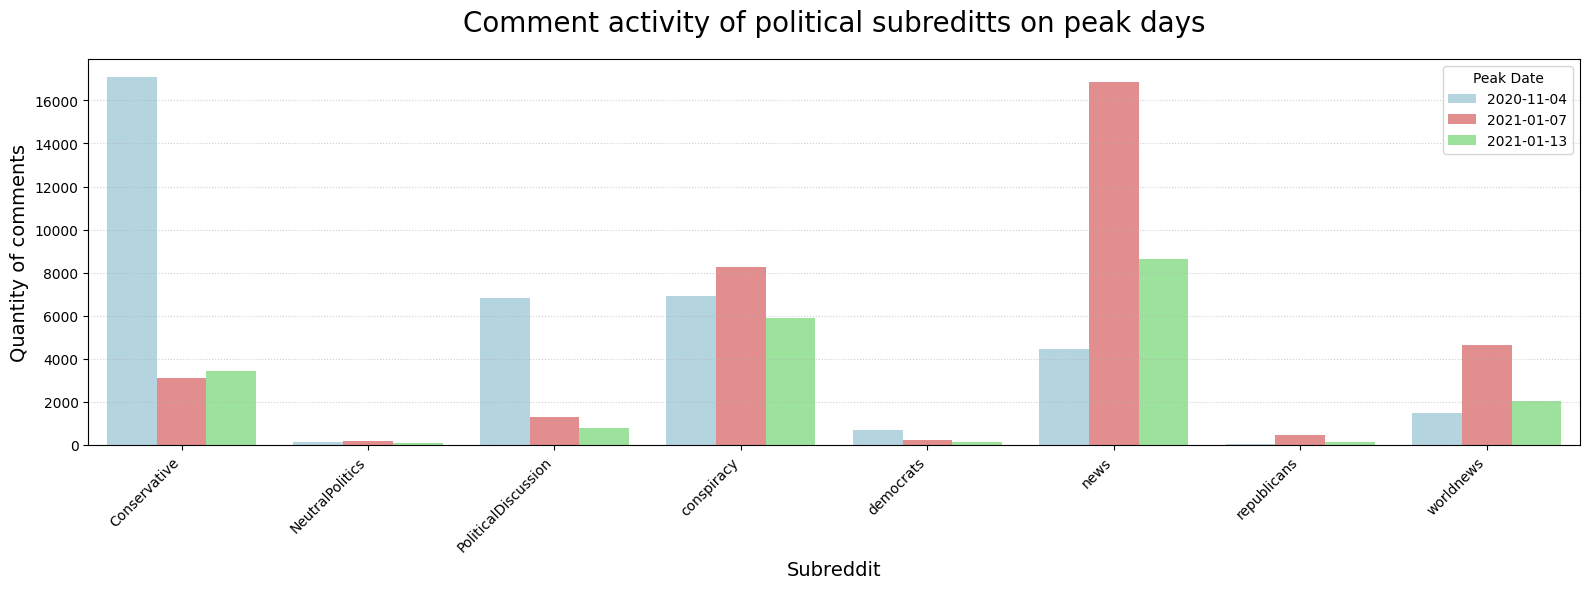

In [ ]:
df_other_subs = df_subreddit_activity[df_subreddit_activity['subreddit'] != 'politics'].copy() # Filter the data to exclude the 'politics' subreddit

plt.figure(figsize=(16, 6))
sns.barplot(data=df_other_subs, x='subreddit', y='record_count', hue='date', palette=['lightblue', 'lightcoral', 'lightgreen']) # Create a bar plot showing comment count (y) for other subreddits (x) split by date (hue)

plt.title('Comment activity of political subreditts on peak days', fontsize=20, pad=20)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Quantity of comments', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels by 45 degrees for better readability
plt.legend(title='Peak Date', loc='upper right')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

We can group into 2 groups democrats/republicans to find more info about activity.

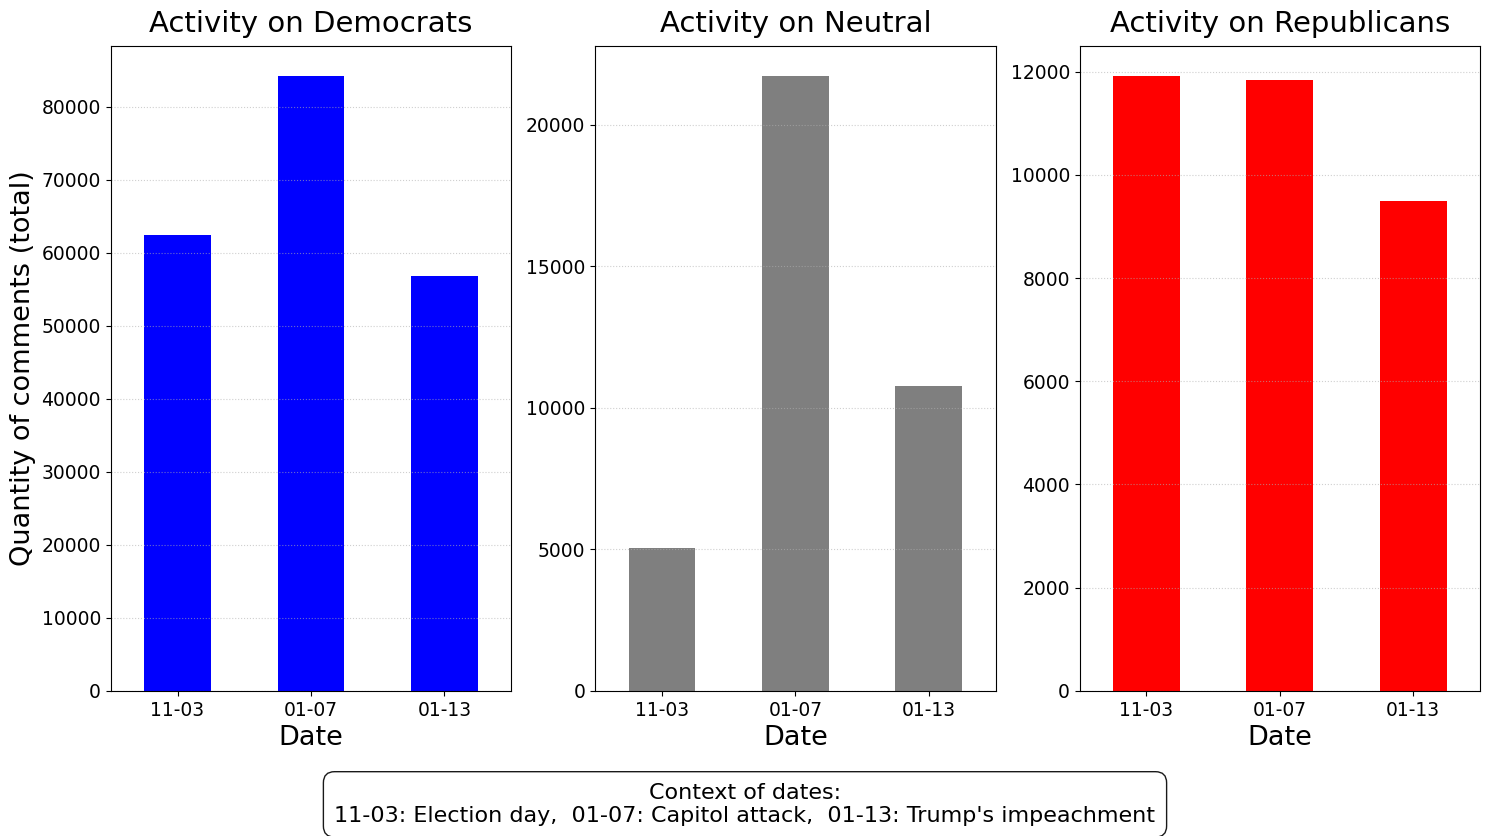

In [ ]:
grouped_subs = {
    'Conservative': 'republicans',
    'republicans': 'republicans',
    'conspiracy': 'republicans',
    'news': 'neutral',
    'worldnews': 'neutral',
    'NeutralPolitics': 'neutral',
    'politics': 'democrats',
    'democrats': 'democrats',
    'PoliticalDiscussion': 'democrats'
}
grouped_df = df_subreddit_activity.pivot_table(index='subreddit',
                    columns='date',
                    values='record_count',
                    )
grouped_df = grouped_df.groupby(grouped_subs).sum() # Group subreddits into broader political categories and sum comment counts
grouped_df = grouped_df.stack().reset_index() # Convert the pivot table back to long format
grouped_df.columns = ['group', 'date', 'record_count']
groups_select = grouped_df['group'].unique()


fig, axes = plt.subplots(1, 3, figsize=(15,8)) # Create figure with 3 subplots
for i, group in enumerate(groups_select):
      ax = axes[i]
      groups_data = grouped_df[grouped_df['group'] == group]
      groups_data.plot(
          kind='bar',
          x='date',
          y='record_count',
          ax=ax,
          color= {
                'democrats': 'blue',
                'republicans': 'red',
                'neutral': '#7f7f7f'
                }.get(group), # Assign color based on the group name
          legend = False,

      )

      ax.tick_params(axis='y', labelsize=13.5)
      ax.set_xticklabels(pd.to_datetime(groups_data['date']).dt.strftime('%m-%d'), rotation=0, fontsize=13.5)
      ax.set_title(f'Activity on {group.capitalize()}', fontsize=21, pad=10)
      ax.set_xlabel('Date', fontsize=19.5)
      if i == 0:
          ax.set_ylabel('Quantity of comments (total)', fontsize=19.5) # Set Y-axis label only for the first subplot
      else:
          ax.set_ylabel('')
      ax.set_xticklabels(pd.to_datetime(groups_data['date']).dt.strftime('%m-%d'), rotation=0)
      ax.grid(axis='y', linestyle=':', alpha=0.6)

plt.grid(axis='y', linestyle=':', alpha=0.6)
caption_text = (
    "Context of dates:\n"
    "11-03: Election day,  "
    "01-07: Capitol attack,  "
    "01-13: Trump's impeachment"
)

bbox_props = dict(
    boxstyle="round,pad=0.5",
    fc="white",
    ec="black",
    lw=1,
    alpha=0.9
)


fig.text(
    0.5,
    -0.05,
    caption_text, # Add descriptive text below the subplots
    ha='center',
    fontsize=16,
    wrap=True,
    bbox

Here we can see that the biggest number of democrats' and republicans' comments were during the election results.

Neutral group was the most active on the day of capytol raid. Also during raid and impeachment republicans were more active than democrats.

If we compare democrats subreddit to republican subreddit, we will find more info about the change of the activity.

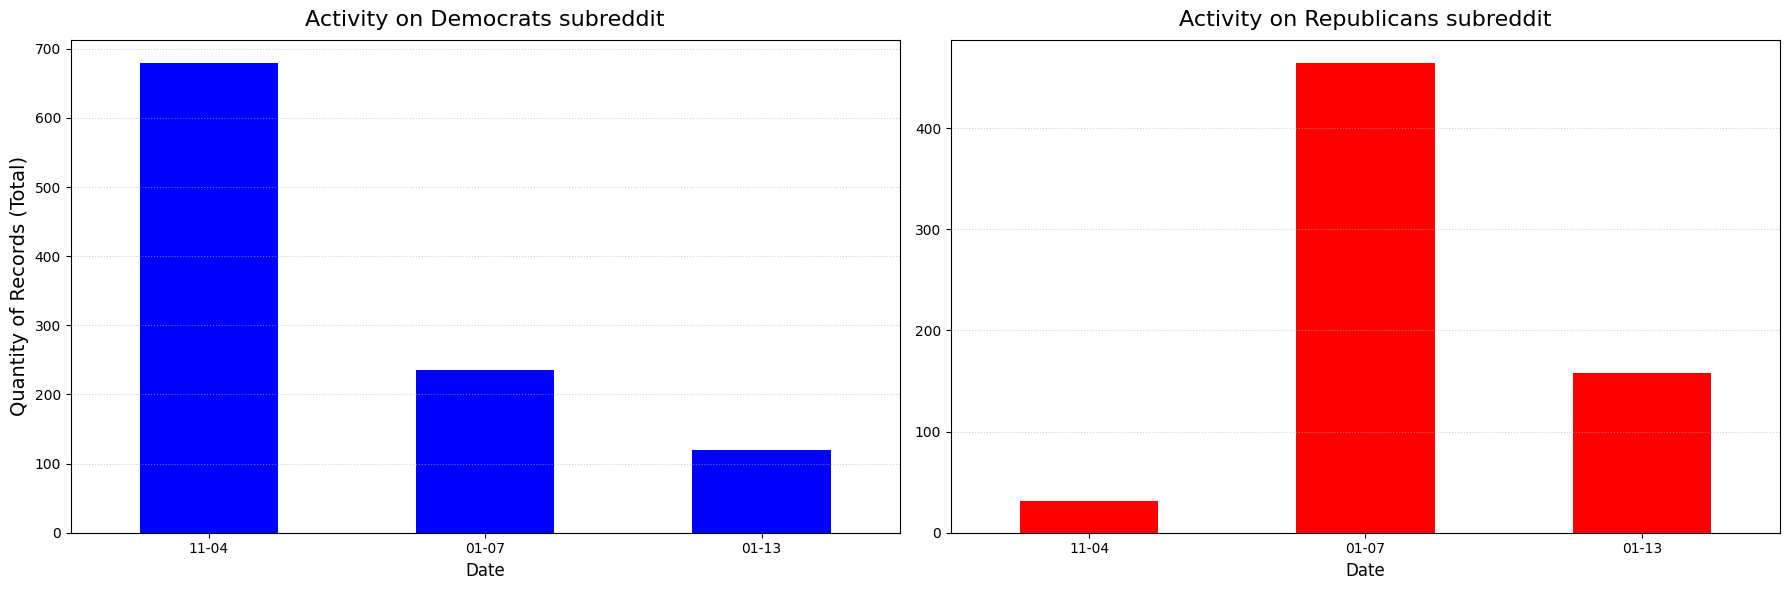

In [ ]:
d_r = df_subreddit_activity[df_subreddit_activity['subreddit'].isin(['democrats', 'republicans'])] # Filter activity data for 'democrats' and 'republicans' subreddits
fig, axes = plt.subplots(1, 2, figsize=(18,6)) # Create a figure with two subplots side-by-side
subs_select = d_r['subreddit'].unique()
for i, subr in enumerate(subs_select):
      ax = axes[i]
      subs_data = d_r[d_r['subreddit'] == subr]
      subs_data.plot(
          kind='bar',
          x='date',
          y='record_count',
          ax=ax,
          color= {
                'democrats': 'blue',
                'republicans': 'red',
                }.get(subr), # Assign color based on the subreddit name
          legend = False
      )
      ax.set_title(f'Activity on {subr.capitalize()} subreddit', fontsize=16, pad=10)
      ax.set_xlabel('Date', fontsize=12)
      if i == 0:
          ax.set_ylabel('Quantity of Records (Total)', fontsize=14) # Set Y-axis label only for the first subplot
      else:
          ax.set_ylabel('')
      ax.set_xticklabels(pd.to_datetime(subs_data['date']).dt.strftime('%m-%d'), rotation=0) # Format X-axis labels to month-day
      ax.grid(axis='y', linestyle=':', alpha=0.6)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()

Here we can see that people on Republicans subreddit had huge reaction on capytol raid, where as Democrats had the most comments during the election results.

To conclude, we can say that the biggest polarization was during the election results. Also, democrats have a far bigger community than republicans.

During Capitol raid and impeachment polarization was low, conservatives were more active than democrats, neutral group was the most active during raid and impeachment.

# **Content analysis**

**1. Frequent terms**

However, the quantity of posts doesn't tell the full story. This section moves from "how many" to "what" by analyzing the text content itself. Let's start with analysing frequent terms

At first, let's find out what are the most common 2-word phrases used across liberal, conservative and neutral communities on the peak days? This way we can understand about what the conversation was in different periods of time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(text, n=100):
    # Initialize CountVectorizer to extract bigrams (ngram_range=(2, 2)), exclude common English stop words and limit vocabulary size
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(text.fillna('').astype(str))
    sum_words = X.sum(axis=0) # Sum the counts across all documents for each bigram
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) # Sort bigrams by their total count in descending order
    return pd.DataFrame(words_freq, columns = ['Bigram', 'Count']).head(n) # Return the top 'n' bigrams as a DataFrame

In [ ]:
UNWANTED_BIGRAMS = (
    'https www|twitter com|reddit com|www reddit|https twitter|com politics|'
    'message compose|com message|politics comments|compose politics|'
    'question regarding|regarding removal|removal submission|message moderators|'
    'feel free|politics wiki|thank participating|participating politics|'
    'questions removal|removal feel|2021 01|nytimes com|president trump|don think|'
    'think know|going happen|know right|white house|united states|free message|'
    'moderators https|politics amp|amp subject|subject question|amp message|'
    'message question|www nytimes|01 05|lot people|want see|want know|people know|'
    'don know|said said|point view|mean people|ve seen|new york|los angeles|'
    'lot things|believe said|just like|don want|looks like|like trump|pop lt|'
    'lt gt| gt pop|com interactive|interactive 2021|05 elections|runoff html|'
    'submission https|domains list|approved domains|wiki approveddomainslist|'
    'amp x200b|com realdonaldtrump|article submitted|submitted article|'
    'submitted politics|submission removed|removed following|following reason|'
    'politics submission|reason submitted|trump just|trump supporter|nytimes com|'
    'https redd|submit spam|comments krz3gr|social media|https np|np reddit|people like'
    'com conspiracy|com news|days https|politics days|wiki index|don like|think trump'
    'com autotldr|autotldr comments|amp quot|amp 039|http np|org wiki'
    'en wikipedia|election night|2020 11|wi mi|years ago|http np|gt gt'
)

In [ ]:
DATES = {
    'Elections': pd.to_datetime('2020-11-04').date(),
    'Capitol attack': pd.to_datetime('2021-01-07').date(),
    'Impeachment': pd.to_datetime('2021-01-13').date()
}
SUBREDDIT_MAP = {
    'Liberal': ['politics', 'PoliticalDiscussion', 'democrats'],
    'Conservative': ['Conservative', 'republicans', 'conspiracy'],
    'Neutral': ['news', 'worldnews', 'NeutralPolitics']
}

In [ ]:
def analyze_and_plot_comments_biagrams(df_coms, date_name, target_date, select_col):
    df_date_data = df_coms[df_coms['time_created'].dt.date == target_date].copy() # Filter the DataFrame to include only records from the target date
    fig, axes = plt.subplots(1, 3, figsize=(28, 14))

    fig.suptitle(f'Bigram Frequency: {date_name} ({target_date})', fontsize=28, y=1.03)

    for i, (category, subreddits) in enumerate(SUBREDDIT_MAP.items()): # Loop through predefined subreddit categories (e.g., Liberal, Conservative, Neutral)
        ax = axes[i]
        category_text = df_date_data[
            df_date_data['subreddit'].isin(subreddits)][select_col] # Select text from subreddits belonging to the current category
        df_top_category = get_top_bigrams(category_text) # Get the top bigrams using function

        if not df_top_category.empty:
            df_top_category = df_top_category[
                ~df_top_category['Bigram'].str.contains(UNWANTED_BIGRAMS, regex=True, case=False)].head(20) # Filter out unwanted bigrams (defined in UNWANTED_BIGRAMS) and keep top 20

        color_map = {'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'grey'}

        if not df_top_category.empty:
            sns.barplot(data=df_top_category, x='Count', y='Bigram', ax=ax, color=color_map[category]) # Create a bar plot of the top bigrams
            ax.set_title(f'{category} subreddits', fontsize=35, pad=15)
        else:
            ax.text(0.5, 0.5, 'No valid bigrams found.', ha='center', va='center', fontsize=14, color='gray') # Display message if no bigrams are found
            ax.set_title(f'{category} subreddits', fontsize=31)

        ax.set_xlabel('Frequency Count', fontsize=30, labelpad=15)
        ax.set_ylabel('Bigram (2-word phrase)' if i == 0 else '', fontsize=28, labelpad=30) # Set Y-axis label only for the first subplot
        ax.tick_params(axis='y', labelsize=25)
        ax.tick_params(axis='x', labelsize=25)


    plt.tight_layout()
    plt.show()

In [ ]:
def create_title_figure(main_title):
    fig, ax = plt.subplots(figsize=(24, 1.5))
    fig.suptitle(main_title, fontsize=28, y=0.5, ha='center')
    ax.axis('off')
    plt.show()

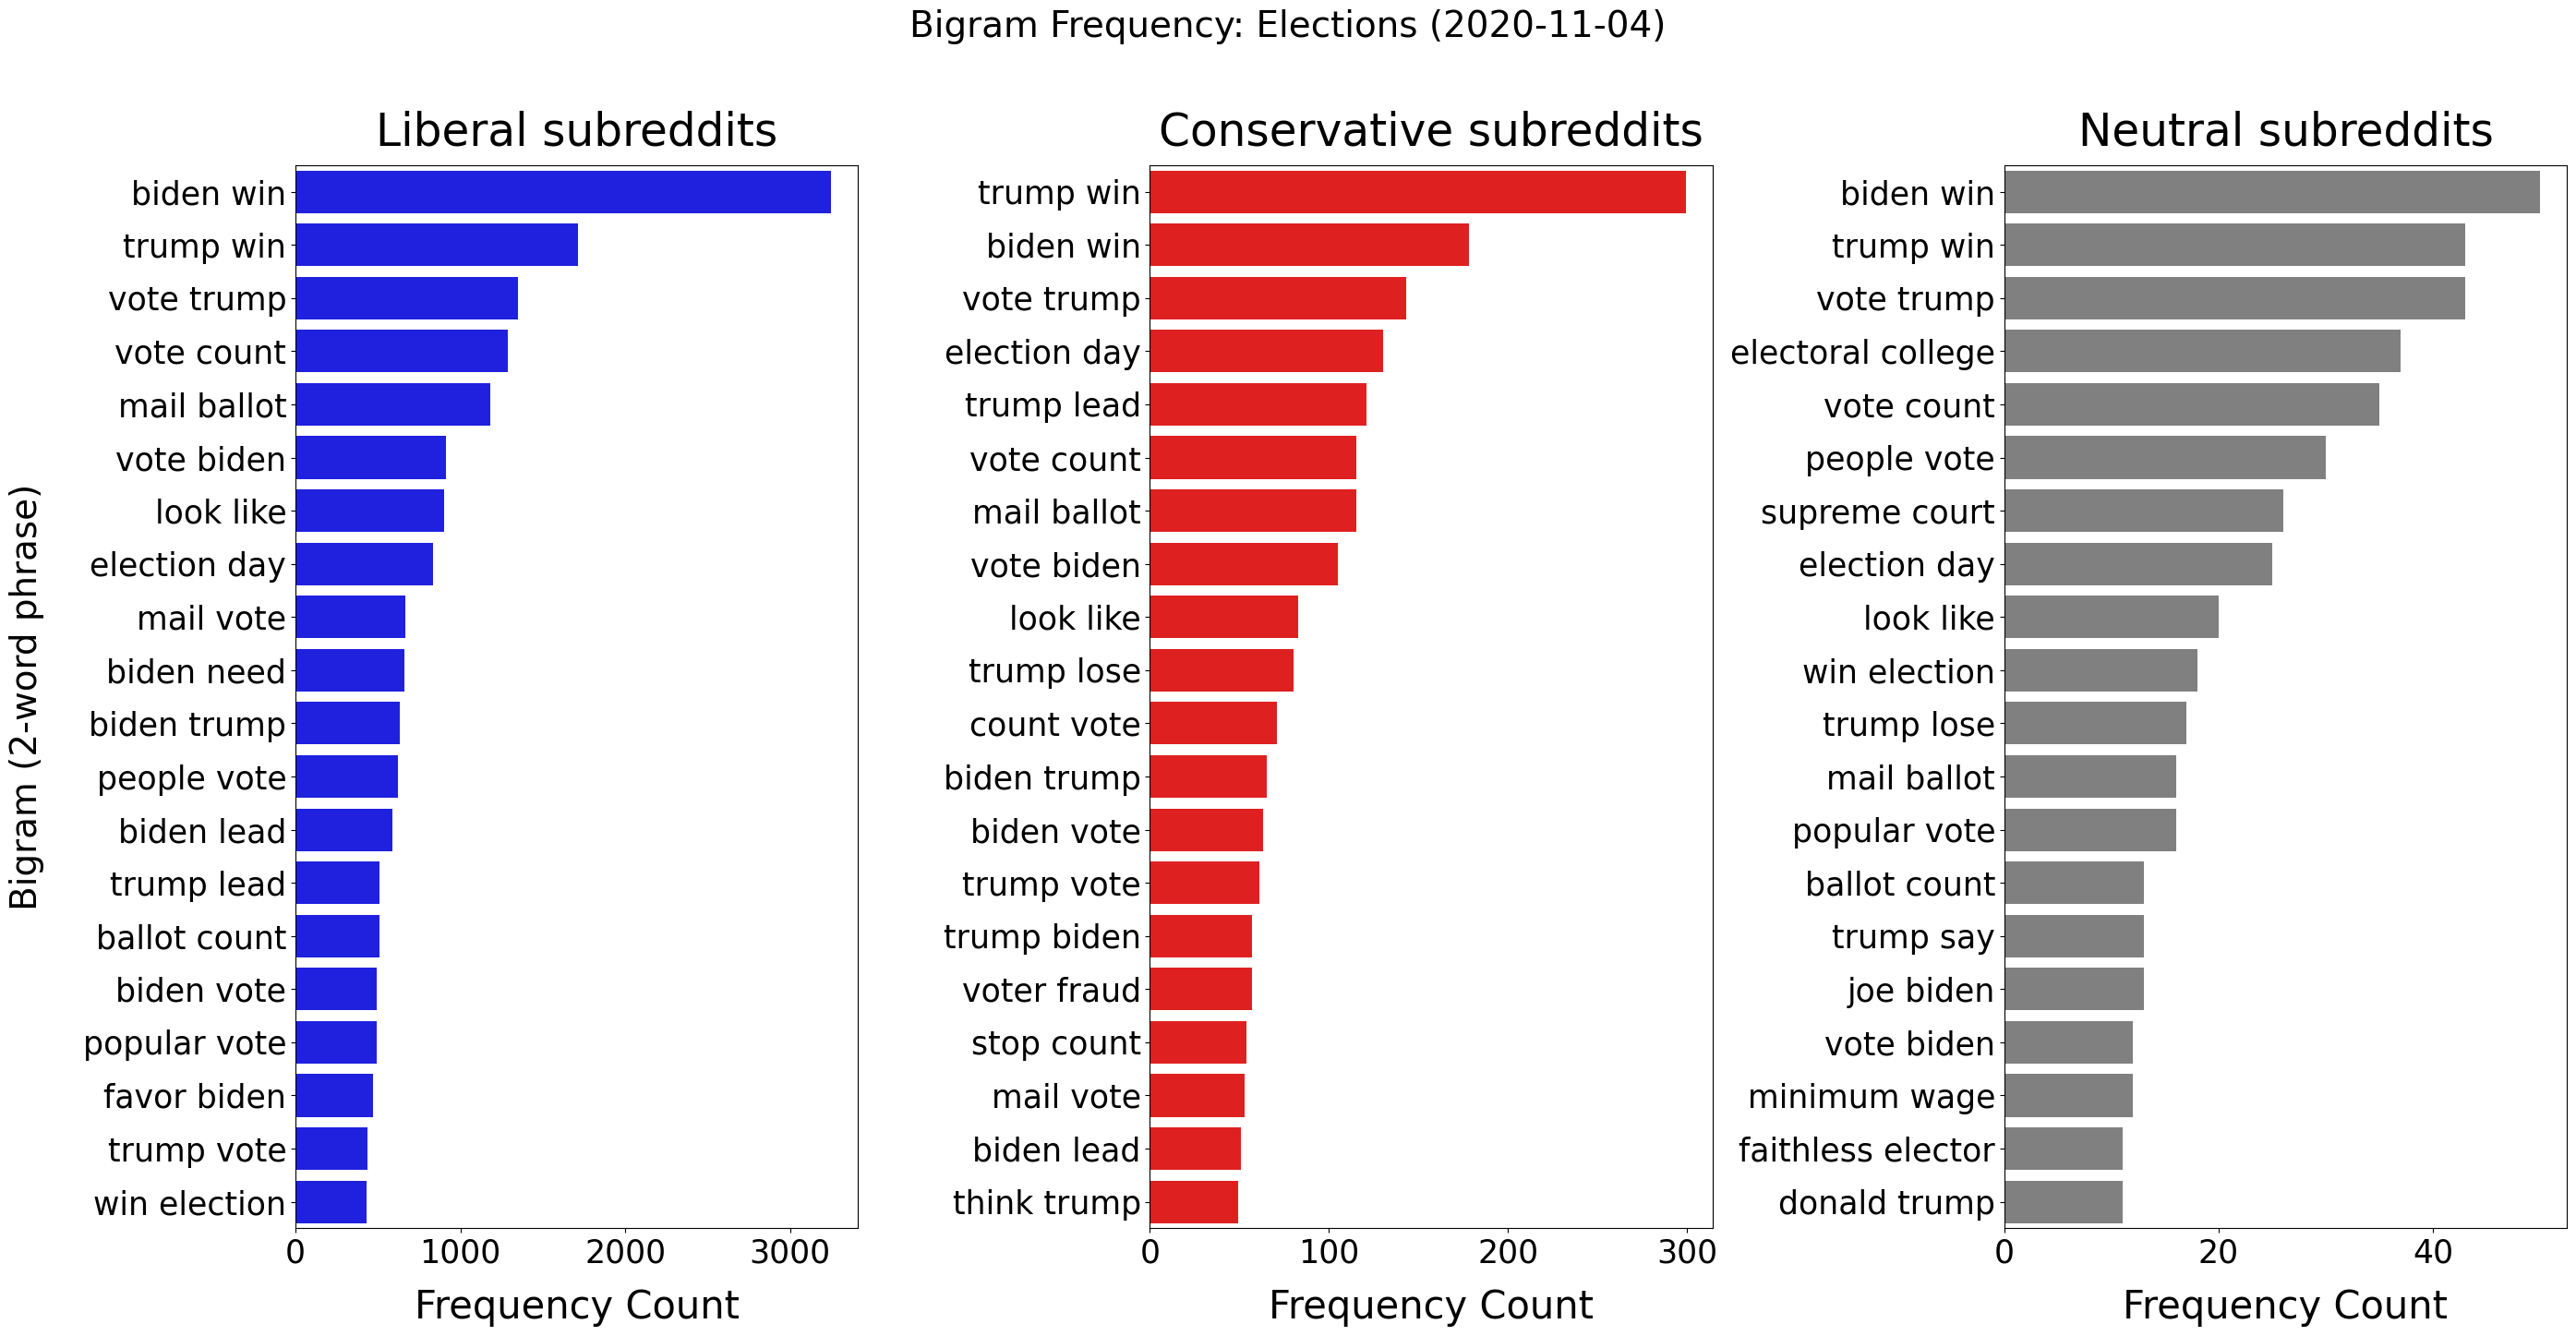

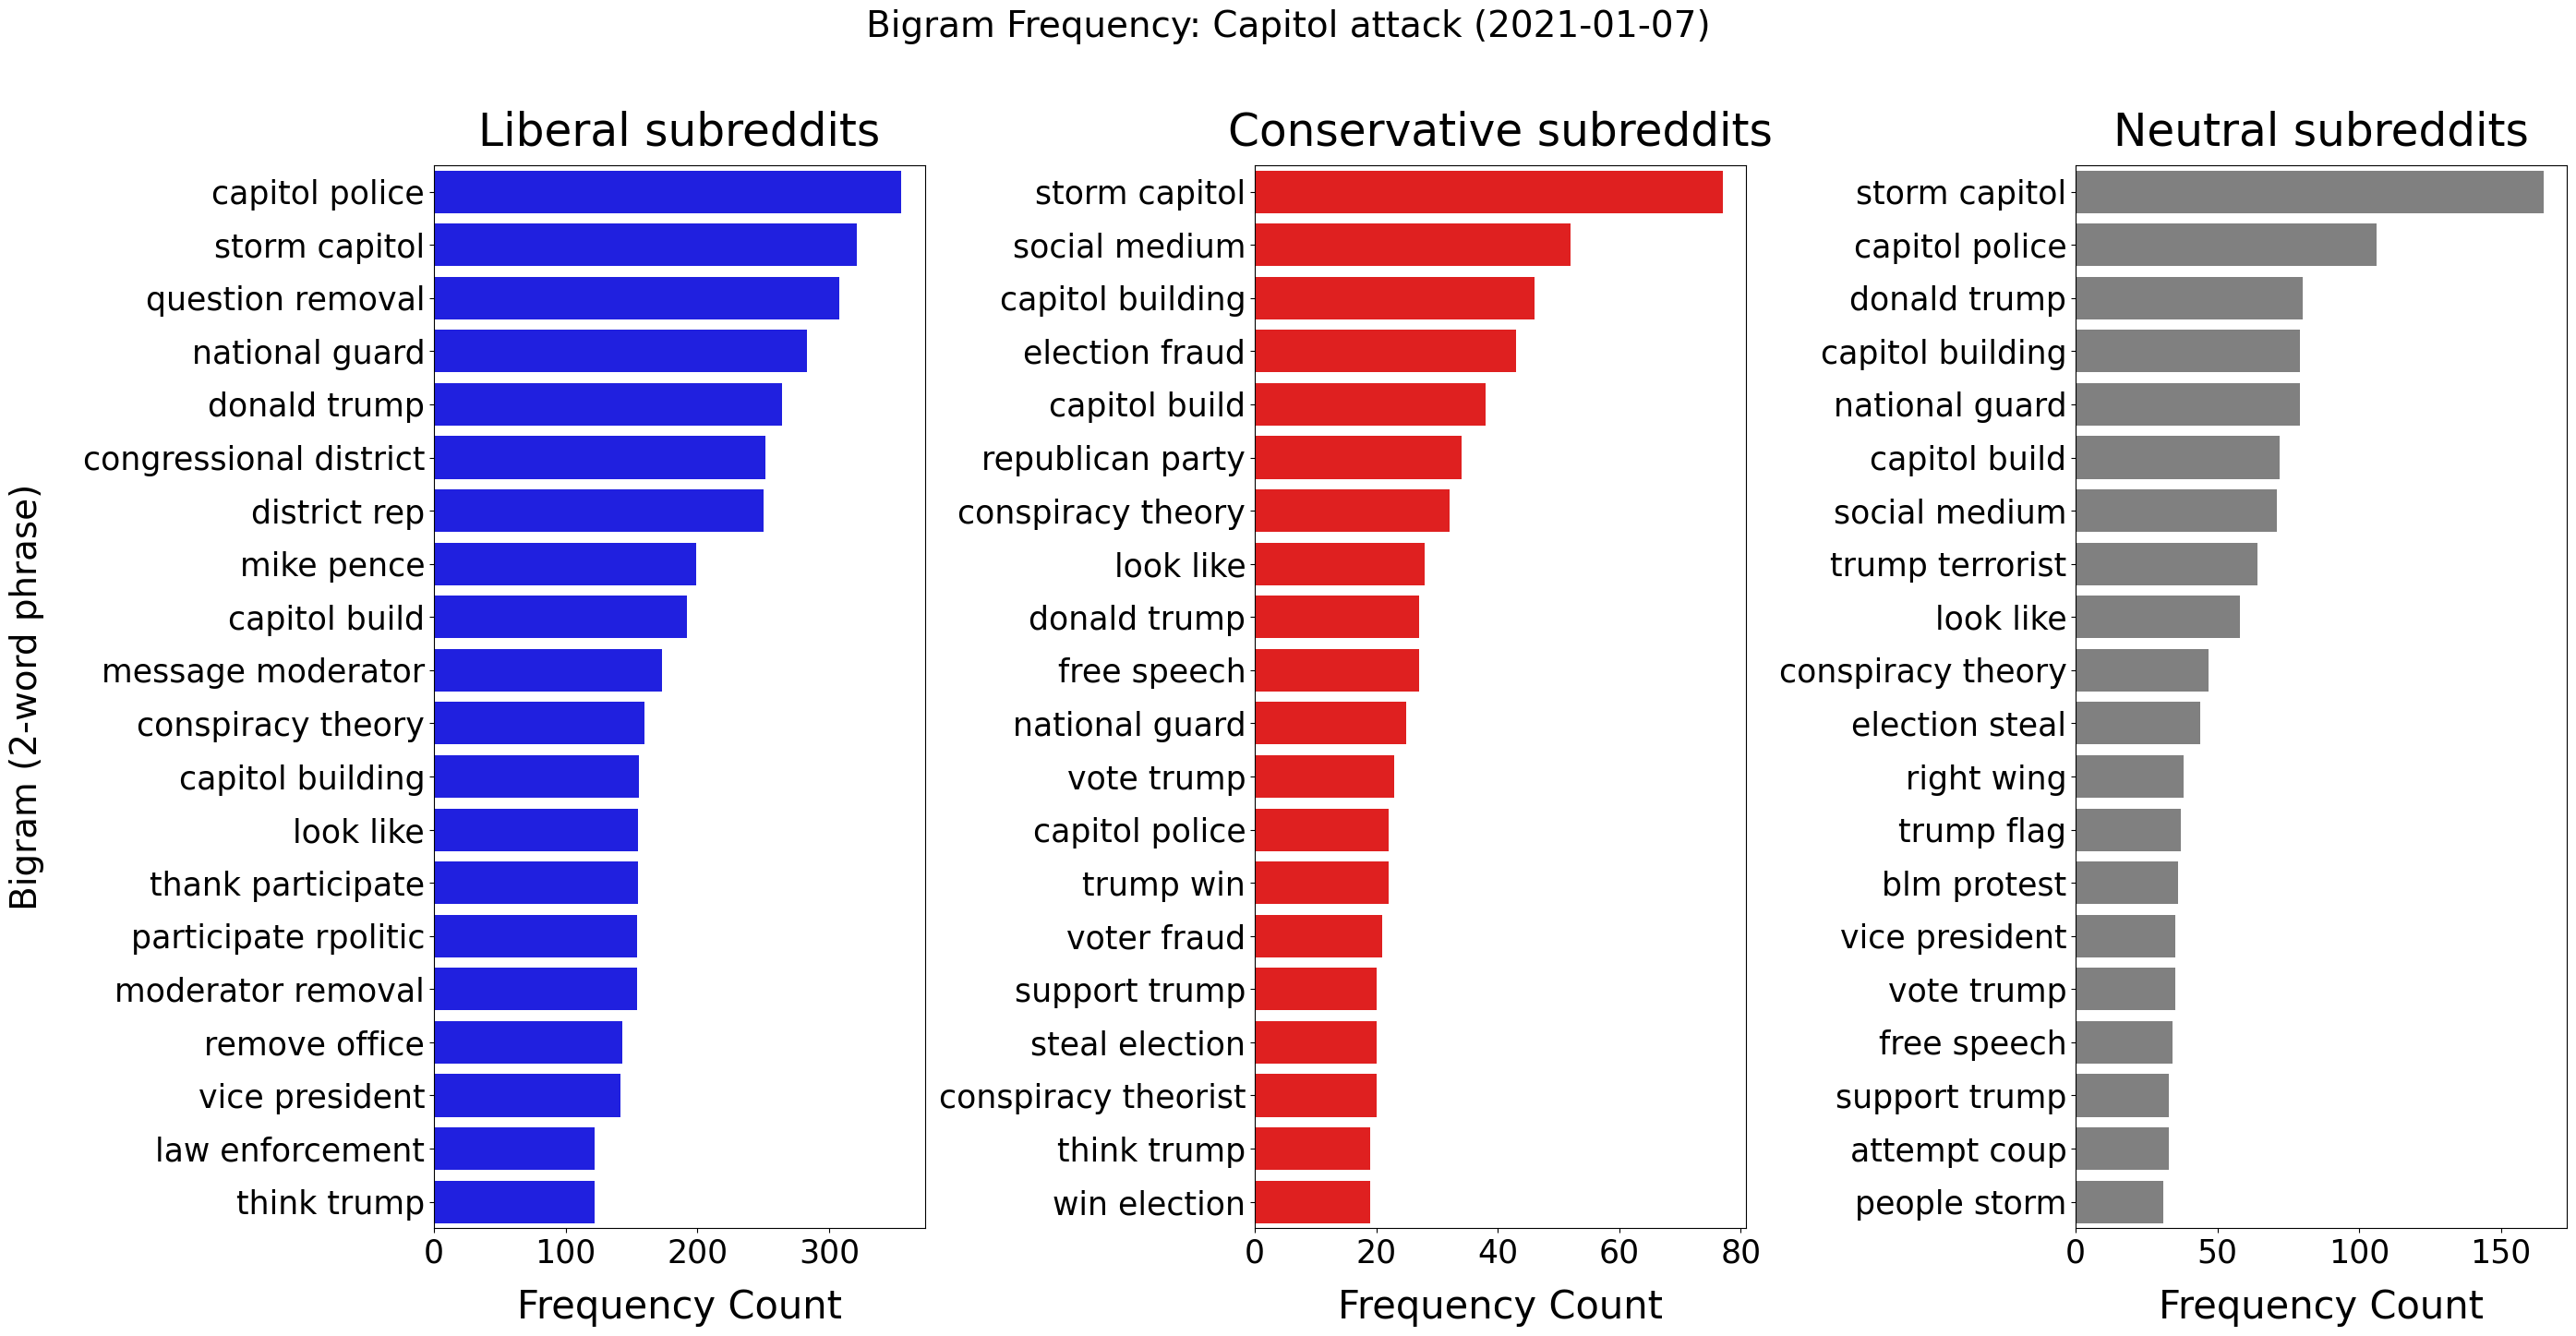

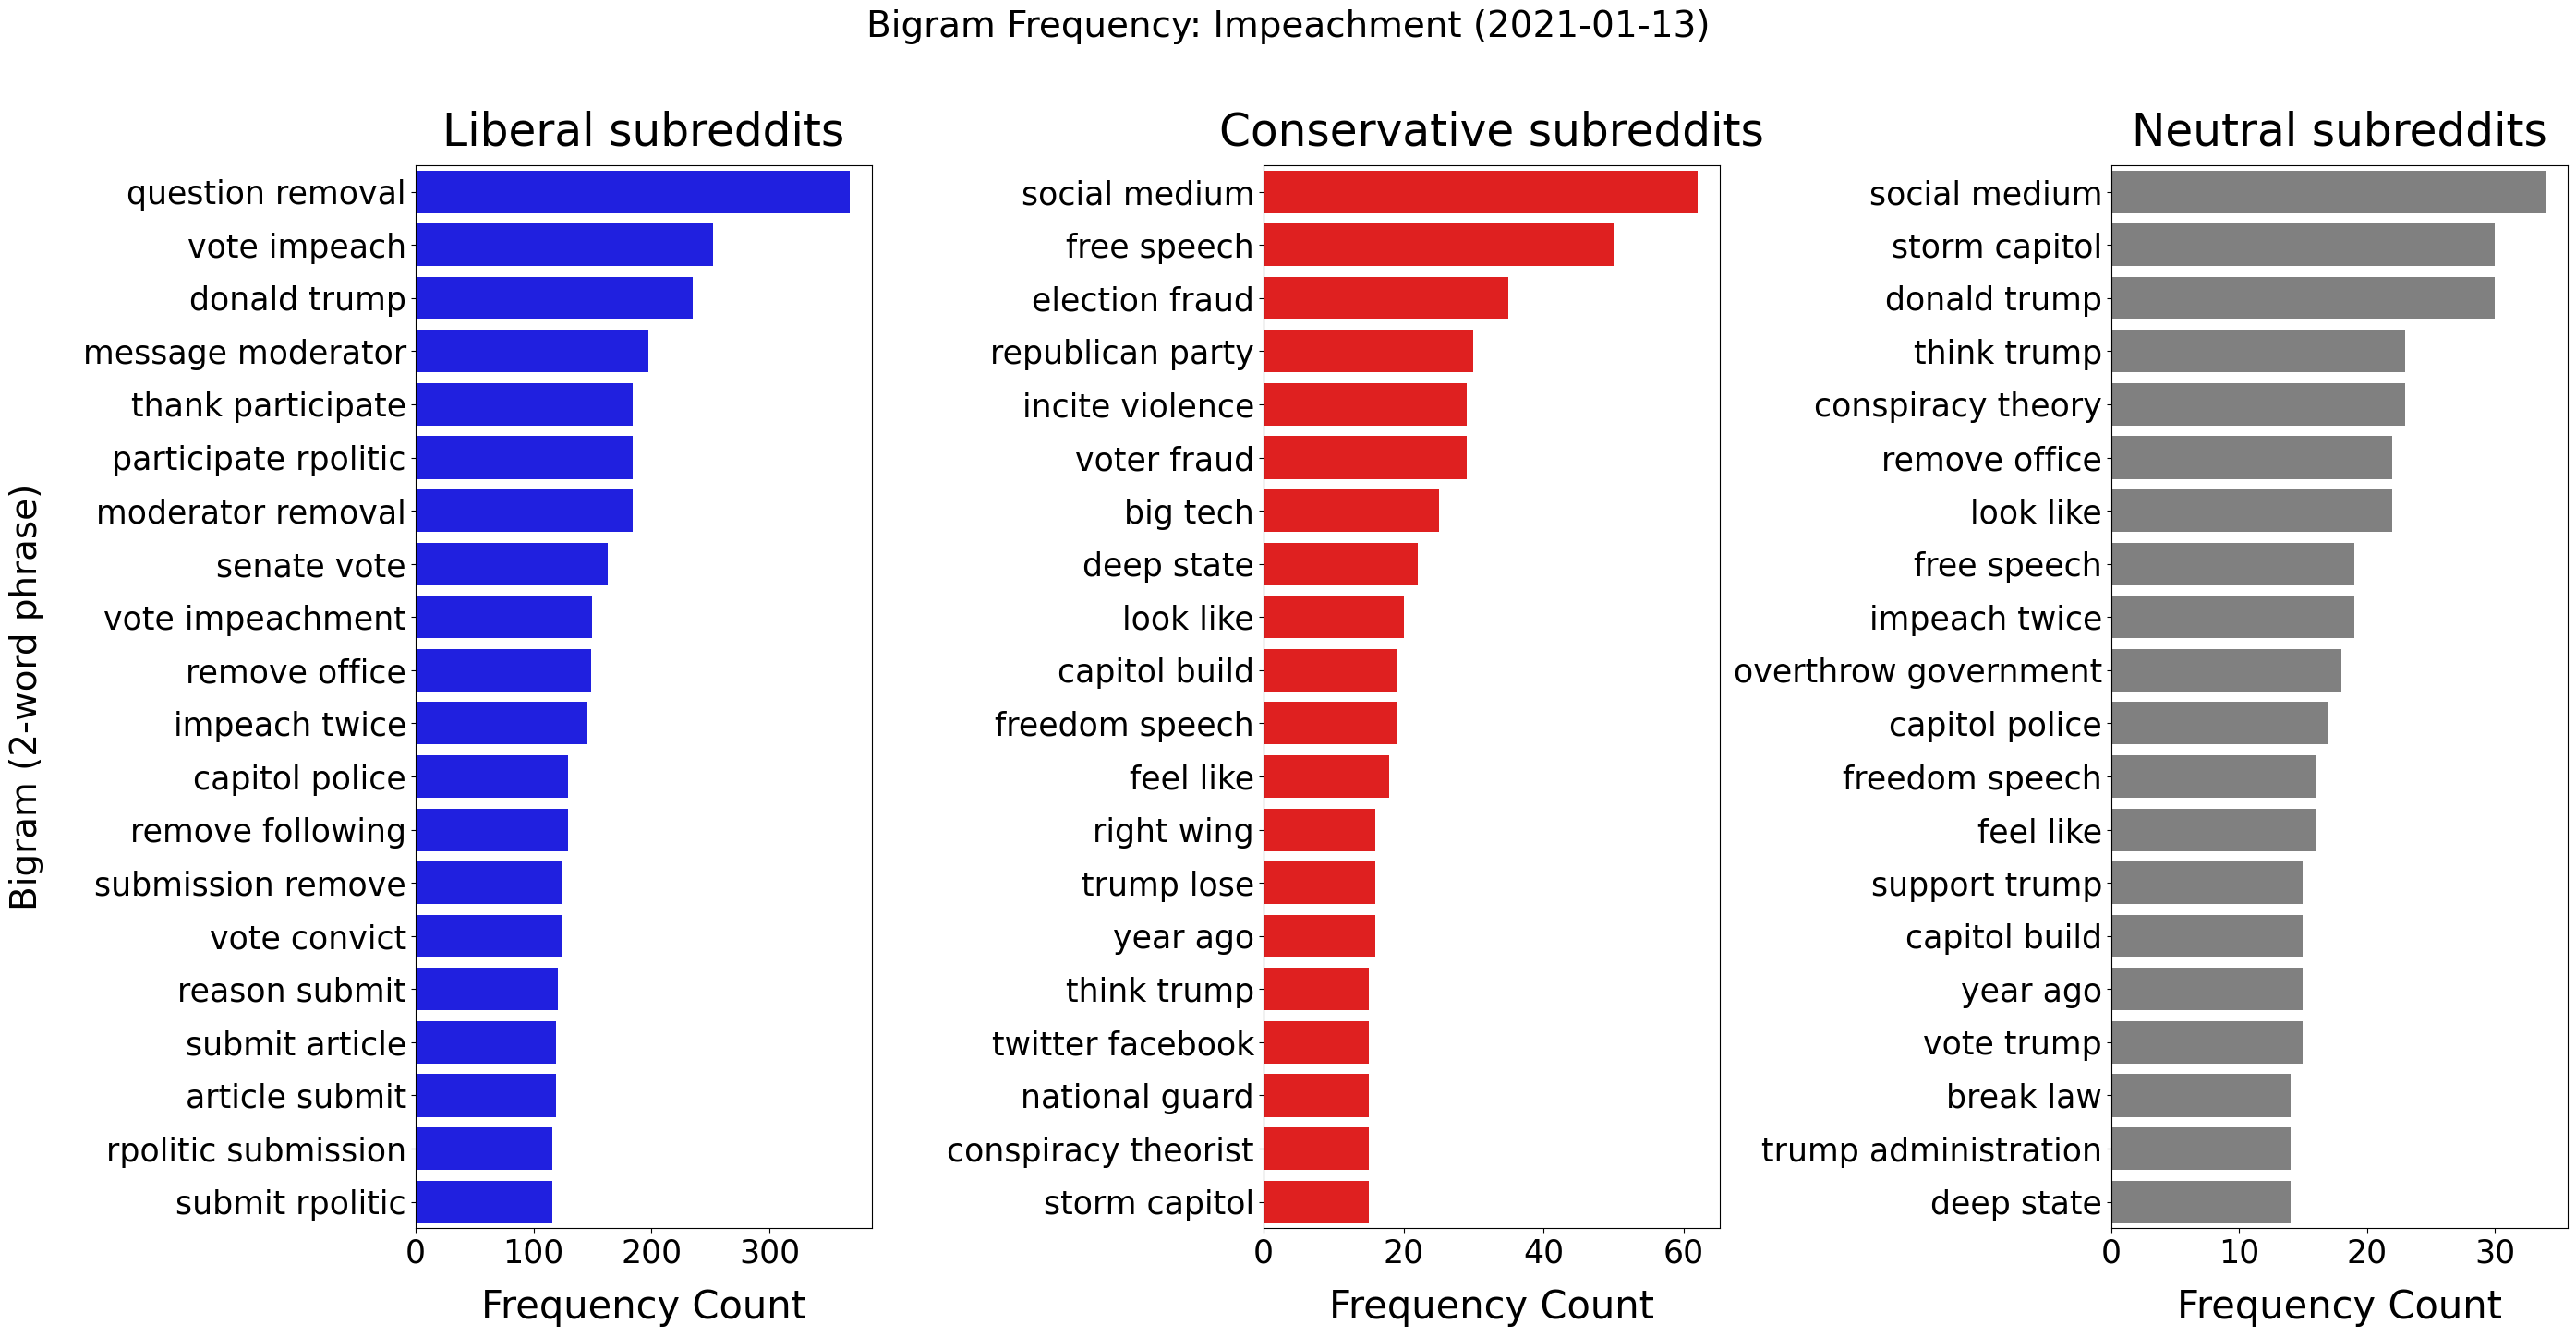

In [ ]:

print('\n' * 2)

for date_name, target_date in DATES.items():
    analyze_and_plot_comments_biagrams(df_coms, date_name, target_date, 'text_lemma')
    print('\n' * 2)

**The plots clearly visualize political polarization. All groups often discuss the same event, but the language they use reveals a completely different narrative.**

* Liberal Subreddits: The focus shifts from validating the election ("biden wins," "mail ballots") to reacting with a focus on institutional response during the attack ("capitol police," "25th amendment") and finally to establishing accountability ("impeached twice")

* Conservative Subreddits: A consistent counter-narrative is maintained. It begins with contesting the election ("voter fraud," "trump win"), shifts to alternative narratives during the attack ("conspiracy theory"), and reframes the impeachment as an issue of "free speech," effectively deflecting from the event itself

* Neutral Subreddits: This group serves as an observational baseline. The discussion is more procedural and descriptive ("electoral college," "capitol building") and frequently includes external references ("en wikipedia"), indicating a focus on factual citation rather than a strong partisan frame

In [ ]:
def analyze_and_plot_submissions_bigrams(df_subs, date_name, target_date, select_col):
    df_date_data = df_subs[df_subs['time_created'].dt.date == target_date].copy() # Filter submissions DF for the specific target date

    fig, axes = plt.subplots(1, 3, figsize=(28, 14)) # Create a figure with 3 subplots

    fig.suptitle(f'{date_name} ({target_date})', fontsize=28, y=1.03) # Set the main title for the entire figure

    COLOR_MAP = {'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'gray'}

    for i, (category, subreddits) in enumerate(SUBREDDIT_MAP.items()): # Loop through political categories defined in SUBREDDIT_MAP
        ax = axes[i]
        category_text = df_date_data[
            df_date_data['subreddit'].isin(subreddits)][select_col] # Select the text data for the current category's subreddits
        df_top_category = get_top_bigrams(category_text, n=100) # Get the top bigrams (up to 100 max)

        if not df_top_category.empty:
            df_top_category = df_top_category[~df_top_category['Bigram'].str.contains(UNWANTED_BIGRAMS, regex=True, case=False)].head(20) # Filter out predefined unwanted bigrams and keep the top 20

        if not df_top_category.empty:
            sns.barplot(data=df_top_category, x='Count', y='Bigram', ax=ax, color=COLOR_MAP[category]) # Create a bar plot
            ax.set_title(f'{category} subreddits', fontsize=35, pad=15)
        else:
            ax.text(0.5, 0.5, 'No valid bigrams found.', ha='center', va='center', fontsize=14, color='gray') # Handle case where no bigrams remain after filtering
            ax.set_title(f'{category} subreddits', fontsize=31)

        ax.set_xlabel('Frequency Count', fontsize=30, labelpad=15)
        ax.set_ylabel('Bigram (2-word phrase)' if i == 0 else '', fontsize=30, labelpad=15) # Set Y-axis label only for the first subplot
        ax.tick_params(axis='y', labelsize=25)
        ax.tick_params(axis='x', labelsize=25)

    plt.tight_layout()
    plt.show()

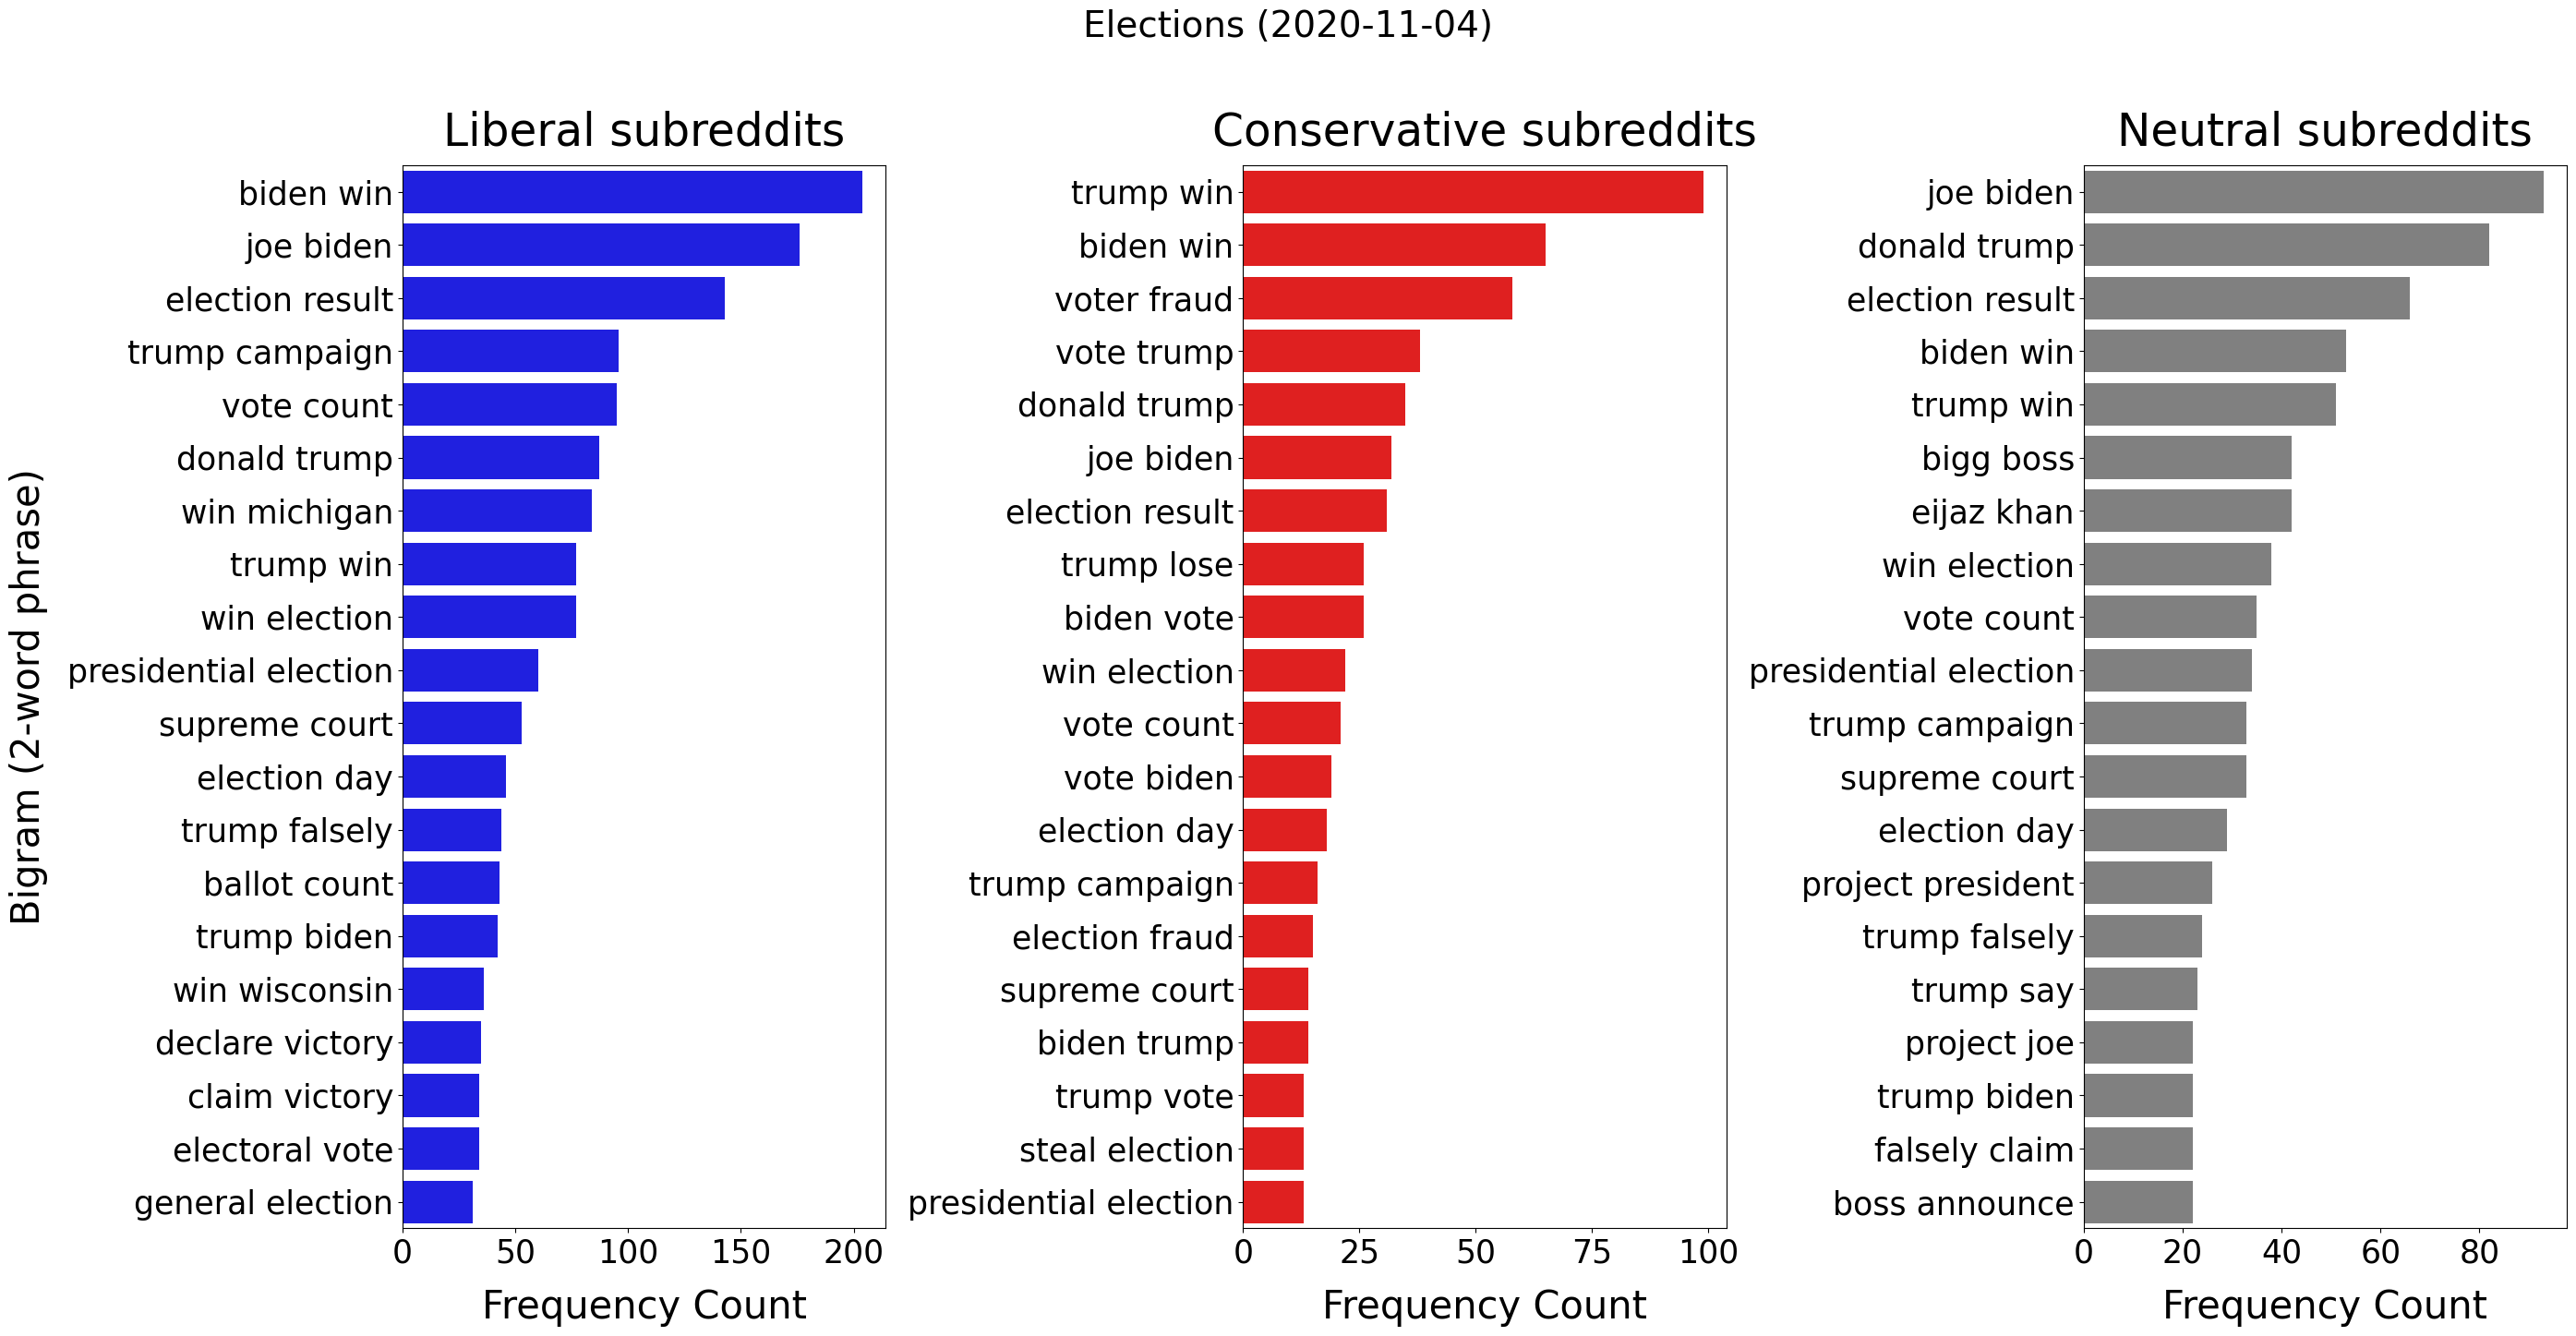

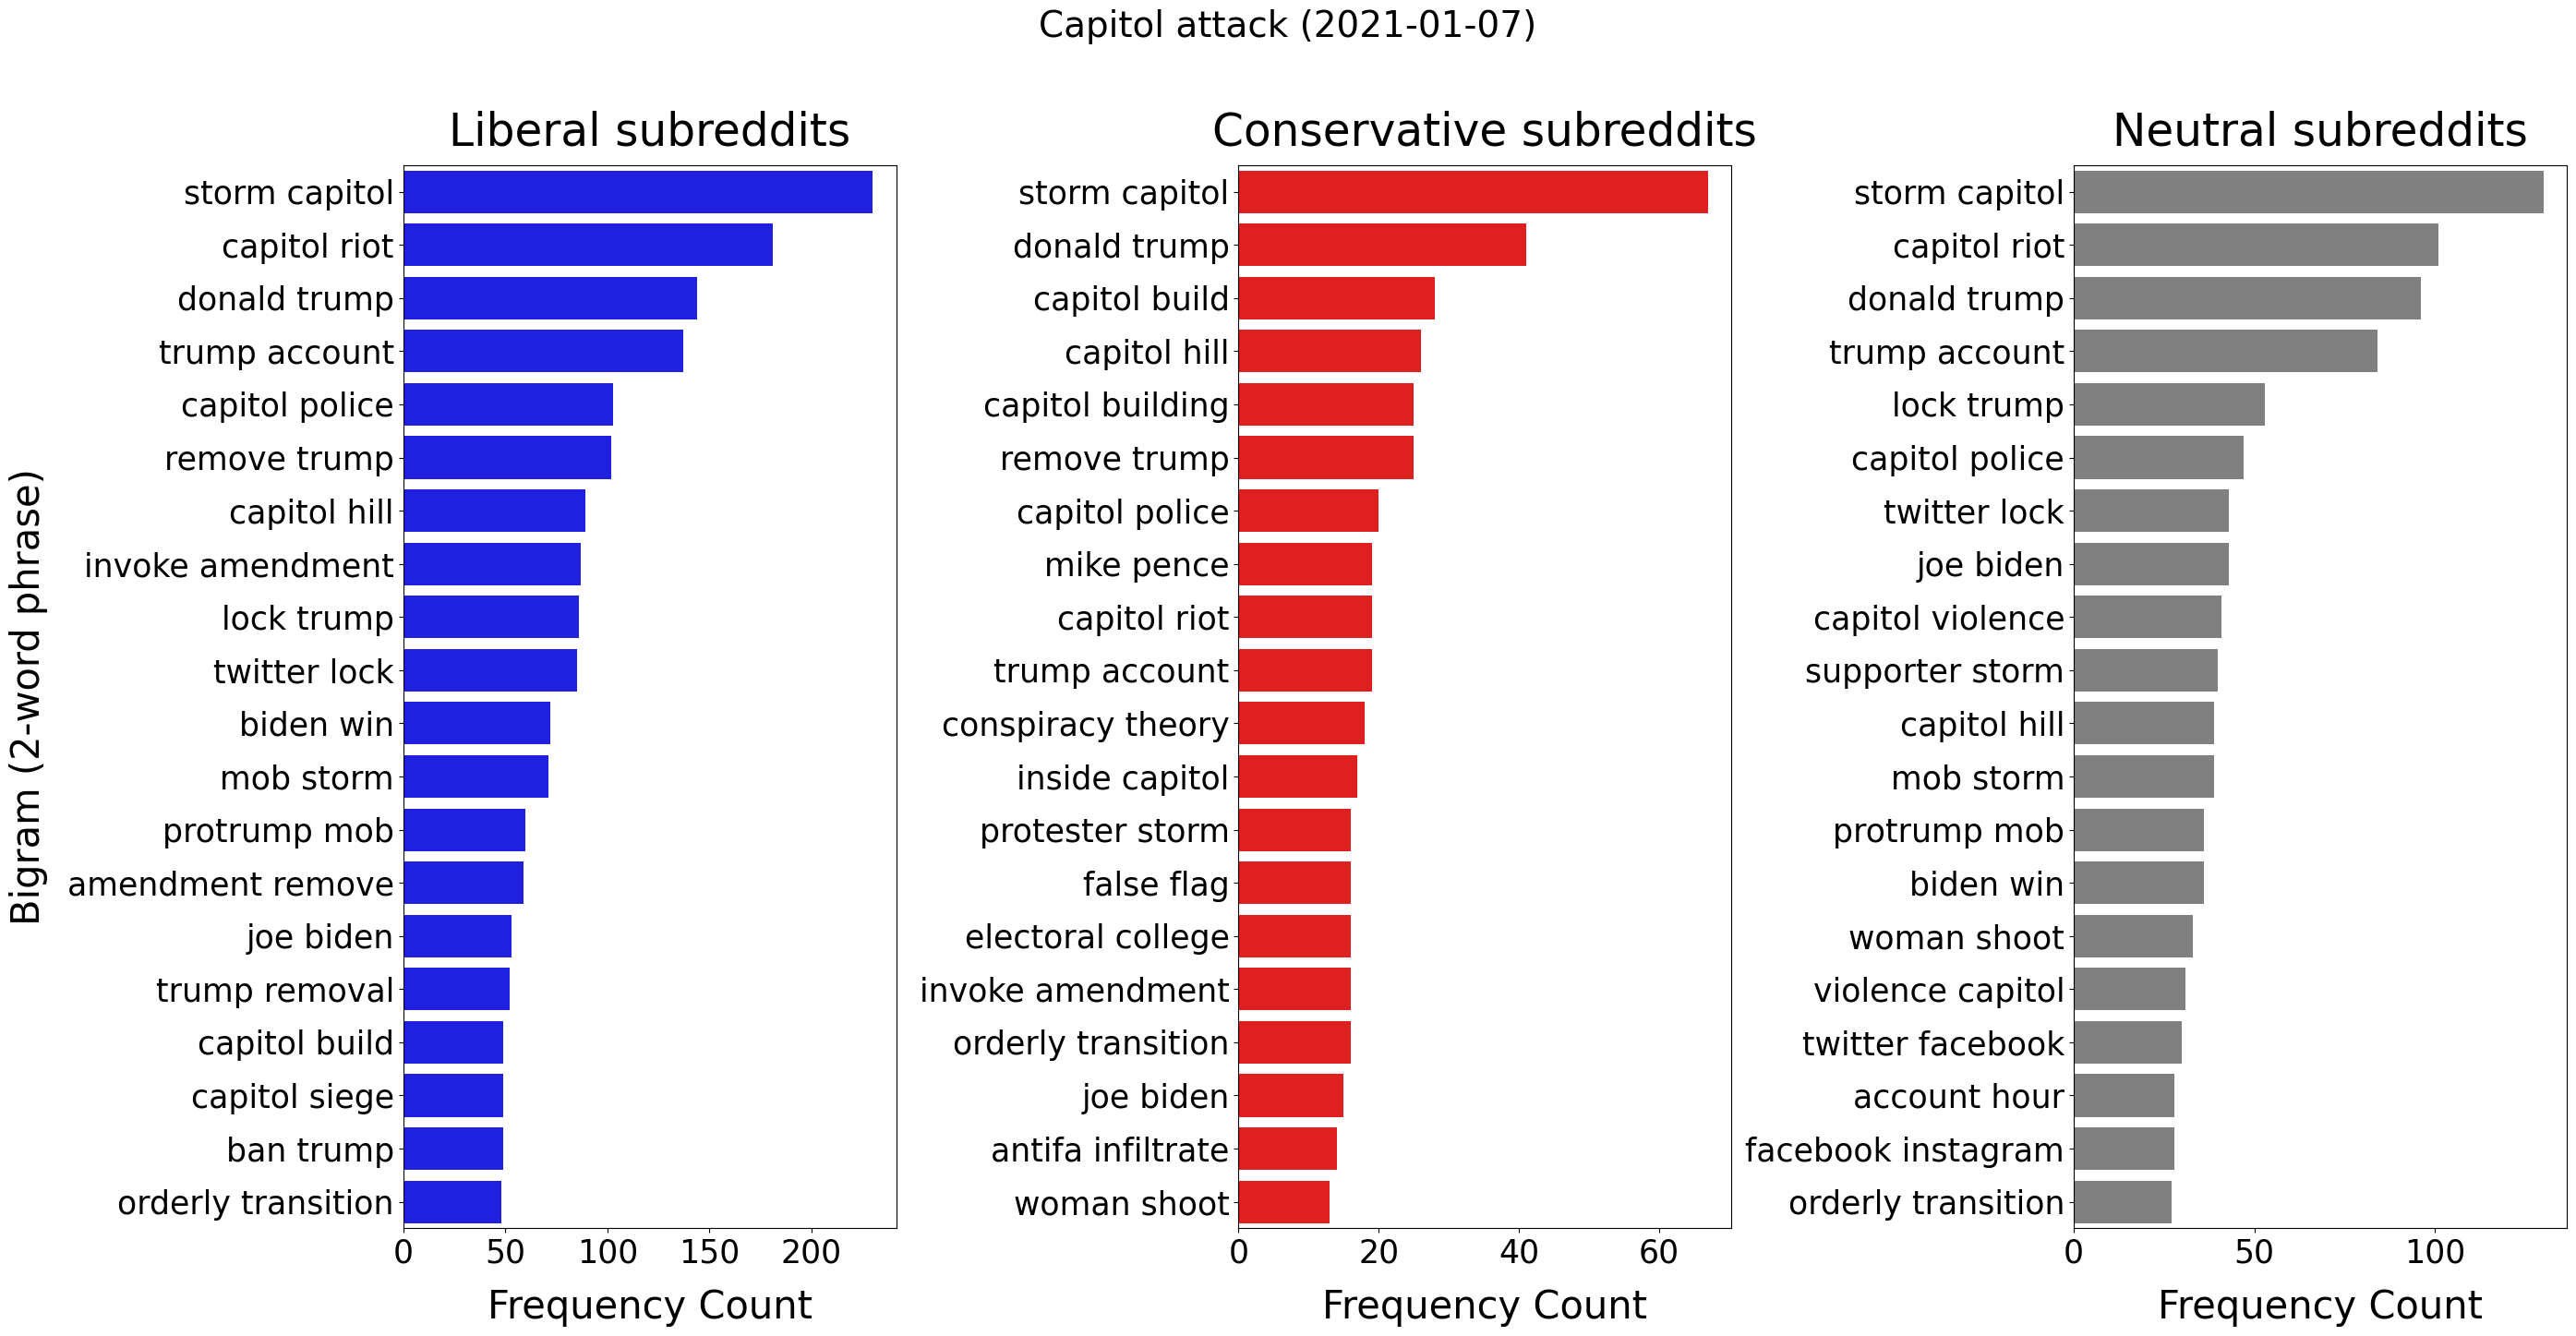

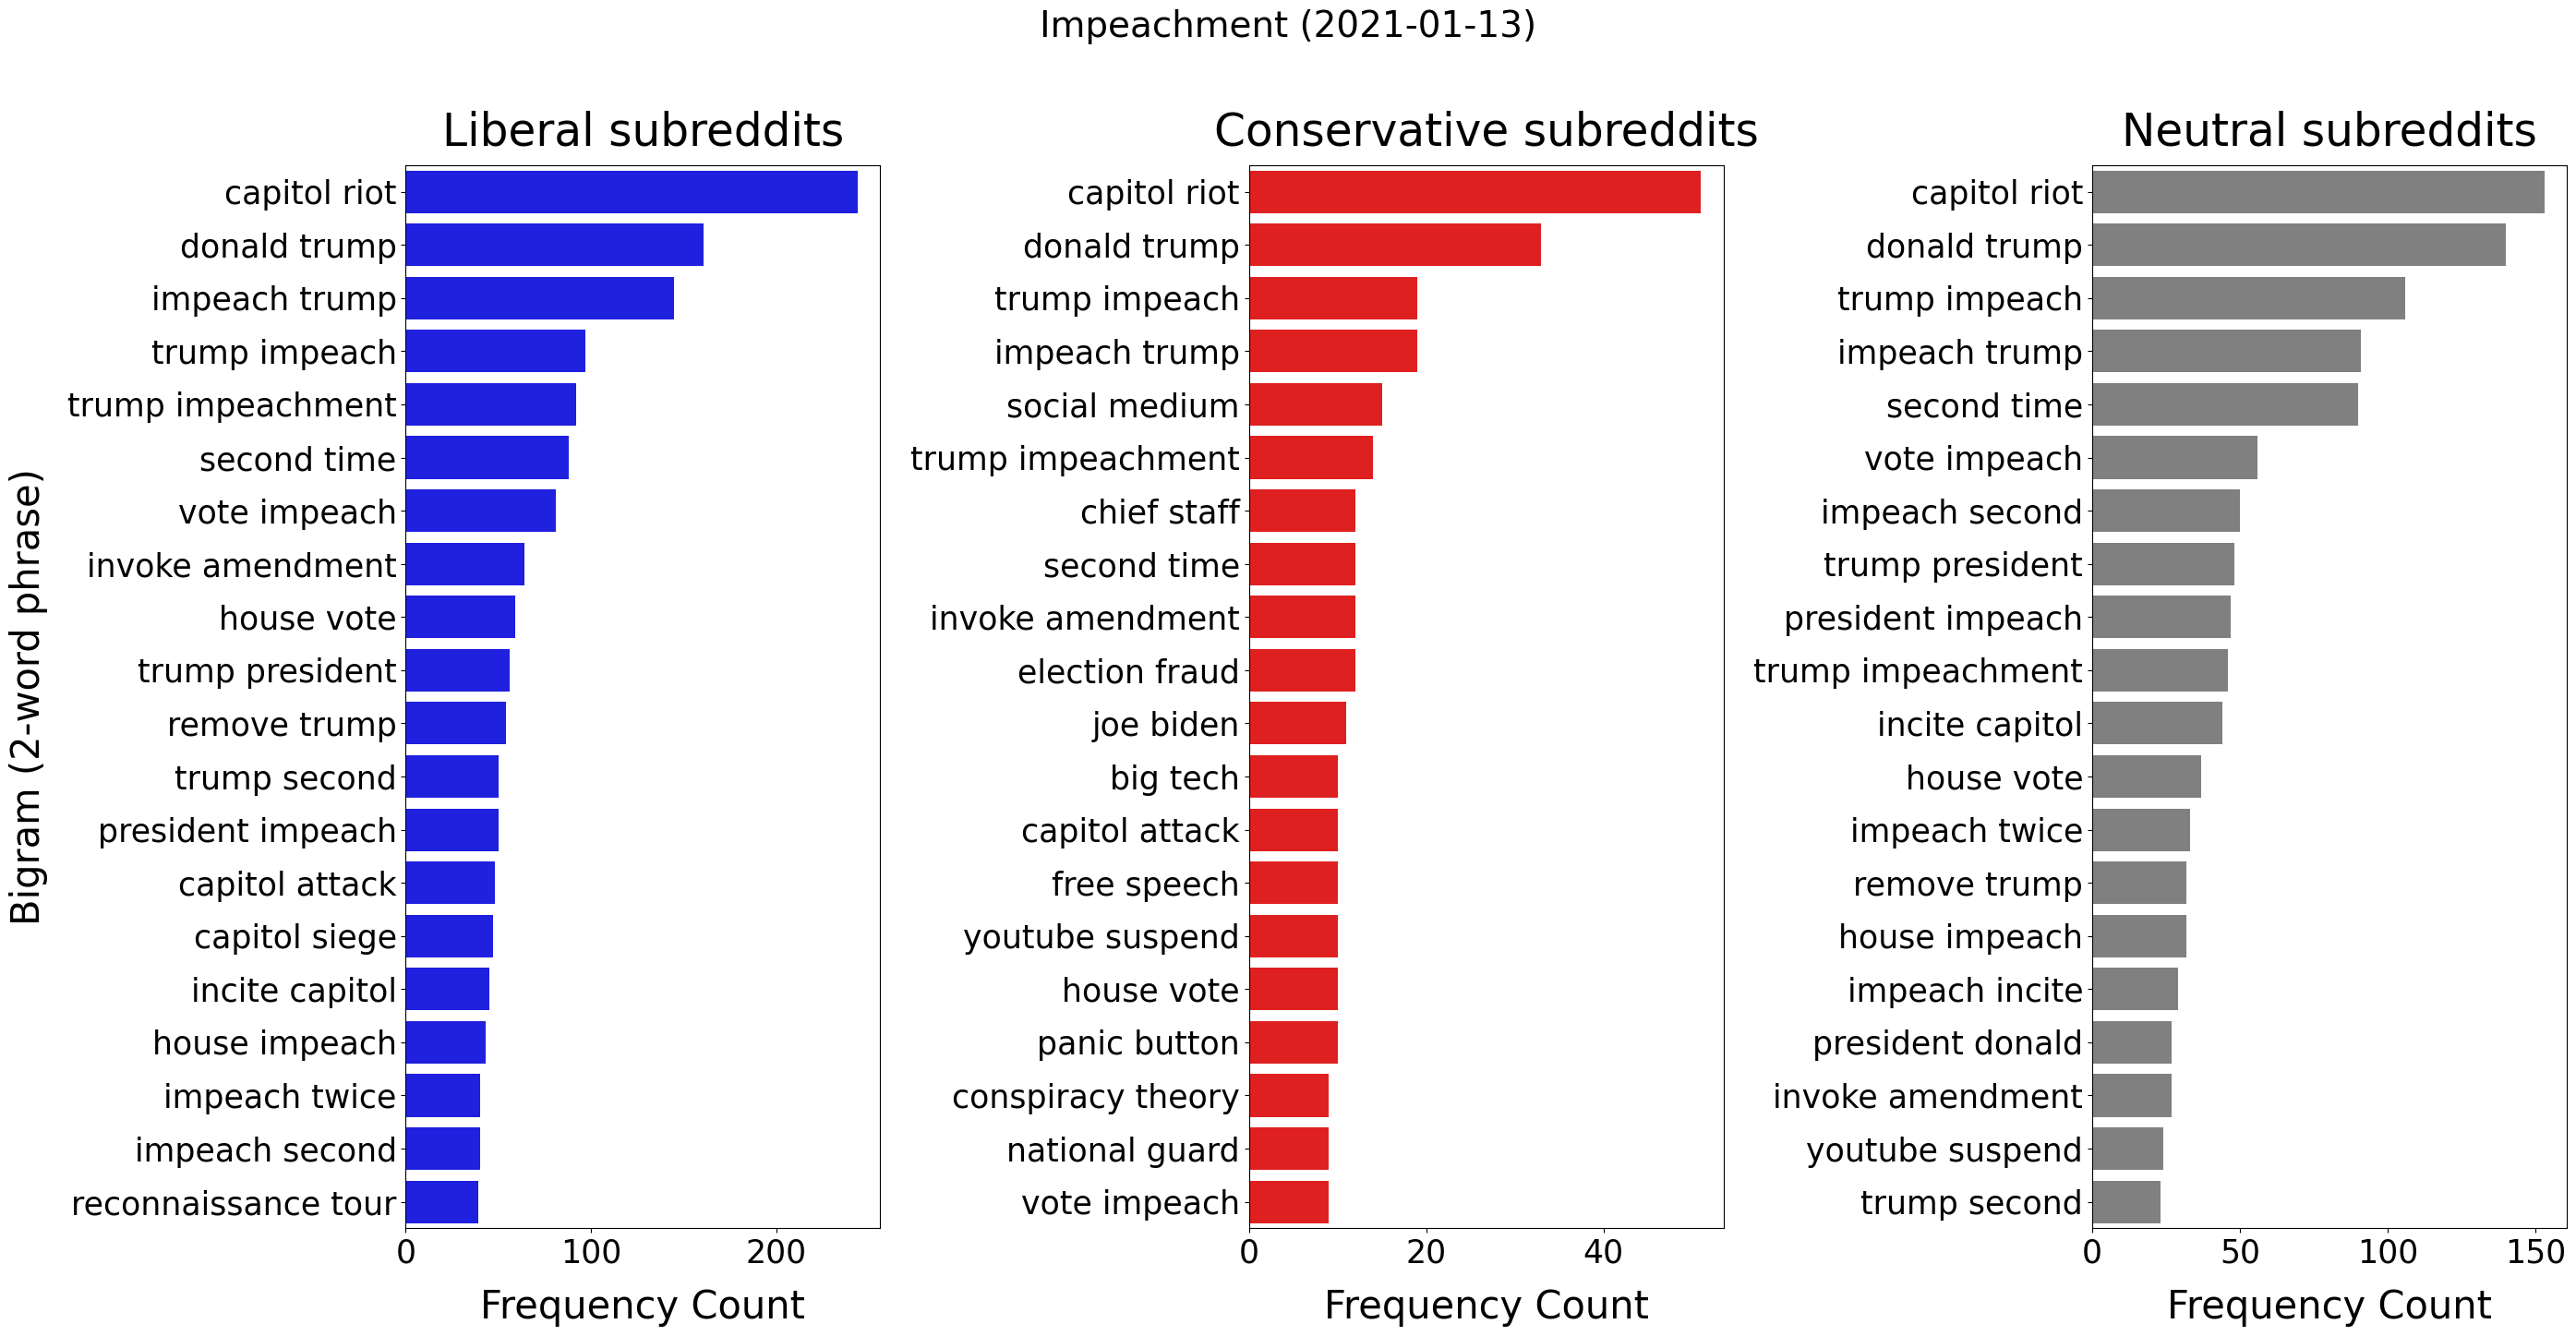

In [ ]:

print('\n' * 2)

for date_name, target_date in DATES.items():
    analyze_and_plot_submissions_bigrams(df_subs, date_name, target_date, 'title_lemma')
    print('\n' * 2)

**This analysis of the titles of submissions highlights a significant divergence in political narratives and how they developed over time**

* Liberal Subreddits: The focus shifts from validating the election ("biden wins," "joe biden") to calling for immediate political consequences during the attack ("25th amendment," "pro trump") and finally to establishing accountability ("capitol riot," "trump impeached").

* Conservative Subreddits: The narrative begins by contesting the election ("voter fraud," "trump win"). This shifts to a more descriptive focus on the event during the attack ("capitol building," "stormed capitol"), and finally converges on the central figure and event during the impeachment ("donald trump," "capitol riot").

* Neutral Subreddits: This group's titles consistently focus on the key individuals involved. The focus starts with "joe biden" and "donald trump" (Elections), narrows to "donald trump" and "pro trump" (Capitol Attack), and solidifies around "donald trump" and "capitol riot" (Impeachment).






**2. Sentiment analysis**

Here we are analyzing the sentiment of the content to answer the question of what emotional response different groups have to these events.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon') # Download the VADER lexicon (pre-trained sentiment dictionary) required by the analyzer
sid = SentimentIntensityAnalyzer() # Initialize the VADER Sentiment Intensity Analyzer

def analyze_sentiment(text):
    if pd.isna(text) or text is None:
        return 0.0 # Handle missing or null text values
    text = str(text)
    scores = sid.polarity_scores(text)
    return scores['compound'] # Return the compound score, which is a normalized, weighted average of all scores

def get_sentiment_label(compound_score): # Function to convert the numerical compound score into a categorical label
    if compound_score >= 0.05:
        return 'Positive' # Threshold for positive sentiment
    elif compound_score <= -0.05:
        return 'Negative' # Threshold for negative sentiment
    else:
        return 'Neutral' # Scores close to zero are neutral

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
events_date = [
    pd.to_datetime('2021-01-07').date(),
    pd.to_datetime('2020-11-04').date(),
    pd.to_datetime('2021-01-13').date()
]
df_subs_prepared = df_subs[df_subs['time_created'].dt.date.isin(events_date)].copy() # Filter the submissions DataFrame (df_subs) to keep only records on the defined event dates
df_coms_prepared = df_coms[df_coms['time_created'].dt.date.isin(events_date)].copy()

In [ ]:
import swifter

# Apply sentiment analysis (using the previously defined function) to the comments text using swifter for parallel processing
df_coms_prepared['sentiment_score'] = df_coms_prepared['text'].swifter.apply(analyze_sentiment)
# Convert the numerical score into a categorical label ('Positive', 'Negative', 'Neutral')
df_coms_prepared['sentiment_label'] = df_coms_prepared['sentiment_score'].swifter.apply(get_sentiment_label)

# Combine the submission title and body text into a single column
df_subs_prepared['combined_text'] = df_subs_prepared['title'] + ' ' + df_subs_prepared['selftext']
df_subs_prepared['sentiment_score'] = df_subs_prepared['combined_text'].swifter.apply(analyze_sentiment)
df_subs_prepared['sentiment_label'] = df_subs_prepared['sentiment_score'].swifter.apply(get_sentiment_label)

Pandas Apply:   0%|          | 0/443801 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/443801 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14730 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14730 [00:00<?, ?it/s]

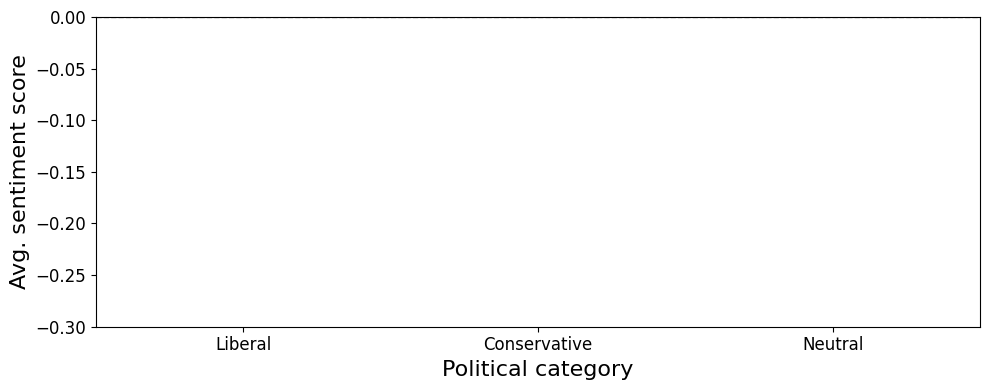

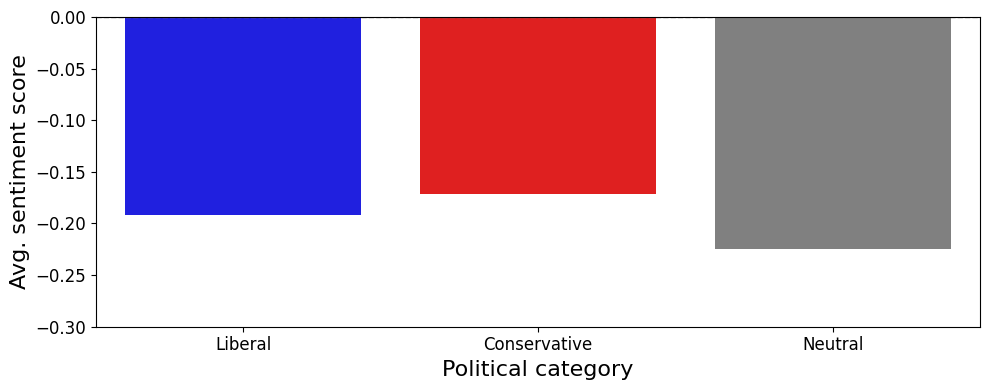

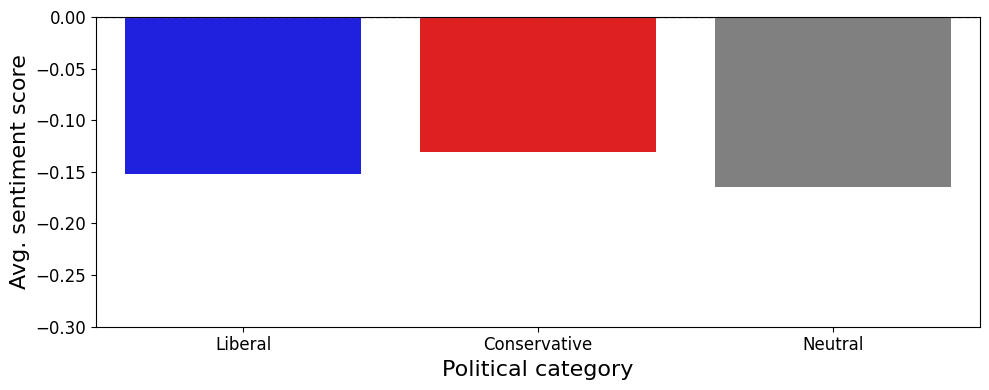

In [ ]:
def plot_average_sentiment(df, df_name, date_name, target_date):
    df_date_data = df[df['time_created'].dt.date == target_date].copy() # Filter DataFrame to include only records from the target date
    sentiment_results = {}
    for category, subreddits in SUBREDDIT_MAP.items(): # Loop through predefined subreddit categories
        df_cat = df_date_data[df_date_data['subreddit'].isin(subreddits)] # Filter data for the current category
        avg_sentiment = df_cat['sentiment_score'].mean() # Calculate the mean sentiment score for the category
        sentiment_results[category] = avg_sentiment

    df_sentiment_summary = pd.DataFrame(
        sentiment_results.items(),
        columns=['Category', 'Average Sentiment Score'] # Create a summary DataFrame of average scores
    )

    COLOR_MAP = {'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'grey'}

    fig, ax = plt.subplots(figsize=(10, 4))

    sns.barplot(data=df_sentiment_summary, x='Category', y='Average Sentiment Score',
                palette=[COLOR_MAP[cat] for cat in df_sentiment_summary['Category']],ax=ax) # Create a bar plot using category-specific colors

    plt.ylabel('Avg. sentiment score', fontsize=16)
    plt.xlabel('Political category', fontsize=16)
    plt.ylim(-0.3, 0) # Set a fixed Y-axis limit for consistent comparison

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Draw a horizontal line at y=0 (neutral sentiment)
    plt.tight_layout()
    plt.show()

for date_name, target_date in DATES.items(): # Loop through the dates defined in the DATES dictionary
    plot_average_sentiment(df_subs_prepared, "Submissions", date_name, target_date) # Call the plotting function for submissions
    print('\n' * 2)

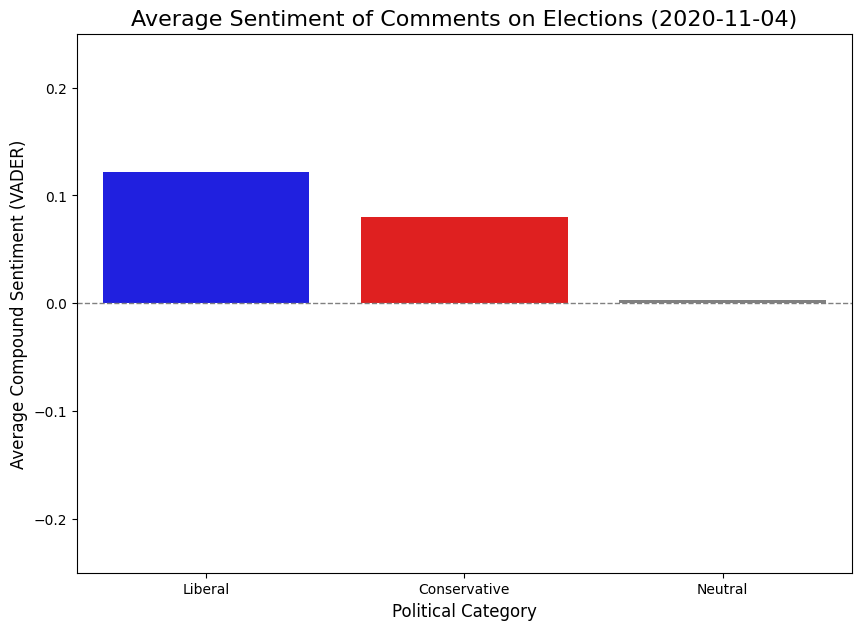

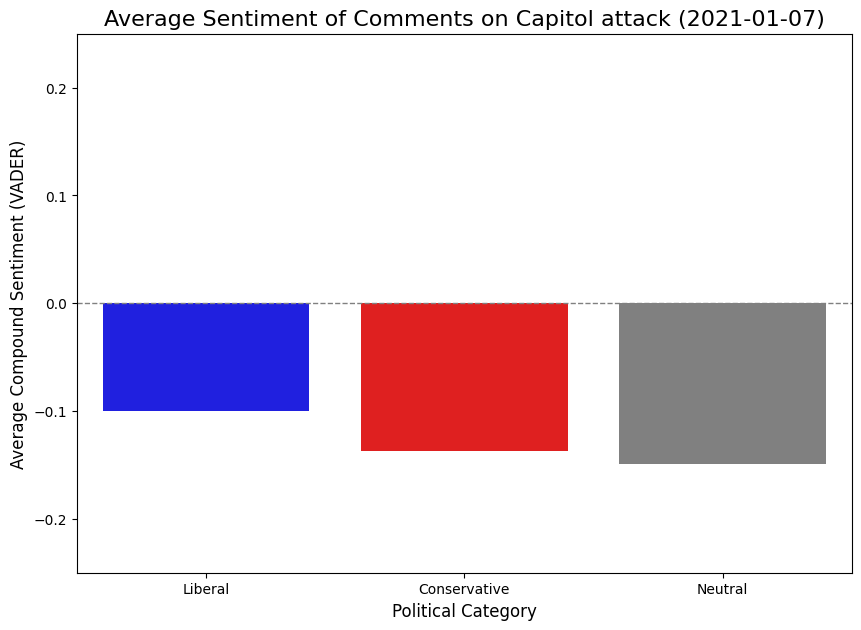

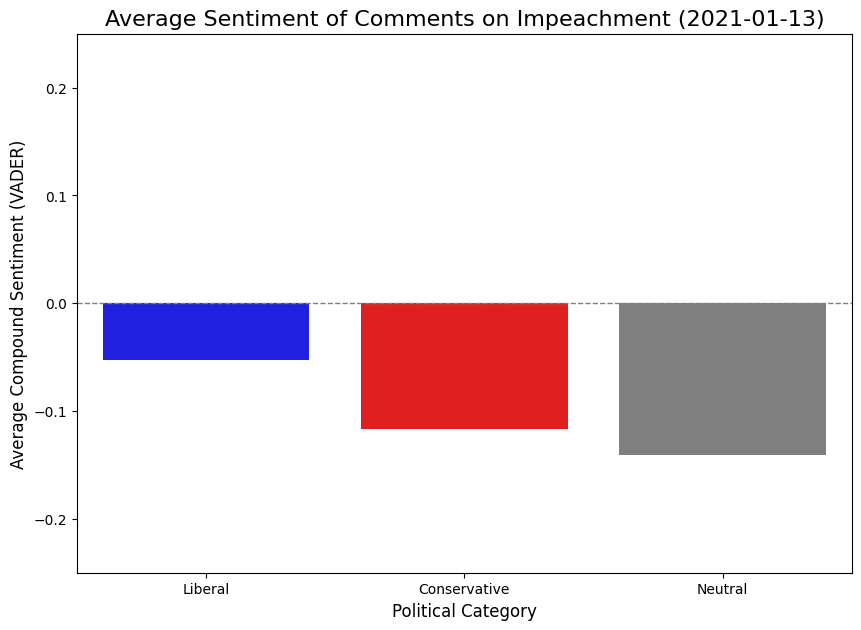

In [ ]:
for date_name, target_date in DATES.items():
    plot_average_sentiment(df_coms_prepared, "Comments", date_name, target_date)
    print('\n' * 2)

But we need more context to find what the sentiment was related to. We can get this by analyzing bigrams.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

def get_top_raw_bigrams(text_series, n=20):
    # Initialize CountVectorizer to extract bigrams, exclude English stop words, and limit feature count
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=1000)

    try:
        X = vectorizer.fit_transform(text_series.fillna(''))
        sum_words = X.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return pd.DataFrame(words_freq, columns=['Bigram', 'Count']).head(n) # Return top N bigrams
    except ValueError:
        return pd.DataFrame() # Return empty DataFrame on error

def analyze_and_plot_raw_bigram_sentiment(df, df_name, date_name, target_date, text_col):
    df_date_data = df[df['time_created'].dt.date == target_date].copy() # Filter data for the specific target date

    fig, axes = plt.subplots(1, 3, figsize=(28, 14))
    fig.suptitle(f'Raw Bigram Sentiment Analysis: {df_name} on {date_name} ({target_date})',
                    fontsize=28, y=1.03)

    COLOR_MAP = {'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'grey'}

    for i, (category, subreddits) in enumerate(SUBREDDIT_MAP.items()): # Iterate over political categories
        ax = axes[i]

        category_text_series = df_date_data[df_date_data['subreddit'].isin(subreddits)][text_col]

        df_top_bigrams = get_top_raw_bigrams(category_text_series, n=100) # Get the 100 most frequent raw bigrams

        if not df_top_bigrams.empty and 'UNWANTED_BIGRAMS' in globals():
            # Filter out unwanted bigrams if the global variable exists
            df_top_bigrams = df_top_bigrams[
                ~df_top_bigrams['Bigram'].str.contains(UNWANTED_BIGRAMS, regex=True, case=False)
            ].head

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

nltk.download('vader_lexicon') # Download the required VADER lexicon data
sid = SentimentIntensityAnalyzer() # Initialize the VADER sentiment analyzer

def get_vader_score(text):
    return sid.polarity_scores(str(text))['compound'] # Function to get the compound sentiment score from VADER

tqdm.pandas() # Enable tqdm progress bar integration for Pandas operations

df_coms['sentiment_score'] = df_coms['text'].progress_apply(get_vader_score) # Apply VADER sentiment analysis to the 'text' column of comments DataFrame

if 'combined_text' in df_subs.columns:
    col_to_use = 'combined_text'
else:
    # If 'combined_text' does not exist, create it by concatenating 'title' and 'selftext' (handling NaNs)
    df_subs['combined_text'] = df_subs['title'].fillna('') + ' ' + df_subs['selftext'].fillna('')
    col_to_use = 'combined_text'

df_subs['sentiment_score'] = df_subs[col_to_use].progress_apply(get_vader_score) # Apply VADER sentiment analysis to the submissions DataFrame using the chosen text column

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/5917521 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for date_name, target_date in DATES.items():
    analyze_and_plot_raw_bigram_sentiment(
        df_coms,
        "Comments",
        date_name,
        target_date,
        text_col='text'
    )
    print('\n' * 2)

**Sentiment Conclusions: Comments**



**Elections (2020-11-04)**

* Liberal Group: Main sentiment was Positive (High). This was driven by phrases like "biden wins," "mail ballots," and "joe biden". The pattern was Affirmation of Outcome.

* Conservative Group: Sentiment was Positive (Low). It was conflicted, influenced positively by "trump winning" and "trump win," but negatively by "voter fraud". The pattern was Conflicted Hope.

* Neutral Group: Sentiment was Neutral. Key phrases included "electoral college," "popular vote," and "en wikipedia". The pattern was Factual Observation

**Capitol Attack (2021-01-07)**

* Liberal Group: Main sentiment was Negative (Medium). Drivers included "25th amendment," "capitol police," and "law enforcement". The pattern was institutional outrage.

* Conservative Group: Sentiment was Negative (High). It was driven by strong negative emotion around "election fraud," "conspiracy theories," and "deep state". The pattern was conspiracy driven deflection.

* Neutral Group: Sentiment was Negative (Medium). Key phrases were "storming capitol," "capitol building," and "mike pence". The pattern was event solemnity.

**Impeachment (2021-01-13)**

* Liberal Group: Main sentiment was Negative (Medium). The focus was on accountability using terms like "impeached twice," "vote convict," and "senate trial". The pattern was accountability demand.

* Conservative Group: Sentiment was Negative (High). The narrative shifted to defense using strongly negative-associated terms like "free speech" and "big tech". The pattern was ideological reframing.

* Neutral Group: Sentiment was Negative (Low). Key terms included "donald trump," "impeached twice," and procedural references. The pattern was focusing on reporting the political process.


In [ ]:
df_subs['combined_text'] = df_subs['title'].fillna('') + ' ' + df_subs['selftext'].fillna('')

for date_name, target_date in DATES.items():
    analyze_and_plot_raw_bigram_sentiment(
        df_subs,
        "Submissions",
        date_name,
        target_date,
        text_col='combined_text'
    )
    print('\n' * 2)

**Sentiment Conclusions: Submissions**

**Elections (2020-11-04)**

* Liberal Group: Sentiment was Positive (High). Submissions emphasized "biden wins" and "joe biden". The pattern was Declarative Victory.

* Conservative Group: Sentiment was Negative (Medium). Submissions focused on "voter fraud" and "election fraud". The pattern was protest of legitimacy.

* Neutral Group: Sentiment was Neutral (Low Pos). Submissions focused on "joe biden" and "donald trump". The pattern was focus on the person.

**Capitol Attack (2021-01-07)**

* Liberal Group: Sentiment was Negative (High). Submissions demanded action, using "25th amendment" and "remove trump". The pattern was demand for consequence.

* Conservative Group: Sentiment was Negative (High). Submissions were descriptive: "capitol building" and "stormed capitol". The pattern was event description.

* Neutral Group: Sentiment was Negative (Medium). Submissions focused on "donald trump" and "capitol riot". The pattern was factual summary.

**Impeachment (2021-01-13)**

* Liberal Group: Sentiment was Negative (High). Submissions confirmed the process: "trump impeached" and "house impeaches". The pattern was Finalizing Accountability.

* Conservative Group: Sentiment was Negative (Medium). Submissions defended against the narrative using "big tech" and "free speech". The pattern was defense of principle.

* Neutral Group: Sentiment was Negative (Low). Submissions confirmed the event: "donald trump" and "capitol riot". The pattern was confirmation of process.

**3.Topics**

After we made bigrams, analyzed them, we will analyze topics using LDA algorithm which will give us particular groups of words.

In [ ]:

import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gc

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
DATE_RANGES = {
    'Capitol attack': ('2021-01-07', '2021-01-07'),
    'Election': ('2020-11-03', '2020-11-03'),
    'Impechment': ('2021-01-13', '2021-01-13'),
    }

LDA_PARAMS = {
    'coms': {'num_topics': 10, 'no_below': 150, 'no_above': 0.2, 'passes': 10}, # Parameters for LDA model on comments: 10 topics, min 150 document frequency, max 20% document frequency
    'subs': {'num_topics': 10, 'no_below': 10, 'no_above': 0.5, 'passes': 10}
}

lemmatizer = WordNetLemmatizer()
custom_stopwords = set(stopwords.words('english'))
unwanted_words_list = UNWANTED_BIGRAMS.replace('|', ' ').split()
custom_stopwords.update(unwanted_words_list)
# Add a list of custom stop words and common noise words found in social media/Reddit data
custom_stopwords.update(['amp', 'x200b', 'gt', 'lt', 'https', 'www', 'com',
                             'reddit', 'politics', 'submission', 'article',
                             'removed', 'deleted', 'wa', 'ha', 'would', 'could',
                             'one', 'use', 'like', 'just', 'get', 'say', 'think'])

def preprocess_text(text):
    tokens = [word.lower() for word in gensim.utils.simple_preprocess(str(text)) if word not in string.punctuation] # Tokenize and convert to lowercase, remove punctuation
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) >= 3] # Remove custom stop words and tokens shorter than 3 characters
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Reduce words to their base form (lemma)
    return tokens

def run_lda_model(dataframe, text_column, num_topics, no_below, no_above, passes):
    texts_to_analyze = dataframe[text_column].fillna('')
    processed_data = [preprocess_text(doc) for doc in texts_to_analyze] # Apply preprocessing to all documents
    processed_data = [doc for doc in processed_data if len(doc) > 0] # Remove empty documents


    id2word = corpora.Dictionary(processed_data) # Create a vocabulary mapping IDs to words
    id2word.filter_extremes(no_below=no_below, no_above=no_above) # Filter out words that are too rare or too common
    corpus = [id2word.doc2bow(text) for text in processed_data] # Convert processed documents into a Bag-of-Words (BoW) format

    print(len(corpus)) # Print the number of documents remaining
    print(len(id2word)) # Print the size of the vocabulary

    # Run the LDA topic modeling algorithm using multiple cores for speed
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=passes)

    topics = lda_model.print_topics(num_words=10) # Get the top 10 words for each topic
    for topic_id, topic_words in topics:
        print(f"{topic_id}: {topic_words}")

    return lda_model, corpus

def filter_data_by_period(df, period_name):
    start_date_str, end_date_str = DATE_RANGES[period_name] # Get start and end dates from the DATE_RANGES dictionary
    start_date = pd.to_datetime(start_date_str).date()
    end_date = pd.to_datetime(end_date_str).date()

    # Filter the DataFrame based on the 'time_created' column falling within the defined date range
    df_filtered = df[
        (df['time_created'].dt.date >= start_date) &
        (df['time_created'].dt.date <= end_date)
    ].copy()

    return df_filtered

NameError: name 'WordNetLemmatizer' is not defined

In [ ]:
print("--- Topics for comments: ---")
for event, (start, end) in tqdm(DATE_RANGES.items(), desc="Comment processing"):
    print(f"\n Event: {event} ({start} - {end})")
    df_coms_filtered = filter_data_by_period(df_coms, event)
    run_lda_model(df_coms_filtered, 'text_lemma', **LDA_PARAMS['coms'])

print("\n\n--- Topics for submissions: ---")
for event, (start, end) in tqdm(DATE_RANGES.items(), desc="Submissions processing"):
    print(f"\n Event: {event} ({start} - {end})")
    df_subs_filtered = filter_data_by_period(df_subs, event)
    run_lda_model(df_subs_filtered, 'combined_lemma', **LDA_PARAMS['subs'])


--- Topics for comments: ---


Обробка коментарів:   0%|          | 0/3 [00:00<?, ?it/s]


 Event: Capitol attack (2021-01-07 - 2021-01-07)
19748
391
0: 0.132*"capitol" + 0.067*"police" + 0.036*"storm" + 0.031*"protest" + 0.030*"building" + 0.020*"blm" + 0.015*"riot" + 0.015*"security" + 0.014*"build" + 0.013*"capital"
1: 0.055*"traitor" + 0.040*"die" + 0.040*"charge" + 0.037*"man" + 0.036*"crime" + 0.033*"steal" + 0.033*"life" + 0.029*"woman" + 0.029*"death" + 0.028*"arrest"
2: 0.072*"republican" + 0.039*"party" + 0.039*"support" + 0.035*"year" + 0.028*"gop" + 0.026*"democrat" + 0.023*"vote" + 0.022*"power" + 0.021*"lose" + 0.020*"need"
3: 0.084*"remove" + 0.051*"action" + 0.048*"account" + 0.047*"rule" + 0.043*"rpolitic" + 0.039*"break" + 0.037*"moderator" + 0.036*"source" + 0.035*"follow" + 0.034*"report"
4: 0.051*"look" + 0.047*"time" + 0.033*"ban" + 0.028*"probably" + 0.028*"make" + 0.026*"antifa" + 0.022*"evidence" + 0.021*"actually" + 0.020*"hear" + 0.017*"theory"
5: 0.046*"thing" + 0.033*"sure" + 0.031*"bad" + 0.023*"good" + 0.021*"country" + 0.021*"pretty" + 0.018*

Обробка постів:   0%|          | 0/3 [00:00<?, ?it/s]


 Event: Capitol attack (2021-01-07 - 2021-01-07)
6127
983
0: 0.087*"capitol" + 0.030*"woman" + 0.026*"shoot" + 0.020*"storm" + 0.018*"event" + 0.018*"support" + 0.017*"protest" + 0.015*"riot" + 0.015*"come" + 0.015*"assault"
1: 0.062*"capitol" + 0.047*"biden" + 0.043*"violence" + 0.034*"mob" + 0.034*"incite" + 0.032*"condemn" + 0.026*"leader" + 0.021*"live" + 0.021*"protrump" + 0.021*"fbi"
2: 0.084*"account" + 0.053*"lock" + 0.050*"violence" + 0.041*"capitol" + 0.040*"facebook" + 0.039*"ban" + 0.037*"suspend" + 0.035*"donald" + 0.029*"hour" + 0.023*"indefinitely"
3: 0.093*"facebook" + 0.071*"ban" + 0.044*"instagram" + 0.036*"indefinitely" + 0.031*"arrest" + 0.029*"block" + 0.025*"issue" + 0.024*"attempt" + 0.022*"warrant" + 0.020*"world"
4: 0.191*"capitol" + 0.045*"police" + 0.042*"riot" + 0.039*"storm" + 0.035*"rioter" + 0.033*"protrump" + 0.031*"mob" + 0.022*"follow" + 0.021*"steal" + 0.019*"hill"
5: 0.123*"capitol" + 0.040*"mob" + 0.029*"antifa" + 0.029*"attack" + 0.028*"democracy"

Now let's make plots about output topics with matched words

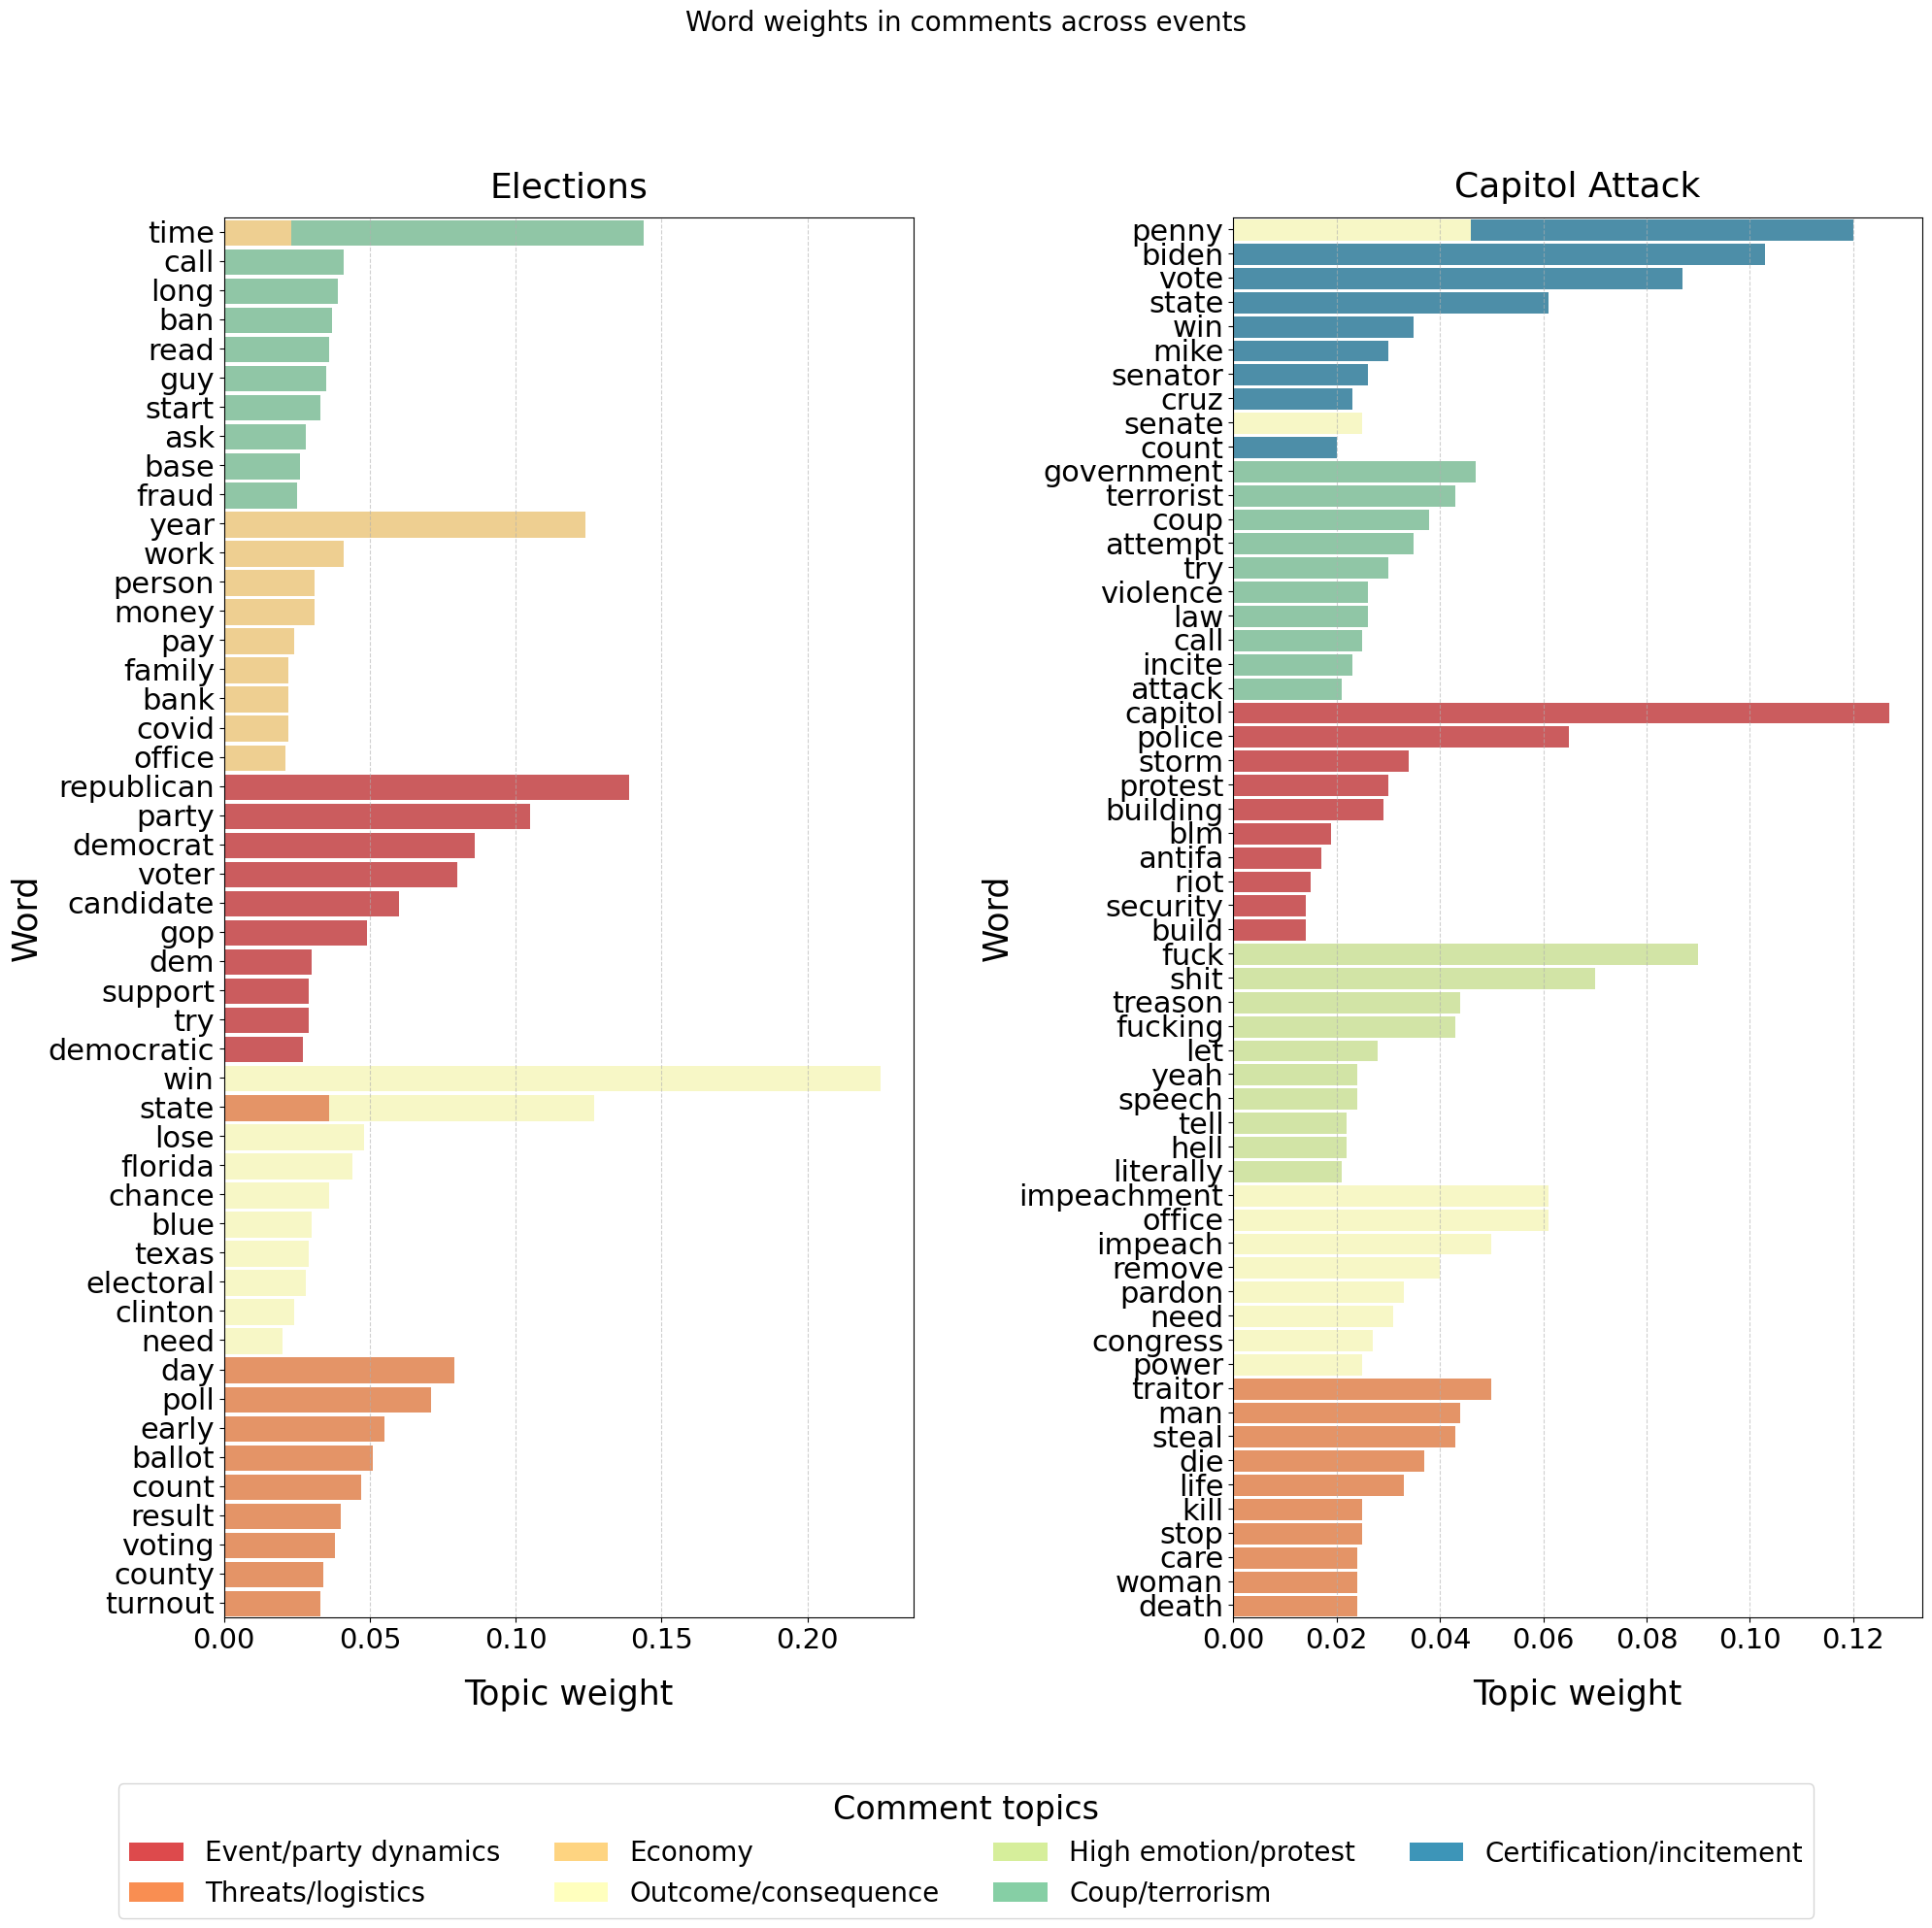

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ALL_LDA_OUTPUT = { # Dictionary containing LDA results (topic ID and word weights) for two major events

    'Elections': {
        'date': '2020-11-03',
        'output': {
            0: '0.139*"republican" + 0.105*"party" + 0.086*"democrat" + 0.080*"voter" + 0.060*"candidate" + 0.049*"gop" + 0.030*"dem" + 0.029*"support" + 0.029*"try" + 0.027*"democratic"',
            1: '0.079*"day" + 0.071*"poll" + 0.055*"early" + 0.051*"ballot" + 0.047*"count" + 0.040*"result" + 0.038*"voting" + 0.036*"state" + 0.034*"county" + 0.033*"turnout"',
            3: '0.124*"year" + 0.041*"work" + 0.031*"person" + 0.031*"money" + 0.024*"pay" + 0.023*"time" + 0.022*"family" + 0.022*"bank" + 0.022*"covid" + 0.021*"office"',
            6: '0.225*"win" + 0.127*"state" + 0.048*"lose" + 0.044*"florida" + 0.036*"chance" + 0.030*"blue" + 0.029*"texas" + 0.028*"electoral" + 0.024*"clinton" + 0.020*"need"',
            8: '0.144*"time" + 0.041*"call" + 0.039*"long" + 0.037*"ban" + 0.036*"read" + 0.035*"guy" + 0.033*"start" + 0.028*"ask" + 0.026*"base" + 0.025*"fraud"'
        }
    },
    'Capitol Attack': {
        'date': '2021-01-07',
        'output': {
            0: '0.127*"capitol" + 0.065*"police" + 0.034*"storm" + 0.030*"protest" + 0.029*"building" + 0.019*"blm" + 0.017*"antifa" + 0.015*"riot" + 0.014*"security" + 0.014*"build"',
            1: '0.050*"traitor" + 0.044*"man" + 0.043*"steal" + 0.037*"die" + 0.033*"life" + 0.025*"kill" + 0.025*"stop" + 0.024*"care" + 0.024*"woman" + 0.024*"death"',
            6: '0.061*"impeachment" + 0.061*"office" + 0.050*"impeach" + 0.046*"penny" + 0.040*"remove" + 0.033*"pardon" + 0.031*"need" + 0.027*"congress" + 0.025*"senate" + 0.025*"power"',
            7: '0.090*"fuck" + 0.070*"shit" + 0.044*"treason" + 0.043*"fucking" + 0.028*"let" + 0.024*"yeah" + 0.024*"speech" + 0.022*"tell" + 0.022*"hell" + 0.021*"literally"',
            8: '0.047*"government" + 0.043*"terrorist" + 0.038*"coup" + 0.035*"attempt" + 0.030*"try" + 0.026*"violence" + 0.026*"law" + 0.025*"call" + 0.023*"incite" + 0.021*"attack"',
            9: '0.120*"penny" + 0.103*"biden" + 0.087*"vote" + 0.061*"state" + 0.035*"win" + 0.030*"mike" + 0.026*"senator" + 0.023*"cruz" + 0.020*"senate" + 0.020*"count"'
        }
    }

}


TOPIC_BASE_NAMES = { # Mapping of topic IDs to descriptive base names
    0: 'Event/party dynamics',
    1: 'Threats/logistics',
    3: 'Economy',
    6: 'Outcome/consequence',
    7: 'High emotion/protest',
    8: 'Coup/terrorism',
    9: 'Certification/incitement'
}

FULL_BASE_TOPICS_LIST = list(TOPIC_BASE_NAMES.values()) # List of all possible base topic names

def create_legend_handles(base_names, color_palette_name='Spectral'):
    base_colors = sns.color_palette(color_palette_name, len(base_names))
    handles = []
    labels = []
    for i, name in enumerate(base_names):
        handle = plt.Rectangle((0, 0), 1, 1, fc=base_colors[i], edgecolor='none') # Create dummy rectangles for the legend
        handles.append(handle)
        labels.append(name)

    return handles, labels, base_colors

def parse_lda_data_with_event_prefix(lda_output_dict, event_name):
    plotting_data = []
    if event_name == 'Capitol Attack': # Define which topic IDs are relevant for each event
        relevant_ids = [0, 1, 6, 7, 8, 9]

    elif event_name == 'Elections':
        relevant_ids = [0, 1, 3, 6, 8]

    else:
        return pd.DataFrame()

    for topic_id, words_string in lda_output_dict['output'].items():
        if topic_id in relevant_ids:
            base_name = TOPIC_BASE_NAMES.get(topic_id, f"Topic {topic_id}")
            full_topic_name = f'{event_name}: {base_name}' # Create full topic name (Event: Base Name)

            parts = words_string.split(' + ') # Split the Gensim output string by '+'
            for part in parts:
                if '*' in part:
                    weight, word = part.split('*') # Separate the word weight and the word
                    plotting_data.append({ # Store data in list of dictionaries
                        'Event': event_name,
                        'Topic_Name': full_topic_name,
                        'Base_Name': base_name,
                        'Word': word.replace('"', ''),
                        'Weight': float(weight)
                    })
    return pd.DataFrame(plotting_data) # Convert list of dictionaries to DataFrame

all_data_frames = []
for event_name, event_data in ALL_LDA_OUTPUT.items():
    df = parse_lda_data_with_event_prefix(event_data, event_name) # Process data for each event
    all_data_frames.append(df)

df_all_events = pd.concat(all_data_frames, ignore_index=True) # Combine all event data into one DataFrame

handles, labels, base_colors_list = create_legend_handles(FULL_BASE_TOPICS_LIST) # Get color mapping setup

base_topic_to_color = {name: base_colors_list[i % len(base_colors_list)] for i, name in enumerate(FULL_BASE_TOPICS_LIST)} # Map base topic names to their colors
final_color_map = {}
for full_name in df_all_events['Topic_Name'].unique():
    base_name = full_name.split(': ')[1]
    final_color_map[full_name] = base_topic_to_color[base_name] # Map full topic names to colors based on their base name

fig, axes = plt.subplots(1, 2, figsize=(20, 18), sharex=False, sharey=False) # Create subplots for two events
fig.suptitle('Word weights in comments across events', fontsize=20, y=1.01)

for i, event_name in enumerate(ALL_LDA_OUTPUT.keys()):
    ax = axes[i]
    df_event = df_all_events[df_all_events['Event'] == event_name].copy() # Filter data for the current event

    df_event_sorted = df_event.sort_values(by=['Topic_Name', 'Weight'], ascending=[True, False]) # Sort data for correct plotting order

    sns.barplot(
        data=df_event_sorted,
        x='Weight',
        y='Word',
        hue='Topic_Name', # Use the full topic name for internal hue separation
        dodge=False, # Disable dodging to stack/overlap bars
        ax=ax,
        palette=final_color_map, # Use the custom color map
        order=df_event_sorted['Word'].unique(), # Ensure words are plotted in the sorted order
    )
    for patch in ax.patches:
        current_height = patch.get_height()
        patch.set_height(current_height * 1.1) # Slightly increase bar height to prevent stacking issues

    ax.set_title(f'{event_name}', fontsize=26, pad=15)
    ax.set_xlabel('Topic weight', fontsize=25, labelpad=18)
    ax.set_ylabel('Word', fontsize=25)
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=21)

    if i == 1: # Custom legend generation for the second subplot
        current_handles, current_labels = ax.get_legend_handles_labels()

        legend_labels = []
        legend_handles = []

        sorted_labels = sorted(final_color_map.keys())

        for name in FULL_BASE_TOPICS_LIST: # Recreate simplified legend using base names and base colors
            base_color = base_topic_to_color[name]
            full_names_list = [l for l in current_labels if name in l]

            if full_names_list:
                legend_handles.append(plt.Rectangle((0, 0), 1, 1, fc=base_color, edgecolor='none'))
                legend_labels.append(name)

        fig.legend(handles=handles,
                   labels=labels,
                   title="Comment topics",
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.09),
                   ncol=4,
                   fontsize=20,
                   title_fontsize=24
                   )

        ax.legend([], [], frameon=False) # Hide the default legend on the subplot

    else:
        ax.legend([], [], frameon=False)

    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=5)
plt.subplots_adjust(bottom=0.09)
plt.show()

**Topic Modeling Conclusions: Comments**

**Elections (2020-11-03)**
* Dominant Theme: The primary focus was on the logistics of voting and the immediate results as they were being reported.
* Key Topic Words: vote, day, ballot, voting, result, poll and win, florida, texas, winning.
* Pattern: Real-time Event Tracking.

**Capitol Attack (2021-01-07)**
* Dominant Theme: The discussion was a chaotic mix of immediate accountability, defining the event, and assigning blame.
* Key Topic Words: penny, impeachment, amendment, capitol, terrorist, coup, antifa and treason, traitor, crime.
* Pattern: Crisis Response & Accountability Demand.

**Impeachment (2021-01-13)**
* Dominant Theme: The focus shifted to the formal political process and its historical significance.
* Key Topic Words: impeachment, senate, vote, trial, convict, mcconnell and impeached, twice, first, history.
* Pattern: Formalizing the Consequence.

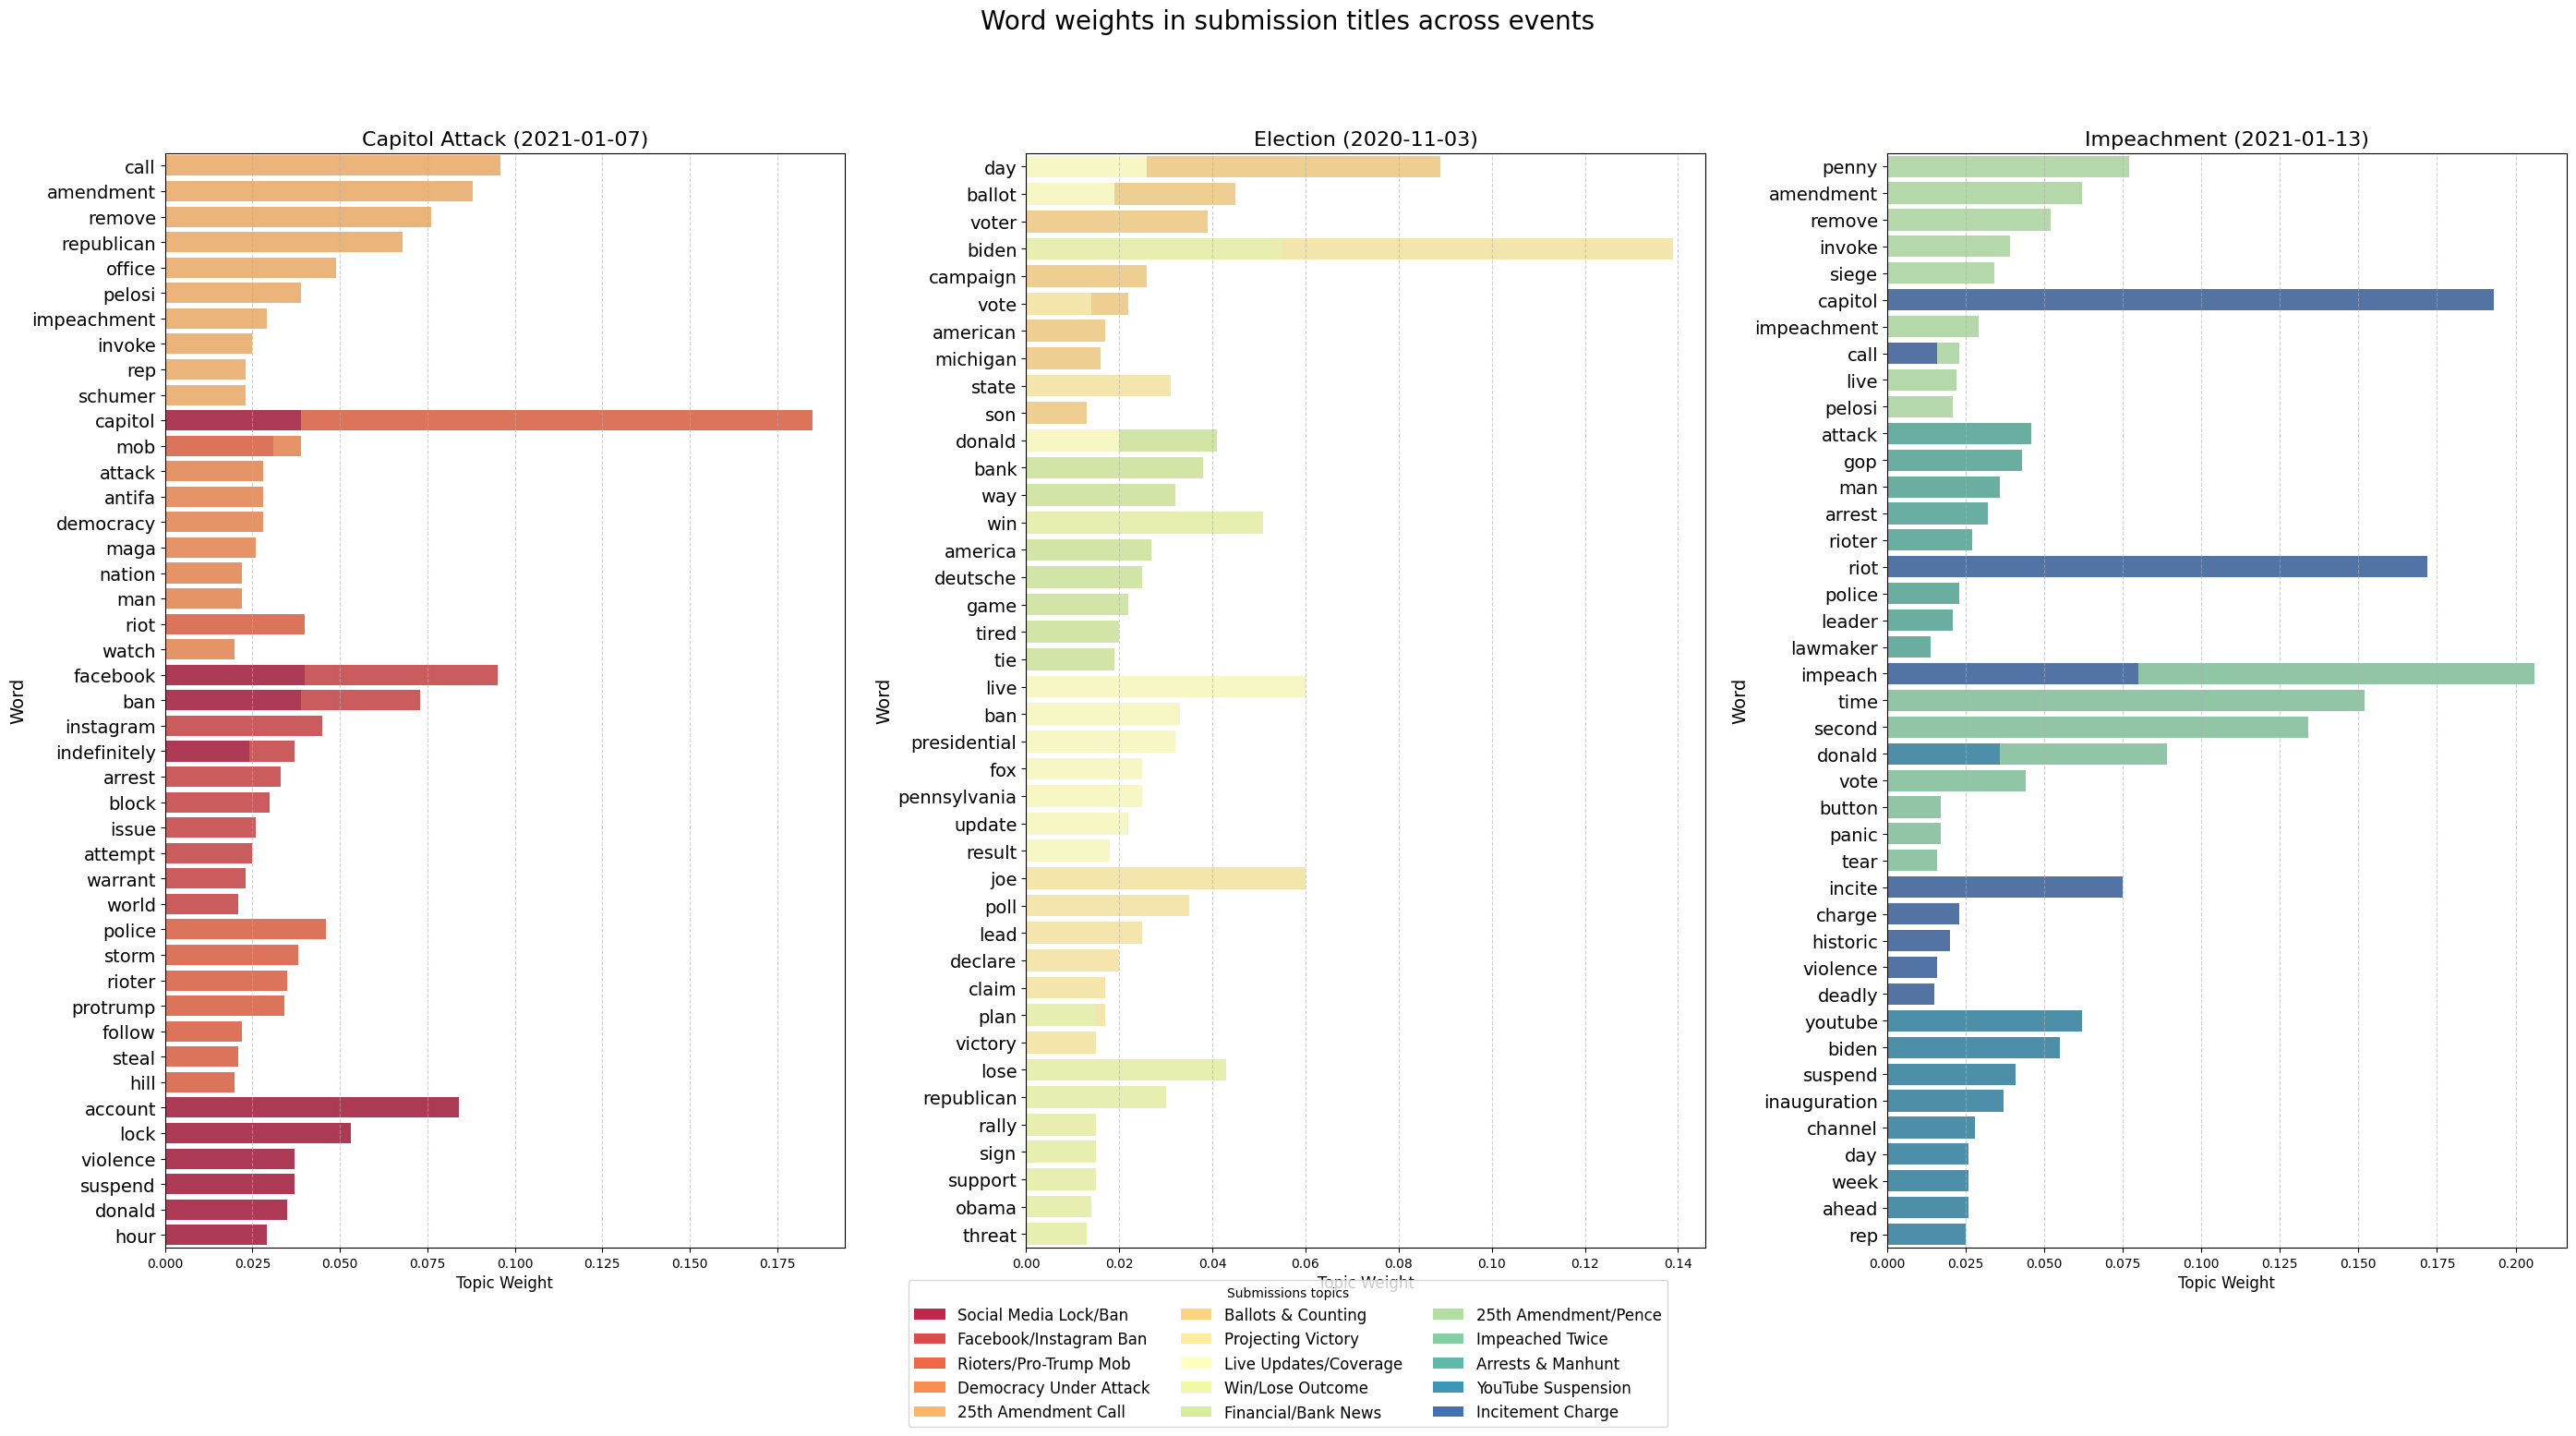

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Dictionary containing LDA topic results (Topic ID: Word Weights) for Reddit Submissions across three events
SUBMISSIONS_LDA_OUTPUT = {
    'Capitol Attack': {
        'date': '2021-01-07',
        'output': {
            2: '0.084*"account" + 0.053*"lock" + 0.040*"facebook" + 0.039*"capitol" + 0.039*"ban" + 0.037*"violence" + 0.037*"suspend" + 0.035*"donald" + 0.029*"hour" + 0.024*"indefinitely"',
            3: '0.095*"facebook" + 0.073*"ban" + 0.045*"instagram" + 0.037*"indefinitely" + 0.033*"arrest" + 0.030*"block" + 0.026*"issue" + 0.025*"attempt" + 0.023*"warrant" + 0.021*"world"',
            4: '0.185*"capitol" + 0.046*"police" + 0.040*"riot" + 0.038*"storm" + 0.035*"rioter" + 0.034*"protrump" + 0.031*"mob" + 0.022*"follow" + 0.021*"steal" + 0.020*"hill"',
            5: '0.125*"capitol" + 0.039*"mob" + 0.028*"attack" + 0.028*"antifa" + 0.028*"democracy" + 0.026*"maga" + 0.022*"nation" + 0.022*"man" + 0.022*"riot" + 0.020*"watch"',
            9: '0.096*"call" + 0.088*"amendment" + 0.076*"remove" + 0.068*"republican" + 0.049*"office" + 0.039*"pelosi" + 0.029*"impeachment" + 0.025*"invoke" + 0.023*"rep" + 0.023*"schumer"'
        }
    },
    'Election': {
        'date': '2020-11-03',
        'output': {
            1: '0.089*"day" + 0.045*"ballot" + 0.039*"voter" + 0.036*"biden" + 0.026*"campaign" + 0.022*"vote" + 0.017*"american" + 0.016*"michigan" + 0.016*"state" + 0.013*"son"',
            3: '0.139*"biden" + 0.060*"joe" + 0.035*"poll" + 0.031*"state" + 0.025*"lead" + 0.020*"declare" + 0.017*"claim" + 0.017*"plan" + 0.015*"victory" + 0.014*"vote"',
            4: '0.060*"live" + 0.033*"ban" + 0.032*"presidential" + 0.026*"day" + 0.025*"fox" + 0.025*"pennsylvania" + 0.022*"update" + 0.020*"donald" + 0.019*"ballot" + 0.018*"result"',
            6: '0.055*"biden" + 0.051*"win" + 0.043*"lose" + 0.030*"republican" + 0.015*"plan" + 0.015*"rally" + 0.015*"sign" + 0.015*"support" + 0.014*"obama" + 0.013*"threat"',
            9: '0.046*"biden" + 0.041*"donald" + 0.038*"bank" + 0.032*"way" + 0.031*"win" + 0.027*"america" + 0.025*"deutsche" + 0.022*"game" + 0.020*"tired" + 0.019*"tie"'
        }
    },
    'Impeachment': {
        'date': '2021-01-13',
        'output': {
            0: '0.077*"penny" + 0.062*"amendment" + 0.052*"remove" + 0.039*"invoke" + 0.034*"siege" + 0.033*"capitol" + 0.029*"impeachment" + 0.023*"call" + 0.022*"live" + 0.021*"pelosi"',
            3: '0.206*"impeach" + 0.152*"time" + 0.134*"second" + 0.089*"donald" + 0.044*"vote" + 0.033*"capitol" + 0.023*"riot" + 0.017*"button" + 0.017*"panic" + 0.016*"tear"',
            5: '0.121*"capitol" + 0.046*"attack" + 0.043*"gop" + 0.036*"man" + 0.032*"arrest" + 0.027*"rioter" + 0.024*"riot" + 0.023*"police" + 0.021*"leader" + 0.014*"lawmaker"',
            6: '0.062*"youtube" + 0.055*"biden" + 0.041*"suspend" + 0.037*"inauguration" + 0.036*"donald" + 0.028*"channel" + 0.026*"day" + 0.026*"week" + 0.026*"ahead" + 0.025*"rep"',
            8: '0.193*"capitol" + 0.172*"riot" + 0.080*"impeach" + 0.075*"incite" + 0.023*"charge" + 0.020*"historic" + 0.018*"donald" + 0.016*"violence" + 0.016*"call" + 0.015*"deadly"'
        }
    }
}

# List of all descriptive base topic names used for submissions across all events
SUBMISSIONS_FULL_BASE_TOPICS_LIST = [
    # Capitol
    'Social Media Lock/Ban', 'Facebook/Instagram Ban', 'Rioters/Pro-Trump Mob',
    'Democracy Under Attack', '25th Amendment Call',
    # Election
    'Ballots & Counting', 'Projecting Victory', 'Live Updates/Coverage',
    'Win/Lose Outcome', 'Financial/Bank News',
    # Impeachment
    '25th Amendment/Pence', 'Impeached Twice', 'Arrests & Manhunt',
    'YouTube Suspension', 'Incitement Charge'
]

def create_legend_handles(base_names, color_palette_name='Spectral'):
    # Create colored rectangles to be used as custom legend handles
    base_colors = sns.color_palette(color_palette_name, len(base_names))
    handles = []
    labels = []
    for i, name in enumerate(base_names):
        handle = plt.Rectangle((0, 0), 1, 1, fc=base_colors[i], edgecolor='none')
        handles.append(handle)
        labels.append(name)
    return handles, labels, base_colors

def parse_lda_data_with_event_prefix(lda_output_dict, event_name):
    # Parses raw LDA topic output strings and converts them into a long-format DataFrame
    plotting_data = []

    # Mapping Topic ID to a descriptive Base Name for the current event
    topic_map = {}
    if event_name == 'Capitol Attack':
        topic_map = {
            2: 'Social Media Lock/Ban',
            3: 'Facebook/Instagram Ban',
            4: 'Rioters/Pro-Trump Mob',
            5: 'Democracy Under Attack',
            9: '25th Amendment Call'
        }
    elif event_name == 'Election':
        topic_map = {
            1: 'Ballots & Counting',
            3: 'Projecting Victory',
            4: 'Live Updates/Coverage',
            6: 'Win/Lose Outcome',
            9: 'Financial/Bank News'
        }
    elif event_name == 'Impeachment':
        topic_map = {
            0: '25th Amendment/Pence',
            3: 'Impeached Twice',
            5: 'Arrests & Manhunt',
            6: 'YouTube Suspension',
            8: 'Incitement Charge'
        }

    relevant_ids = lda_output_dict['output'].keys()

    for topic_id in relevant_ids:
        if topic_id not in topic_map:
            continue

        words_string = lda_output_dict['output'][topic_id]
        base_name = topic_map[topic_id]
        full_topic_name = f'{event_name}: {base_name}' # Full name includes event for plotting hue

        parts = words_string.split(' + ')
        for part in parts:
            if '*' in part:
                weight, word = part.split('*') # Separate word weight and word
                plotting_data.append({ # Prepare data for DataFrame
                    'Event': event_name,
                    'Topic_Name': full_topic_name,
                    'Base_Name': base_name,
                    'Word': word.replace('"', ''),
                    'Weight': float(weight)
                })
    return pd.DataFrame(plotting_data)

all_data_frames = []
for event_name, event_data in SUBMISSIONS_LDA_OUTPUT.items():
    df = parse_lda_data_with_event_prefix(event_data, event_name)
    all_data_frames.append(df)

df_all_events = pd.concat(all_data_frames, ignore_index=True) # Combine all parsed data into a single DataFrame

# Prepare custom color mapping
handles, labels, base_colors_list = create_legend_handles(SUBMISSIONS_FULL_BASE_TOPICS_LIST)
# Map each base topic name to a unique color from the palette
base_topic_to_color = {name: base_colors_list[i % len(base_colors_list)] for i, name in enumerate(SUBMISSIONS_FULL_BASE_TOPICS_LIST)}

final_color_map = {}
for full_name in df_all_events['Topic_Name'].unique():
    base_name = full_name.split(': ')[1]
    final_color_map[full_name] = base_topic_to_color[base_name] # Ensure each Topic_Name uses the color of its Base_Name

fig, axes = plt.subplots(1, 3, figsize=(28, 14), sharex=False, sharey=False) # Create figure with 3 subplots
fig.suptitle('Word weights in submission titles across events', fontsize=20, y=1.003)

for i, event_name in enumerate(SUBMISSIONS_LDA_OUTPUT.keys()):
    ax = axes[i]
    df_event = df_all_events[df_all_events['Event'] == event_name].copy()
    # Sort by Topic Name then by Weight to ensure correct bar stacking and ordering
    df_event_sorted = df_event.sort_values(by=['Topic_Name', 'Weight'], ascending=[True, False])
    df_event_sorted['Y_Label'] = df_event_sorted['Word']

    sns.barplot(
        data=df_event_sorted,
        x='Weight',
        y='Y_Label',
        hue='Topic_Name', # Use Topic_Name for coloring and grouping
        dodge=False, # Disable dodging so bars for the same word are drawn over each other (showing stacking)
        ax=ax,
        palette=final_color_map, # Use the custom color map
        order=df_event_sorted['Y_Label'].unique() # Explicitly set y-axis order based on the sorted words
    )

    ax.set_title(f'{event_name} ({SUBMISSIONS_LDA_OUTPUT[event_name]["date"]})', fontsize=16)
    ax.set_xlabel('Topic Weight', fontsize=12)
    ax.set_ylabel('Word', fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend([], [], frameon=False) # Hide default seaborn legend
    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.subplots_adjust(bottom=0.40) # Adjust subplot area to accommodate the legend
plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=2)

fig.legend(handles=handles,
           labels=labels,
           title="Submissions topics",
           loc='lower center',
           bbox_to_anchor=(0.5, -0.10),
           ncol=3,
           fontsize=12)

plt.show()

**Topic Modeling Conclusions: Submissions**

**Elections (2020-11-03)**
* Dominant Theme: Headlines focused on the key players (Biden) and the live reporting of results.
* Key Topic Words: biden, joe, win and day, voter, live, watch, result .
* Pattern: Key Player & Live Reporting.

**Capitol Attack (2021-01-07)**
* Dominant Theme: The news agenda was dominated by the corporate/social media fallout and calls for institutional action.
* Key Topic Words: facebook, ban, indefinitely, instagram and republican, amendment, penny, remove.
* Pattern: Institutional & Corporate Fallout.

**Impeachment (2021-01-13)**
* Dominant Theme: Headlines focused on the causality of the attack (incitement) and the historical nature of the event.
* Key Topic Words: capitol, riot, impeached, inciting, insurrection and impeached, time, second, twice, history.
* Pattern: Historical Documentation & Causality.

# **Interesting findings**

**Comparing the top 100 bigrams from the Liberal and Conservative subreddit groups for the day of Capitol attack**

In [ ]:
def calculate_jaccard(df_coms, target_date, sub_map, N=100):
    date_filter = pd.to_datetime(target_date).date()
    df_day = df_coms[df_coms['time_created'].dt.date == date_filter].copy() # Filter comments DataFrame for the specific target date

    # Filter lemmatized text for Liberal and Conservative subreddit groups
    liberal_text = df_day[df_day['subreddit'].isin(sub_map.get('Liberal', []))]['text_lemma']
    conservative_text = df_day[df_day['subreddit'].isin(sub_map.get('Conservative', []))]['text_lemma']

    df_liberal_bigrams = get_top_bigrams(liberal_text, n=N) # Get the top N most frequent bigrams for the Liberal group
    set_liberal = set(df_liberal_bigrams['Bigram']) # Convert bigrams to a set for efficient set operations

    df_conservative_bigrams = get_top_bigrams(conservative_text, n=N) # Get the top N most frequent bigrams for the Conservative group
    set_conservative = set(df_conservative_bigrams['Bigram']) # Convert to a set

    shared_bigrams = set_liberal.intersection(set_conservative) # Find the intersection (common bigrams)
    union_bigrams = set_liberal.union(set_conservative) # Find the union (all unique bigrams)

    intersection = len(shared_bigrams)
    union = len(union_bigrams)

    # Calculate Jaccard Index: (Intersection size) / (Union size)
    jaccard_index = intersection / union if union > 0 else 0.0

    return jaccard_index, shared_bigrams

In [ ]:
TARGET_DATE = '2021-01-07'

jaccard_score, shared_bigrams = calculate_jaccard(df_coms, TARGET_DATE, SUBREDDIT_MAP, N=100)

print(f"jakkard similarity index (top 100 bigrams): {jaccard_score:.4f}")
print(f"Percentage of similarity: {jaccard_score * 100:.2f}%")
print(f"Amount of same bigrams: {len(shared_bigrams)}")


jakkard similarity index (top 100 bigrams): 0.2422
Percentage of similarity: 24.22%
Amount of same bigrams: 39


Low Jaccard similarity index of 0.2195 indicates a significant divergence in the most frequent two-word phrases used by the Liberal and Conservative subreddit groups. Only 36 bigrams were similar, suggesting that the communities are primarily focusing on different topics or using distinct language and narratives

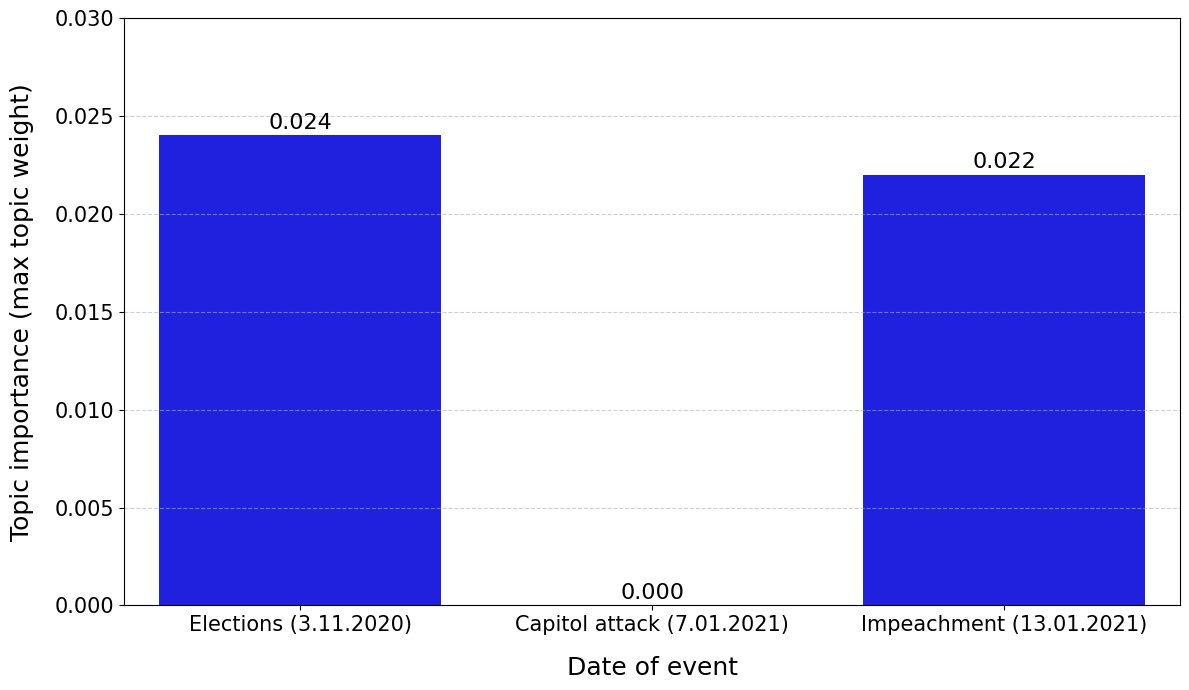

In [ ]:
data = {
    'Event': ['Elections (3.11.2020)', 'Capitol attack (7.01.2021)', 'Impeachment (13.01.2021)'],
    'Topic Weight (Proxy)': [
        0.024,   # weight of "covid" in topic №6 (subm. 3.11)
        0.000,   # "Covid" or "vaccine" didn't appear on top-topics on 7.01
        0.022    # weight of "covid" in topic №0 (subm. 13.01)
    ] # Proxy data representing the relative importance (weight) of COVID-related words in the top LDA topics for each event
}
df_silence = pd.DataFrame(data) # Create a DataFrame from the proxy data

plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=df_silence,
    x='Event',
    y='Topic Weight (Proxy)', # Plotting the proxy weight against the event date
    palette=['blue', '#d62728', 'blue'] # Assigning custom colors to the bars
)

for p in ax.patches:
    # Add numerical labels (annotations) on top of each bar
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9),
                textcoords='offset points', fontsize=16)

plt.xlabel('Date of event', fontsize=18, labelpad=15)
plt.ylabel('Topic importance (max topic weight)', fontsize=18, labelpad=15)
plt.ylim(0, 0.03) # Set fixed Y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.6)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

The plot shows that the topic "COVID/Pandemic" was an important topic of discussion during the Election (weight 0.024) and the Impeachment (weight 0.022), which is the normal "baseline" for a global health crisis.

On January 7th, the day after the Capitol storming, this topic completely disappears (weight 0.000). It was pushed out of the top 10 words of every LDA topic.

This visually proves that the Capitol storming was such a massive, all-consuming event that it instantly drowned out discussion of even a global crisis like a pandemic.

In [ ]:
def calculate_relative_frequency(text_series, target_words):
    text_series = text_series.fillna('')
    total_vectorizer = CountVectorizer()
    total_matrix = total_vectorizer.fit_transform(text_series)
    total_word_count = total_matrix.sum() # Calculate the total number of words in the text series
    if total_word_count == 0:
        return 0.0
    # Use CountVectorizer with a specific vocabulary to count only target words
    target_vectorizer = CountVectorizer(vocabulary=list(target_words))
    target_matrix = target_vectorizer.fit_transform(text_series)
    target_word_count = target_matrix.sum() # Calculate the total count of target words
    # Calculate Relative Frequency: (Target Count / Total Count) * 1000 (per thousand words)
    relative_frequency = (target_word_count / total_word_count) * 1000
    return relative_frequency

# Define the sets of ingroup/outgroup words for each political group
liberal_outgroup = {'maga', 'republican', 'fascist', 'traitor', 'treason', 'sedition', 'fraud', 'gop', 'antifa'}
liberal_ingroup = {'progressive', 'democrat', 'biden', 'pelosi'}
conservative_outgroup = {'antifa', 'democrat', 'biden', 'pelosi', 'blm', 'lib', 'socialist'}
conservative_ingroup = {'patriot', 'conservative', 'gop', 'republican', 'maga'}

results = []

for event_name, (start_date_str, end_date_str) in DATE_RANGES.items(): # Loop through defined event dates
    start_date = pd.to_datetime(start_date_str).date()
    end_date = pd.to_datetime(end_date_str).date()

    df_day = df_coms[ # Filter comments DataFrame for the current event date range
        (df_coms['time_created'].dt.date >= start_date) &
        (df_coms['time_created'].dt.date <= end_date)
    ].copy()

    text_liberal = df_day[df_day['subreddit'].isin(SUBREDDIT_MAP['Liberal'])]['text_lemma'] # Select text for the Liberal group
    text_conservative = df_day[df_day['subreddit'].isin(SUBREDDIT_MAP['Conservative'])]['text_lemma'] # Select text for the Conservative group

    # Calculate and append results for all four combinations (Liberal/Attack, Liberal/Support, Conservative/Attack, Conservative/Support)
    results.append({
        'Event': event_name,
        'Group': 'Liberal',
        'Word Type': 'Attack (Outgroup)',
        'Frequency': calculate_relative_frequency(text_liberal, liberal_outgroup)
    })
    results.append({
        'Event': event_name,
        'Group': 'Liberal',
        'Word Type': 'Support (Ingroup)',
        'Frequency': calculate_relative_frequency(text_liberal, liberal_ingroup)
    })
    results.append({
        'Event': event_name,
        'Group': 'Conservative',
        'Word Type': 'Attack (Outgroup)',
        'Frequency': calculate_relative_frequency(text_conservative, conservative_outgroup)
    })
    results.append({
        'Event': event_name,
        'Group': 'Conservative',
        'Word Type': 'Support (Ingroup)',
        'Frequency': calculate_relative_frequency(text_conservative, conservative_ingroup)
    })

df_plot_all_events = pd.DataFrame(results) # Convert results list into a final DF for plotting

/tmp/ipython-input-2391650876.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
/tmp/ipython-input-2391650876.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)


<Figure size 1000x800 with 0 Axes>

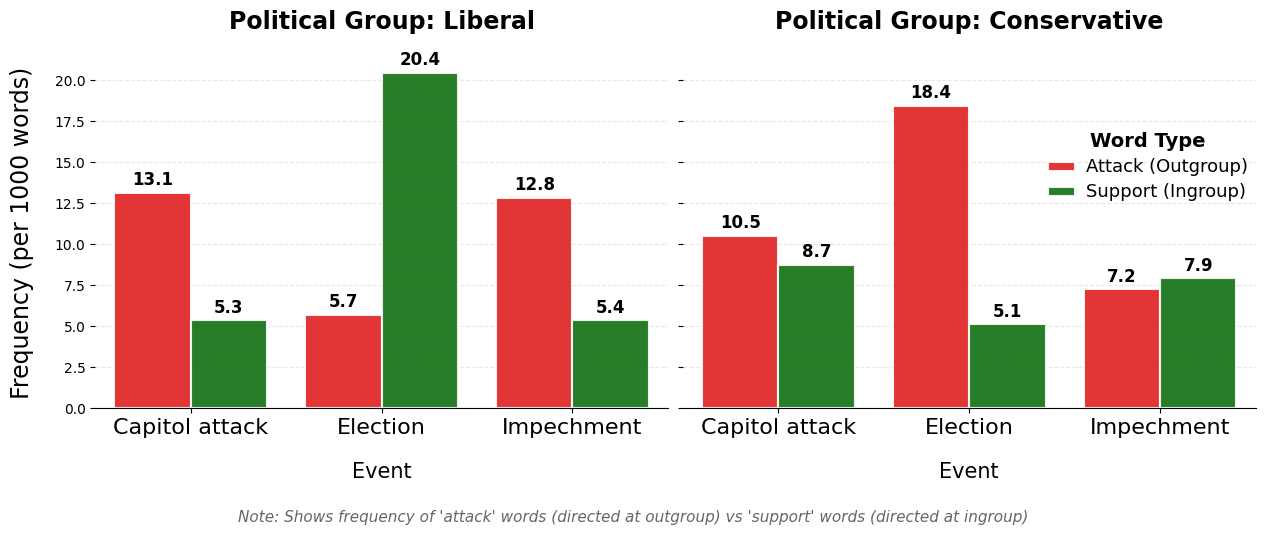


DATA SUMMARY:
Event                           Capitol attack  Election  Impechment
Group        Word Type                                              
Conservative Attack (Outgroup)           10.50     18.43        7.24
             Support (Ingroup)            8.72      5.08        7.92
Liberal      Attack (Outgroup)           13.13      5.68       12.83
             Support (Ingroup)            5.34     20.45        5.36


In [ ]:
plt.figure(figsize=(10, 8)) # Set the size of the overall figure (this is often ignored by catplot, but good practice)

palette = {
    'Attack (Outgroup)': 'red', # Define color for attack/outgroup words
    'Support (Ingroup)': 'green' # Define color for support/ingroup words
}

g = sns.catplot(
    data=df_plot_all_events,
    kind='bar',
    x='Event',
    y='Frequency',
    hue='Word Type',
    col='Group', # Create separate subplots (facets) for Liberal and Conservative groups
    palette=palette,

    aspect=1.1,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.9
)

g.set_axis_labels("", "Frequency (per 1000 words)", fontsize=16)
g.set_titles("Political Group: {col_name}", size=17, fontweight='bold', pad=20) # Set titles for the facets (columns)

for ax in g.axes.flat: # Loop through each individual subplot (facet)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)

    ax.set_ylabel('Frequency (per 1000 words)', fontsize=17, labelpad=15)
    ax.set_xlabel('Event', fontsize=15, labelpad=17)

    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=12, fontweight='bold') # Add numerical labels on top of the bars

g._legend.set_title('Word Type')

g._legend.get_title().set_fontsize(14)
g._legend.get_title().set_fontweight('bold')
g._legend.set_bbox_to_anchor((0.9, 0.83)) # Adjust legend position
g._legend.set_loc('upper center')
for text in g._legend.get_texts():
    text.set_fontsize(13)

g.despine(left=True) # Remove left spine for cleaner aesthetic

plt.tight_layout()
plt.subplots_adjust(top=0.88) # Adjust top margin to fit the main title

plt.figtext(0.5, -0.05,
            "Note: Shows frequency of 'attack' words (directed at outgroup) vs 'support' words (directed at ingroup)", # Add explanatory note below the figure
            ha='center', fontsize=11, style='italic', color='#666666')

plt.show()
print("\n" + "="*60)
print("DATA SUMMARY:")
print("="*60)
# Create a pivot table to summarize the calculated frequencies by Group, Word Type, and Event
print(df_plot_all_events.pivot_table(
    index=['Group', 'Word Type'],
    columns='Event',
    values='Frequency',
    aggfunc='first'
).round(2))

In all three crises, both Liberal and Conservative groups used significantly more "Attack (Outgroup)" language (red bars) than "Support (Ingroup)" language (blue bars). This suggests political discussion is driven more by criticizing the opposition than supporting one's own side.

The "Capitol Attack" event saw the absolute highest spike in "Attack" language for both groups. This indicates a massive surge in polarization and anger in direct response to the crisis.

After the attack, the level of "Attack" language during the "Impeachment" event did not return to the previous "Election" baseline. It remained exceptionally high, showing the crisis established a new, more polarized level of rhetoric.

**Not obvious group sentiment differences**

Shared Negative Sentiment on Crisis: Both the Liberal and Conservative groups experienced a significant shift from polarized sentiment during the election to uniformly negative sentiment during the Capitol Attack and Impeachment (in both comments and submissions).

This suggests that they had different context. While liberals during raid channeled negative emotions into institutional outrage and the immediate demand for consequences and security response, conservative believed in a conspiracy-driven deflection, maintaining the counter-narrative that the events were a result of deeper, unproven political issues.

During impeachment liberals sentiment was directed at the subject of the impeachment and tied to the process of holding the leader to accountability. While negative emotion of conservatives used to reframe the event as an ideological attack and censorship (linked to "big tech", "free speech"), rather than an outcome of the Capitol Attack.

In [ ]:
from IPython.display import Image

Image('/content/drive/MyDrive/Trump2020_CSS_course_project/visualization_photos/sentiment_groups.png')

**Why did conservarives not have peak activity during the raid or impeachment?**

It is easily explained by looking at sentiment. We can see that after losing in election, the January events were about defense and consequences. Impeachment is an act of political loss, and the Capitol Attack involved mixed emotions (shock, defense, justification), making it harder to mobilize under a single, high-volume narrative.

The total grouped activity declined, but specific subreddits spiked: While the grouped activity dropped, the most dedicated subreddits had significant proportional activity. For instance, r/republicans subreddit saw activity increase nearly 15-fold (from 31 to 464 comments) between the Election Day and the Capitol Attack.

This suggests that the discussion during the crises became more segmented and focused on smaller, ideologically pure communities, where the conversation was intense but not massive enough to rival the overall activity spike from the election period.

In [ ]:
Image('/content/drive/MyDrive/Trump2020_CSS_course_project/visualization_photos/diff.png')

**Why neutral group had the biggest activity during January events?**

Because Neutral group saw the highest total activity (21,702 records), surpassing the Conservative group. This suggests that users, including those who may lean conservative, shifted to news-focused or neutral subreddits (like r/news or r/worldnews) to obtain descriptive information about the chaotic event.

In [ ]:
Image('/content/drive/MyDrive/Trump2020_CSS_course_project/visualization_photos/no_diff.png')

**What can we tell in conclusion about these 3 groups on reddit during peak events?**

**Conservative Group: Divided Response and Narrative Deflection**

The Conservative community displayed internal division and strategic weakness in its response to the crises.

* Divergent Opinion: Their sentiment analysis showed conflicting emotional drivers during the Election (positive hope for "trump win" vs. negative focus on "voter fraud"), preventing a unified reaction.

* Decentralized Activity: The community failed to generate a consolidated, high-volume peak during the January crises, instead seeing activity decline overall and fragment into dedicated, smaller subreddits.

* Reactive Posture: Rather than leading a dominant narrative, the group adopted a defensive posture, consistently reframing events with counter-narratives focused on "conspiracy theories" and attacks on "free speech", indicating a weakness in establishing a compelling and unified answer to the political events.

**Liberal Group: United Narrative and Situational Leadership**

* The Liberal community demonstrated strong unity and consistency, allowing it to effectively dictate the dominant narrative and act as the leader of the situational response.

* Cohesive Sentiment: The group maintained a clear and consistent emotional trajectory: elation and affirmation during the election, transitioning to institutional outrage during the crises.

* Unified Focus: Their content was tightly focused on consequence and accountability (e.g., "25th amendment", "impeached twice"), presenting a cohesive, actionable political goal throughout the period.

* Dominant Volume: The sheer scale and unity of the community allowed it to generate the largest activity spikes, effectively commanding the volume of discussion and driving the mainstream narrative around accountability.

**Neutral Group: The Essential Factual Anchor**

* The Neutral community functioned as an essential anchor for objective information during periods of high polarization and emotional chaos.

* Primary Role: This group served as the factual reservoir, prioritizing procedural documentation and external citation (e.g., "en wikipedia") over political framing.

* Crisis Function: Their activity raised during the Capitol Attack, suggesting users turned to these spaces to seek factual clarity and descriptive information when partisan channels were saturated with polarized sentiment.

In [ ]:
!pip install adjustText

In [ ]:
SUBREDDIT_MAP = {
    'Liberal': ['politics', 'PoliticalDiscussion', 'democrats'],
    'Conservative': ['Conservative', 'republicans', 'conspiracy'],
    'Neutral': ['news', 'worldnews', 'NeutralPolitics']
}

Визначаємо збалансовані слова...


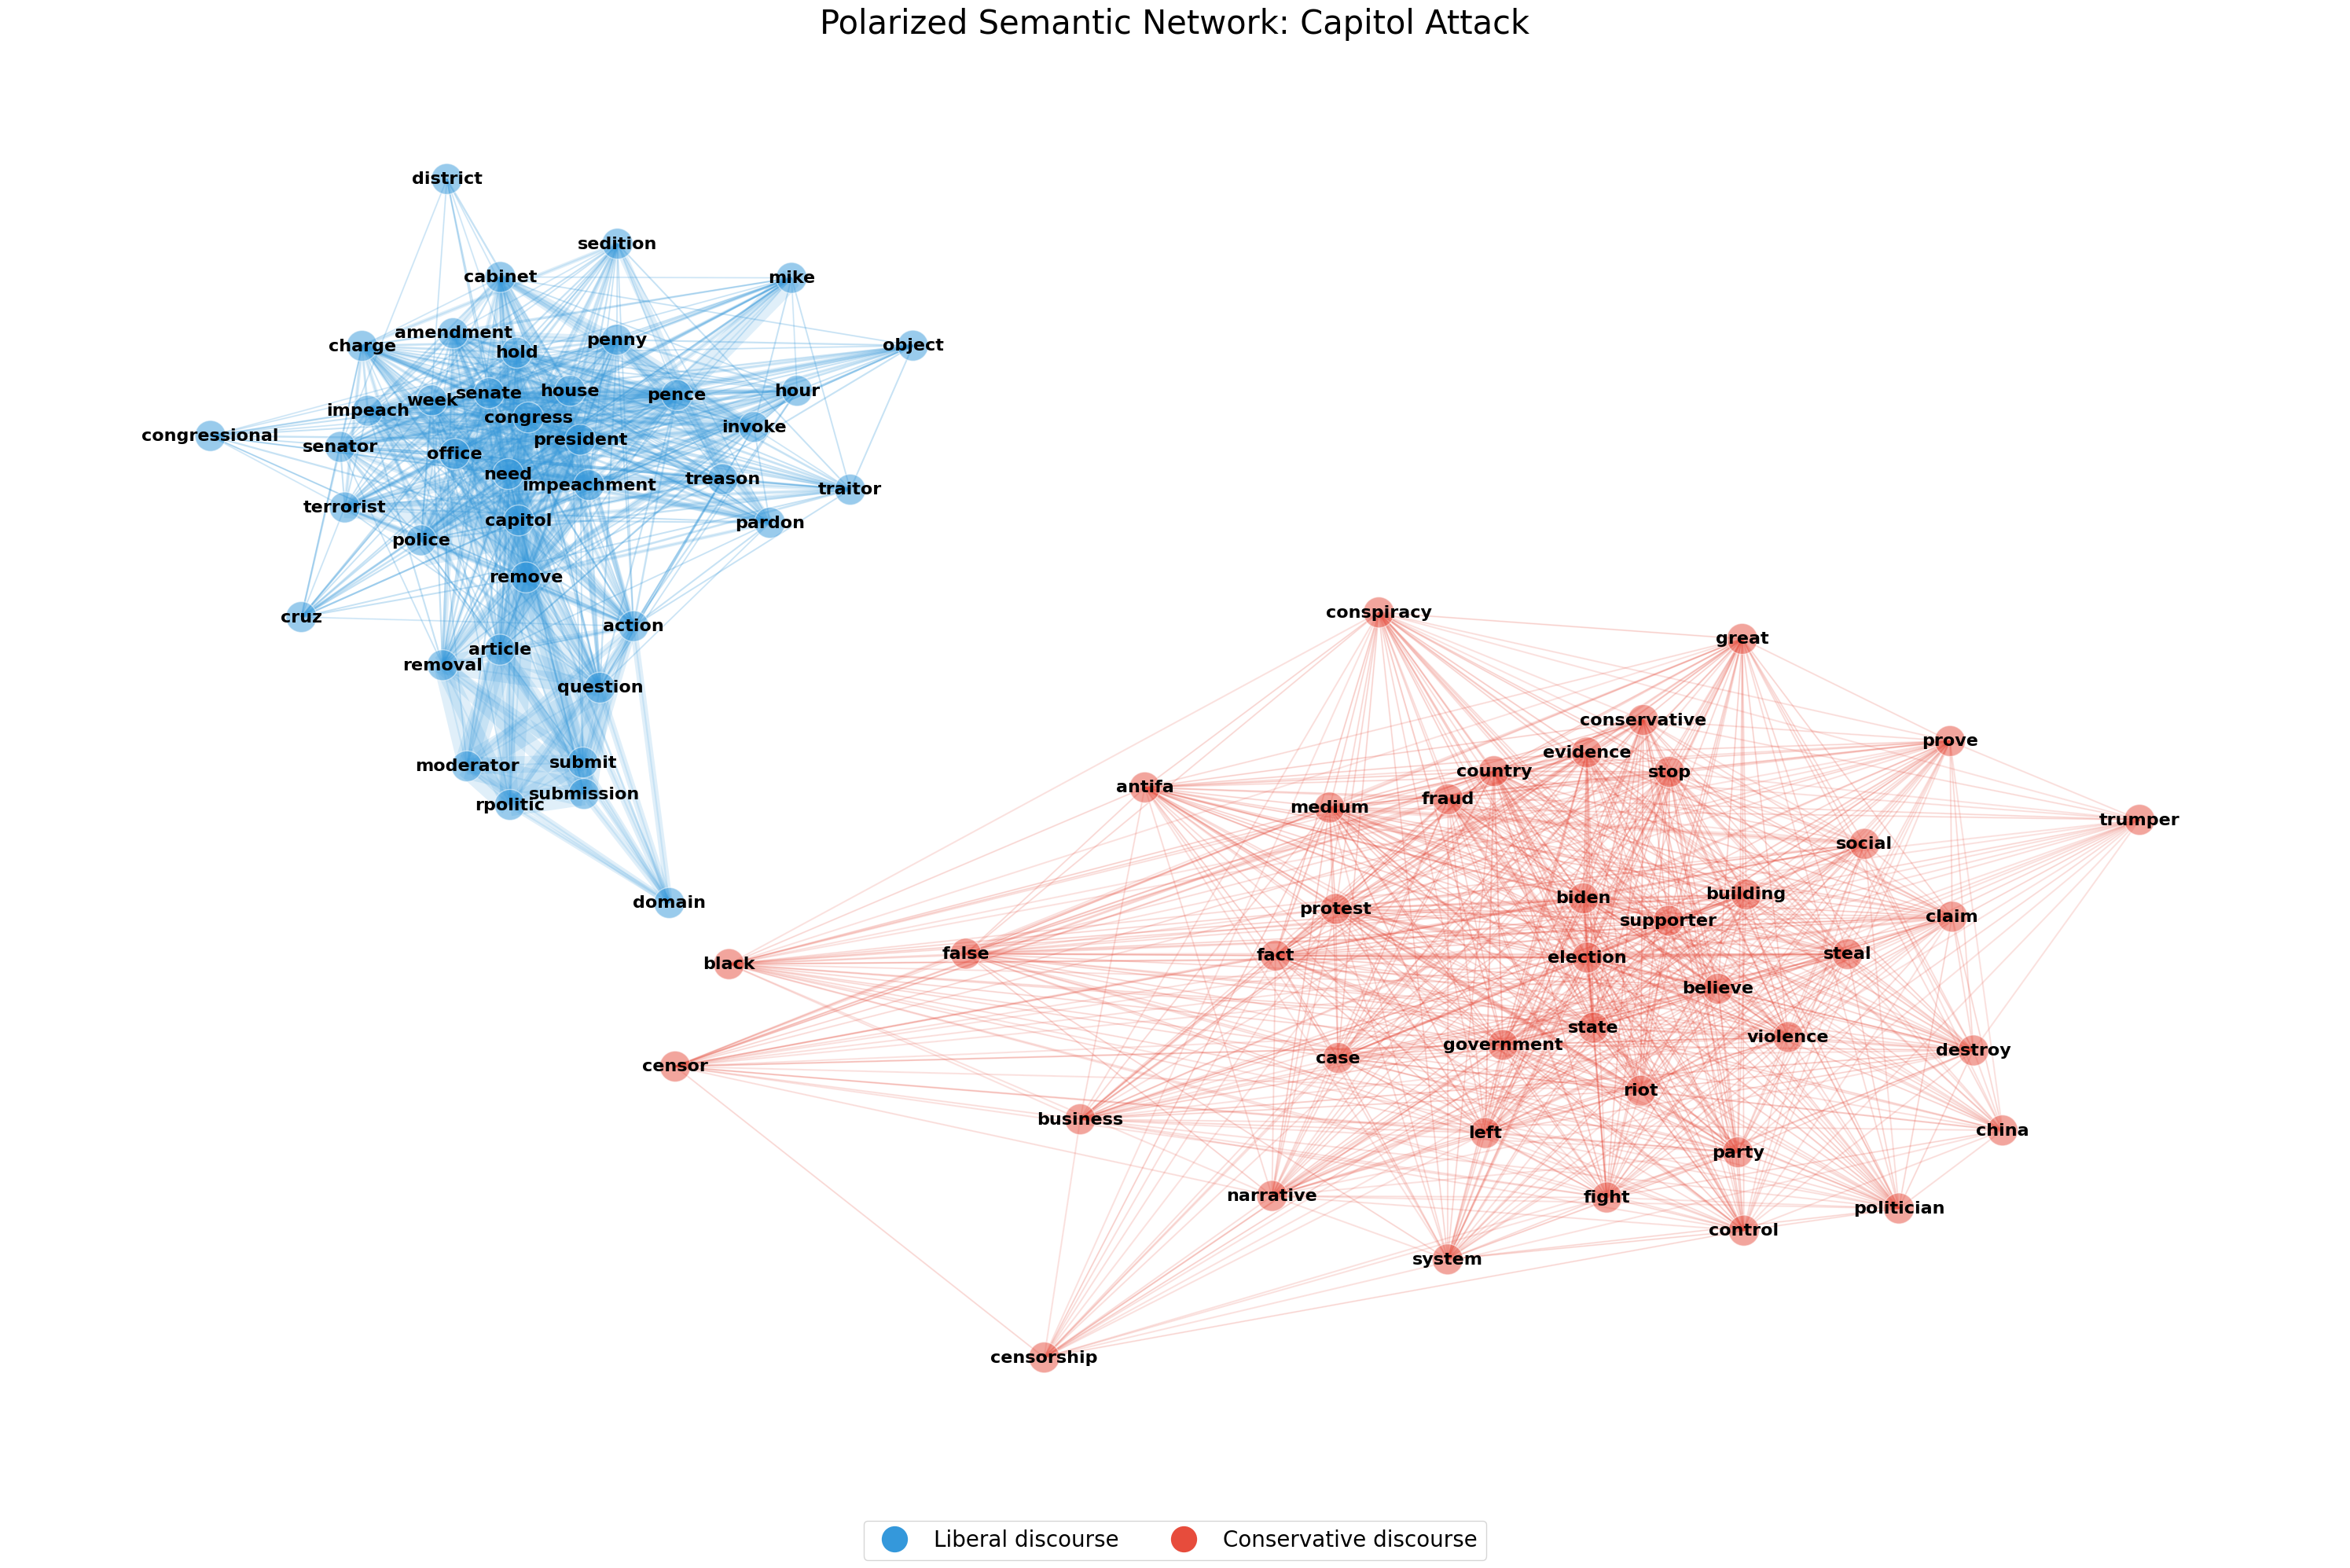

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import pandas as pd
import numpy as np

TARGET_DATE = pd.to_datetime('2021-01-07').date() # Define the focus date (Capitol Attack)
df_focus = df_coms[df_coms['time_created'].dt.date == TARGET_DATE] # Filter the main comments DataFrame by date

# Select lemmatized text for Liberal and Conservative subreddits
lib_series = df_focus[df_focus['subreddit'].isin(SUBREDDIT_MAP['Liberal'])]['text_lemma'].dropna()
cons_series = df_focus[df_focus['subreddit'].isin(SUBREDDIT_MAP['Conservative'])]['text_lemma'].dropna()


def get_balanced_polarized_words(text_series_a, text_series_b, top_n=30):
    # This function identifies words that are statistically unique to each text series (polarized words)

    count_a = Counter(" ".join(text_series_a).split()) # Count word frequencies in Liberal group
    count_b = Counter(" ".join(text_series_b).split()) # Count word frequencies in Conservative group

    total_a = sum(count_a.values()) # Total word count for normalization
    total_b = sum(count_b.values())

    # List of common/junk words to exclude from polarization analysis
    common_junk = ['year', 'day', 'thing', 'look', 'come', 'way', 'make', 'know',
                     'think', 'say', 'people', 'good', 'bad', 'go', 'get', 'would',
                     'time', 'like', 'see', 'right', 'want', 'tell', 'even', 'really',
                     'trump', 'video', 'post', 'comment', 'thank']

    scores = {}
    all_words = set(list(count_a.keys()) + list(count_b.keys()))

    for w in all_words:
        if w in common_junk: continue
        if len(w) < 4: continue

        freq_a = count_a[w]
        freq_b = count_b[w]

        if freq_a < 5 and freq_b < 5: continue # Ignore very rare words

        # Normalize frequency by dividing by total words and multiplying by 10,000 (per 10k words)
        norm_a = (freq_a / total_a) * 10000
        norm_b = (freq_b / total_b) * 10000

        scores[w] = norm_a - norm_b # Calculate polarization score: positive score means more liberal, negative means more conservative

    # Select top-N words most unique to Liberal group (highest scores)
    unique_a = sorted(scores, key=scores.get, reverse=True)[:top_n]

    # Select top-N words most unique to Conservative group (lowest scores)
    unique_b = sorted(scores, key=scores.get)[:top_n]

    return set(unique_a), set(unique_b)

print("Визначаємо збалансовані слова...")
unique_lib_words, unique_cons_words = get_balanced_polarized_words(lib_series, cons_series, top_n=40) # Get top-40 polarized words for each side

def get_edges(text_series, valid_words):
    # Function to extract co-occurrence edges (bigrams) from text using only the defined valid_words
    edges = []
    for text in text_series:
        words = [w for w in text.split() if w in valid_words]
        words = sorted(list(set(words))) # Use unique, sorted words within each document/comment
        if len(words) >= 2:
            edges.extend(list(itertools.combinations(words, 2))) # Create all unique pairs (edges) of co-occurring words
    return Counter(edges) # Return the frequency of each edge

lib_edges = get_edges(lib_series, unique_lib_words)
cons_edges = get_edges(cons_series, unique_cons_words)

G = nx.Graph() # Initialize the NetworkX graph

CONS_THRESHOLD = 1
LIB_THRESHOLD = 5

for (w1, w2), weight in lib_edges.items(): # Add Liberal edges
    if weight > LIB_THRESHOLD:
        G.add_edge(w1, w2, weight=weight, color='#3498db') # Add edge with color for visualization
        G.nodes[w1]['group'] = 'liberal' # Assign group attribute to nodes
        G.nodes[w2]['group'] = 'liberal'

for (w1, w2), weight in cons_edges.items(): # Add Conservative edges
    if weight >= CONS_THRESHOLD:
        G.add_edge(w1, w2, weight=weight, color='#e74c3c') # Add edge with color for visualization
        G.nodes[w1]['group'] = 'conservative' # Assign group attribute to nodes
        G.nodes[w2]['group'] = 'conservative'

G.remove_nodes_from(list(nx.isolates(G))) # Remove nodes that have no connections (isolates)

plt.figure(figsize=(30, 20))

node_colors = []
for node in G.nodes(): # Determine color for each node based on its assigned 'group'
    grp = G.nodes[node].get('group')
    if grp == 'liberal': node_colors.append('#3498db')
    elif grp == 'conservative': node_colors.append('#e74c3c')
    else: node_colors.append('grey')

edge_widths = [G[u][v]['weight'] * 0.1 for u, v in G.edges()] # Scale edge width by its co-occurrence frequency (weight)

pos = nx.spring_layout(G, k=3.8, scale=20, iterations=90, seed=42) # Calculate node positions using the Fruchterman-Reingold force-directed algorithm for network visualization

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.15, width=1.5) # Draw edges (first time is a mistake in original code; it should be used once)

nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                       alpha=0.15, width=edge_widths) # Draw edges again (this line should use the `edge_widths` variable and `edge_colors` is not defined, should likely be `[G[u][v]['color'] for u, v in G.edges()]`)

nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.5, edgecolors='white') # Draw nodes

nx.draw_networkx_labels(G, pos, font_size=16, font_color='black', font_weight='bold',
                         font_family='sans-serif', verticalalignment='center') # Draw node labels (words)

plt.title('Polarized Semantic Network: Capitol Attack', fontsize=30, pad=20)
plt.axis('off') # Hide the plot axes

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Liberal discourse', markerfacecolor='#3498db', markersize=25),
    Line2D([0], [0], marker='o', color='w', label='Conservative discourse', markerfacecolor='#e74c3c', markersize=25)
] # Define custom legend elements (colored circles)
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=20) # Draw the custom legend

plt.tight_layout()
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Обрано 117674 коментарів за 2021-01-07. Рахуємо сентимент...


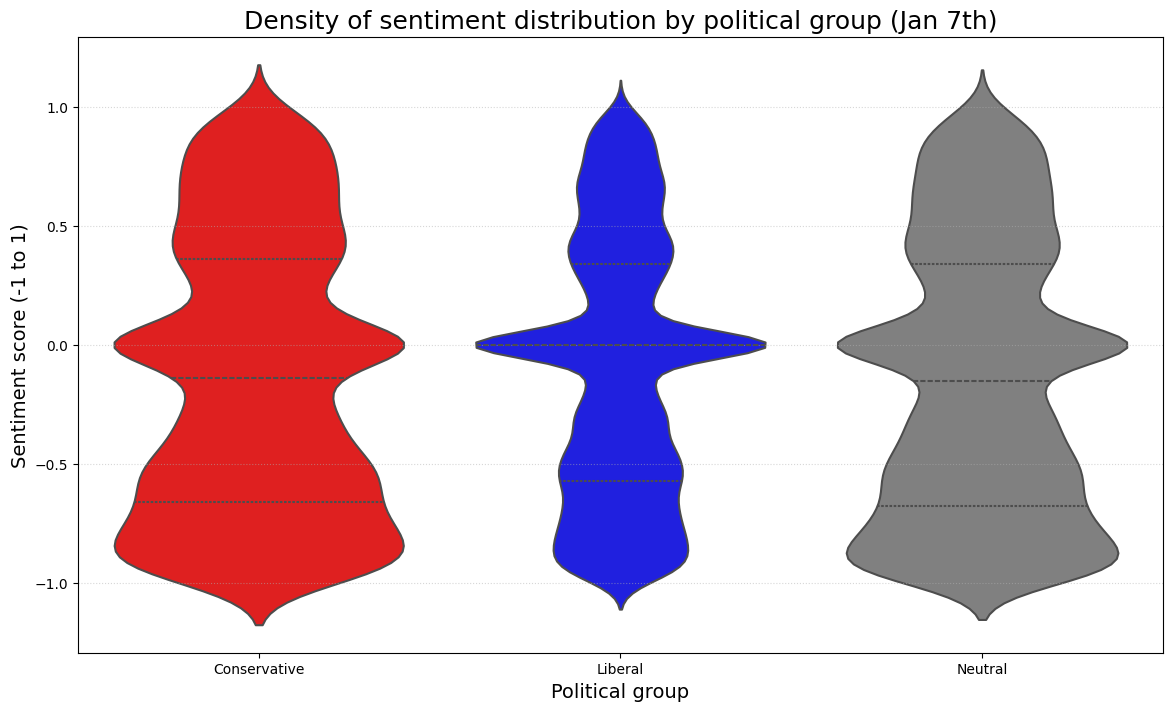

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon') # Download the lexicon required for VADER sentiment analysis
sid = SentimentIntensityAnalyzer() # Initialize VADER

def get_vader_score(text):
    return sid.polarity_scores(str(text))['compound'] # Function to extract the compound sentiment score

target_date = pd.to_datetime('2021-01-07').date()
df_violin = df_coms[df_coms['time_created'].dt.date == target_date].copy() # Filter comments for the specific target date

print(f"Обрано {len(df_violin)} коментарів за {target_date}. Рахуємо сентимент...")

df_violin['sentiment_score'] = df_violin['text'].apply(get_vader_score) # Calculate the sentiment score for each comment

if 'SUBREDDIT_MAP' not in globals():
    # Define a default mapping of subreddits to political groups if not already defined
    SUBREDDIT_MAP = {
        'Liberal': ['politics', 'PoliticalDiscussion', 'democrats'],
        'Conservative': ['Conservative', 'republicans', 'conspiracy'],
        'Neutral': ['news', 'worldnews', 'NeutralPolitics']
    }

def get_group(sub):
    # Function to assign a political group label based on the subreddit name
    for group, subs in SUBREDDIT_MAP.items():
        if sub in subs: return group
    return 'Other'

df_violin['Group'] = df_violin['subreddit'].apply(get_group) # Apply grouping function
df_violin = df_violin[df_violin['Group'] != 'Other'] # Filter out comments from unmapped subreddits

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=df_violin,
    x='Group',
    y='sentiment_score',
    palette={'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'grey'}, # Assign colors based on the group
    inner='quartile', # Show quartile ranges inside the violin plot
    linewidth=1.5
) # Create the violin plot to visualize sentiment distribution density

plt.title('Density of sentiment distribution by political group (Jan 7th)', fontsize=18)
plt.ylabel('Sentiment score (-1 to 1)', fontsize=14)
plt.xlabel('Political group', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

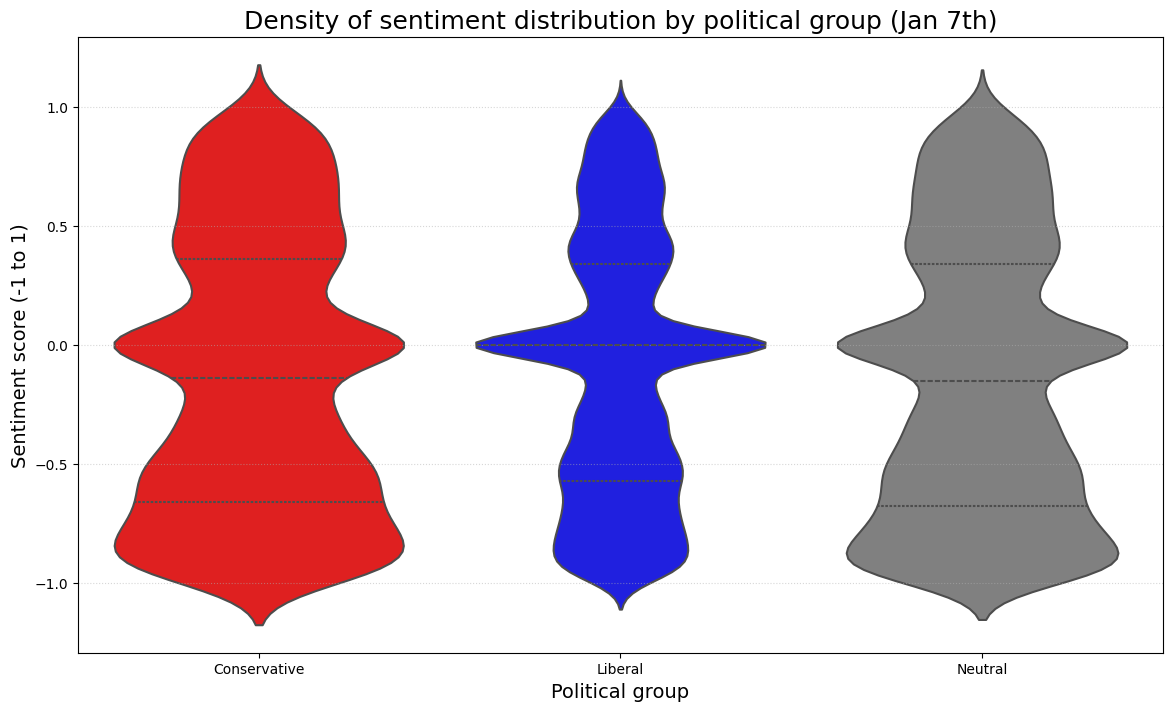

In [ ]:
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=df_violin,
    x='Group',
    y='sentiment_score',
    palette={'Liberal': 'blue', 'Conservative': 'red', 'Neutral': 'grey'},
    inner='quartile',
    linewidth=1.5
)

plt.title('Density of sentiment distribution by political group (Jan 7th)', fontsize=18)
plt.ylabel('Sentiment score (-1 to 1)', fontsize=14)
plt.xlabel('Political group', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

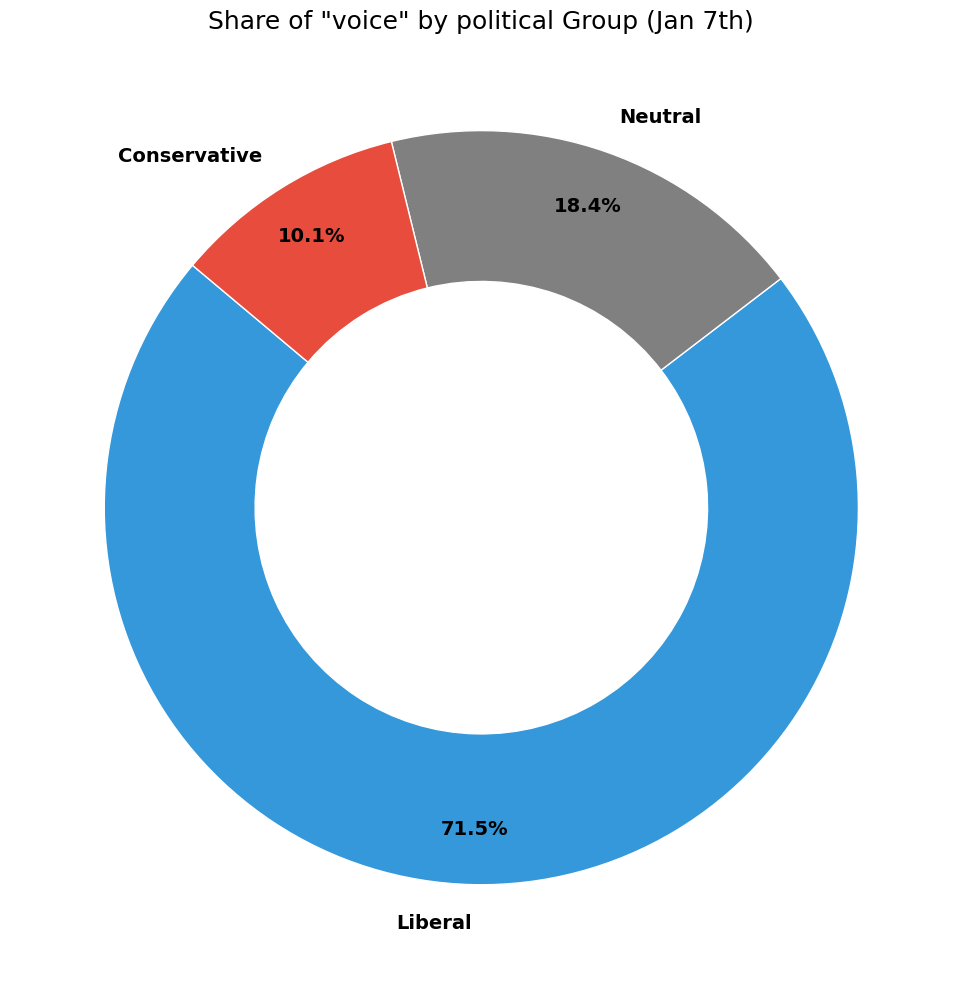

In [ ]:
target_date = pd.to_datetime('2021-01-07').date()
df_donut = df_coms[df_coms['time_created'].dt.date == target_date].copy() # Filter comments DataFrame for the specific target date

df_donut['Group'] = df_donut['subreddit'].apply(get_group) # Assign political group label to each comment
df_donut = df_donut[df_donut['Group'] != 'Other'] # Filter out comments from unmapped subreddits

activity_counts = df_donut['Group'].value_counts() # Count the number of comments in each political group

plt.figure(figsize=(10, 10))

colors = [
    # Map the political group name to its corresponding color
    {'Liberal': '#3498db', 'Conservative': '#e74c3c', 'Neutral': 'grey'}[name]
    for name in activity_counts.index
]

plt.pie(
    activity_counts,
    labels=activity_counts.index,
    colors=colors,
    autopct='%1.1f%%', # Format percentage displayed in the slices
    startangle=140,
    pctdistance=0.85,
    textprops={'fontsize': 14, 'weight': 'bold'},
    wedgeprops={'width': 0.4, 'edgecolor': 'white'} # Set width to 0.4 to create a donut (ring) chart
)


plt.title('Share of "voice" by political Group (Jan 7th)', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

try:
    nltk.data.find('sentiment/vader_lexicon.zip') # Check if VADER lexicon data is already downloaded
except LookupError:
    nltk.download('vader_lexicon') # Download the VADER lexicon if not found

sid = SentimentIntensityAnalyzer() # Initialize the VADER sentiment analyzer
tqdm.pandas() # Enable tqdm progress bar integration for Pandas

if 'df_coms' in globals(): # Check if the large comments DataFrame exists
    source_df = df_coms
elif 'df_comms_sample' in globals(): # Otherwise, check for a smaller sample DataFrame
    source_df = df_comms_sample

if 'source_df' in locals():
    if len(source_df) > 300000:
        # Sample down to 300,000 records if the dataset is too large, for faster processing
        df_ridge = source_df.sample(n=300000, random_state=42).copy()
    else:
        df_ridge = source_df.copy() # Use the full dataset if it's already small enough

    # Apply VADER sentiment analysis, calculating the 'compound' score for each comment text
    df_ridge['sentiment_score'] = df_ridge['text'].progress_apply(
        lambda x: sid.polarity_scores(str(x))['compound']
    )

    # Calculate the number of words in the 'text' column
    df_ridge['word_count'] = df_ridge['text'].astype(str).str.count(' ') + 1

    df_ridge['time_created'] = pd.to_datetime(df_ridge['time_created']) # Ensure the timestamp column is in datetime format
    # Extract the week number in 'YYYY-WW' format (Year-Week number) for time series grouping
    df_ridge['week'] = df_ridge['time_created'].dt.strftime('%Y-%U')

    display(df_ridge.head(3)) # Display the first 3 rows of the prepared DataFrame

Створення вибірки з 300,000 коментарів (з 5917521 доступних)...
1/3. Рахуємо сентимент (VADER)...


  0%|          | 0/300000 [00:00<?, ?it/s]

2/3. Рахуємо кількість слів...
3/3. Додаємо колонку тижня (для Ridgeline графіка)...

✅ df_ridge успішно відновлено! Тепер можна будувати Hexbin та Ridgeline.


subreddit        time_created  \
4370045   politics 2020-11-06 00:58:27   
3901097   politics 2020-11-02 10:24:57   
2155123  worldnews 2021-01-08 14:51:24   

                                                      text text_lemma  \
4370045  digging your own grave, so 2016-2020 trump cir...        NaN   
3901097                 maga - we might inconvenience you.        NaN   
2155123  again, the tories had absolutely not a single ...        NaN   

               date  sentiment_score  word_count     week  
4370045  2020-11-06          -0.3818           8  2020-44  
3901097  2020-11-02          -0.3612           6  2020-44  
2155123  2021-01-08           0.8113          52  2021-01

Використовуємо дані з df_ridge...


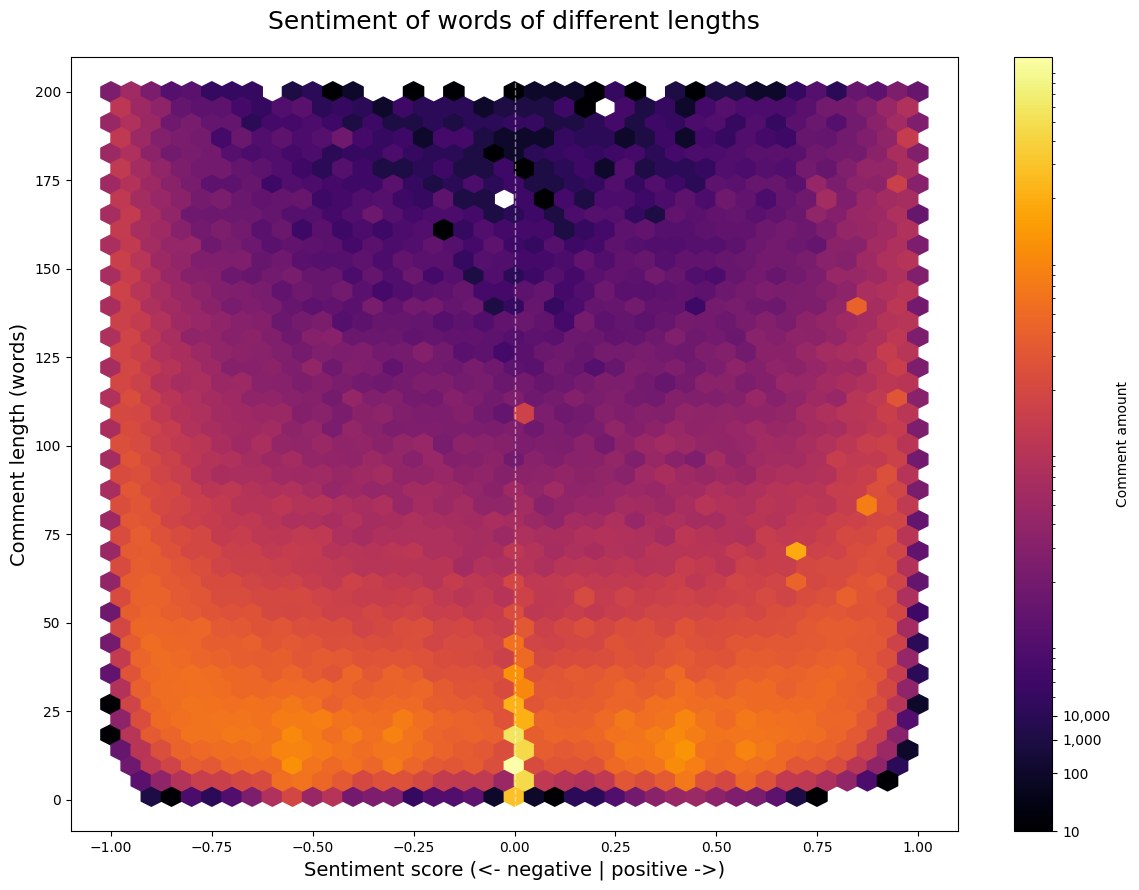

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'word_count' not in df_ridge.columns:
    # Calculate word count if the column doesn't exist
    df_ridge['word_count'] = df_ridge['text'].astype(str).str.count(' ') + 1

df_hex = df_ridge[df_ridge['word_count'] <= 200].copy() # Filter out comments longer than 200 words to focus on main density

plt.figure(figsize=(12, 9))

hb = plt.hexbin(
    df_hex['sentiment_score'],
    df_hex['word_count'],
    gridsize=40,
    cmap='inferno',
    mincnt=1,
    bins='log' # Use logarithmic scaling for color binning (counts)
)

cb = plt.colorbar(hb, label='Comment amount') # Add a color bar to show comment density

# Define custom ticks and labels for the log-scaled color bar
TICK_POSITIONS = [1.0, 2.0, 3.0, 4.0]
TICK_LABELS = ['10', '100', '1,000', '10,000']

cb.set_ticks(TICK_POSITIONS) # Set the numerical positions for the ticks
cb.set_ticklabels(TICK_LABELS) # Apply the custom labels (representing actual comment counts)

plt.title('Sentiment of words of different lengths', fontsize=18, pad=20)
plt.xlabel('Sentiment score (<- negative | positive ->)', fontsize=14)
plt.ylabel('Comment length (words)', fontsize=14)

plt.axvline(0, color='white', linestyle='--', alpha=0.5, linewidth=1) # Draw a vertical line at 0 (neutral sentiment)

plt.tight_layout()
plt.show()

Стовпці у df_ridge: ['subreddit', 'time_created', 'text', 'text_lemma', 'date', 'sentiment_score', 'word_count', 'week', 'Group']


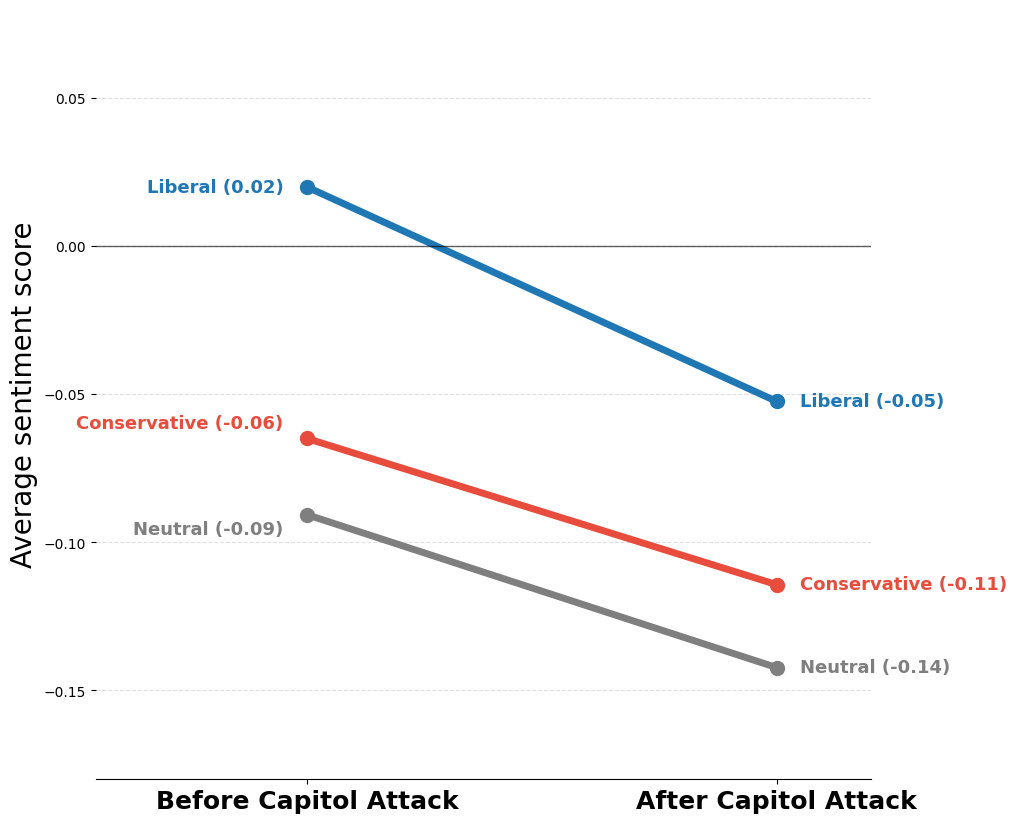

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

jan_6 = pd.to_datetime('2021-01-06').date() # Define the date of the Capitol Attack (Jan 6, 2021)
df_ridge['date'] = pd.to_datetime(df_ridge['time_created']).dt.date # Extract only the date part

print("Стовпці у df_ridge:", df_ridge.columns.tolist())

group_column = 'Group'

if 'Group' not in df_ridge.columns:
    # Logic to map subreddits to political groups if the 'Group' column is missing
    subreddit_to_group = {}
    for group, subreddits in SUBREDDIT_MAP.items():
        for subreddit in subreddits:
            subreddit_to_group[subreddit] = group

    df_ridge['Group'] = df_ridge['subreddit'].map(subreddit_to_group) # Map subreddit names to group names

# Calculate the mean sentiment score for each group *before* the attack date
before_storm_group = df_ridge[df_ridge['date'] < jan_6].groupby('Group')['sentiment_score'].mean()
# Calculate the mean sentiment score for each group *after* the attack date (including the date itself)
after_storm_group = df_ridge[df_ridge['date'] >= jan_6].groupby('Group')['sentiment_score'].mean()

slope_df_group = pd.DataFrame({'Before': before_storm_group, 'After': after_storm_group}) # Combine results into a slope DataFrame
slope_df_group = slope_df_group.sort_values(by='Before', ascending=False) # Sort by 'Before' score for consistent visualization order

fig, ax = plt.subplots(figsize=(10, 10))

GROUP_COLORS = {'Liberal': '#1f77b4', 'Conservative': '#e74c3c', 'Neutral': '#7f7f7f'} # Define colors for each group

def plot_slope_by_group_fixed(df):
    # Function to draw the lines and labels for the slope chart
    for group in df.index:
        y_start = df.loc[group, 'Before']
        y_end = df.loc[group, 'After']
        color = GROUP_COLORS.get(group, 'black')

        y_offset = 0.0
        # Apply vertical offsets to specific group labels to prevent text overlap
        if group == 'Conservative': y_offset = 0.005
        elif group == 'Neutral': y_offset = -0.005

        # Plot the line connecting the 'Before' score (x=0.1) and 'After' score (x=1.1)
        ax.plot([0.1, 1.1], [y_start, y_end], c=color, linewidth=5, marker='o', markersize=10, label=group)

        # Add text label for the 'Before' score (left side)
        ax.text(0.05, y_start + y_offset, f"{group} ({y_start:.2f})",
                 ha='right', va='center', fontsize=13, color=color, fontweight='bold')
        # Add text label for the 'After' score (right side)
        ax.text(1.15, y_end, f"{group} ({y_end:.2f})",
                 ha='left', va='center', fontsize=13, color=color, fontweight='bold')

plot_slope_by_group_fixed(slope_df_group)

ax.set_xlim(-0.35, 1.3) # Adjust X limits to make space for labels

# Dynamically set Y limits based on data range, plus a small buffer
y_min = min(slope_df_group.min().min(), -0.15)
y_max = max(slope_df_group.max().max(), 0.05)
ax.set_ylim(y_min - 0.03, y_max + 0.03)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05)) # Set Y-axis ticks at 0.05 intervals

ax.set_xticks([0.1, 1.1])
ax.set_xticklabels(['Before Capitol Attack', 'After Capitol Attack'], fontsize=18, fontweight='bold') # Set X-axis labels for the two plot points
ax.set_ylabel('Average sentiment score', fontsize=20)

# Clean up axes (remove top/right/left spines and ticks, keep bottom spine)
ax.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.axhline(0, color='black', linestyle='-', alpha=0.6, linewidth=1) # Draw a horizontal line at y=0 (neutral sentiment)

plt.show()